# FYP - IllustrisTNG Lens Modelling

Lens Infomation:

No subhalos 

No shear - but still need to try shear

1st - Get the Position and position uncertainty 

Run positon constraint models

lambda CDM Cosmology

SIE 
NFW
POW
CORE SIE
EINASTO



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from error_propagation import Complex
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry
from photutils.psf import make_psf_model_image, CircularGaussianPSF, GaussianPSF, MoffatPSF
from tqdm import tqdm
import emcee
norm = ImageNormalize(stretch=SqrtStretch())

# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        # Read the contents of the file
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    # Define a function to find a line in the file
    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    # Set lens line number
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if shear == True:
        line_set_2 = find_line('glafic.set_lens(2,', content)
        line_opt_2 = find_line('glafic.setopt_lens(2,', content)

    # Split the content by new line
    content_list = content.split('\n')

    # Get the set_lens line
    set_lens_1 = content_list[line_set_1-1]

    # Get the setopt_lens line
    setopt_lens_1 = content_list[line_opt_1-1]

    # Define the list of possible models
    models = ['SIE', 'POW', 'NFW', 'EIN']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


    if shear == True:
    # Get the shear set_lens line
        set_lens_2 = content_list[line_set_2-1]

        # Get the shear setopt_lens line
        setopt_lens_2 = content_list[line_opt_2-1]

        parts_set_lens_2 = set_lens_2.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_2.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
            raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

        if 'pert' in set_lens_2:
            name = 'Shear'
            z_s = parts_set_lens_2[3]
            x = parts_set_lens_2[4]
            y = parts_set_lens_2[5]
            gamma = parts_set_lens_2[6]
            pa = parts_set_lens_2[7]
            NaN = parts_set_lens_2[8]
            pwi = parts_set_lens_2[9].replace(')', '') 

            z_s_flag = parts_setopt_lens_2[2]
            x_flag = parts_setopt_lens_2[3]
            y_flag = parts_setopt_lens_2[4]
            gamma_flag = parts_setopt_lens_2[5]
            pa_flag = parts_setopt_lens_2[6]
            NaN_flag = parts_setopt_lens_2[7]
            pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

            line = find_last_line('lens   pert', content_opt)
            line_content = content_opt.split('\n')[line - 1]
            line_list = line_content.split()

            row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
            row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
            row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
            row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

            table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            if show_shear:
                print(table_shear)

            if save_table_flag:
                table_shear.to_csv('shear_table.csv')
        return table_shear

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            elif i == models[3].lower(): # EIN model
                name = models[3]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                ce_rs = parts_set_lens[8]
                alpha_e = parts_set_lens[9].replace(')', '')

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                ce_rs_flag = parts_setopt_lens[7]
                alpha_e_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   ein', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']
                row_1 = ['Input Value', m, x, y, e, pa, ce_rs, alpha_e]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, ce_rs_flag, alpha_e_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None  # Explicitly return None if no model is found



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            df_pred = swap_rows(df_pred, i, (m-1))
        else:
            continue

    df_pred = df_pred.drop(columns =[3])

    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('ΔRMS = ' + rms_str, fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Position error')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.01).astype(int) - 2000
    h = (data_df[1]/0.01).astype(int) - 2000

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)


    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = (np.array(flux_pos_max) - np.array(flux_pos_min))/100
    # arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='.', color='black', capsize=5, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnification") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Error', fontsize=10)
    plt.suptitle('Lens ' + plot_name + ' constrained')
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    # colors = ['red',  'blue', 'green', 'gold']
    colors = obs['Label'].map({'Red Image': 'red', 'Green Image': 'green', 'Yellow Image': 'gold', 'Blue Image': 'blue'}).tolist()

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=-5)
    # Calculate the natural limits of the graph
    x_min, x_max = min(df[0]/0.04), max(df[0]/0.04)
    y_min, y_max = min(df[1]/0.04), max(df[1]/0.04)

    # Define a zoom factor
    zoom_factor = 0.2

    # Calculate the limits with the zoom factor
    x_range = (x_max - x_min) * zoom_factor
    y_range = (y_max - y_min) * zoom_factor

    plt.xlim(x_min - x_range, x_max + x_range)
    plt.ylim(y_min - y_range, y_max + y_range)

    plt.show()


    
    return df

# Initial Processing

In [58]:
image_file = "oldfiles/Rommulus_Mock_i2_SNIa_z1_cusp.fits"
# image_file = "Rommulus_withLight_Mock_i2_SNIa_z1_cusp.fits"

In [ ]:
hdu_list = fits.open(image_file)
hdu_list.info()

In [ ]:
hdu_list[0].header

In [ ]:
exposure = hdu_list[0].header['EXPT']
flux_density = hdu_list[0].header['PHOTFLAM']
flux_wavelength = hdu_list[0].header['WL_PIVOT']
pix_size = hdu_list[0].header['PIXSIZE']
z_l = hdu_list[0].header['Z_LENS']
z_s = hdu_list[0].header['Z_SOURCE']
gain = hdu_list[0].header['GAIN']
rdnoise = hdu_list[0].header['READNSE']
print('Exposure:', exposure)
print('Flux Density:', flux_density)
print('Flux Wavelength:', flux_wavelength)
print('Pixel Size:', pix_size)
print('Lens Redshift:', z_l)
print('Source Redshift:', z_s)
print('Gain:', gain)
print('Read Noise:', rdnoise)

In [66]:
image_data = hdu_list[0].data

In [ ]:
print(type(image_data))
print(image_data.shape)

In [68]:
hdu_list.close()

In [ ]:
# Plotting the original image
plt.figure(figsize=(10,8))
plt.imshow(image_data, cmap='inferno', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Original Image')
plt.colorbar(label='Electron/s')
plt.xlim(0, 125)
plt.ylim(0, 125)

In [72]:
df = pd.DataFrame(columns=['x', 'y', 'counts'])

In [73]:
# Convert to dataframe (more usable)
df['counts'] = image_data.flatten()
df['x'] = np.tile(np.arange(0, image_data.shape[0]), image_data.shape[1]) + 1
df['y'] = np.repeat(np.arange(0, image_data.shape[1]), image_data.shape[0]) + 1

In [ ]:
df

In [75]:
df['counts'] = df['counts'] * exposure

In [ ]:
# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(10,8))
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Original Image')


In [ ]:
# Add an ellipse to the first subplot
ellipse1 = Ellipse((59.8, 72.2751), width=15, height=8, angle=20, edgecolor='red', facecolor='none', linewidth=1.5, linestyle='--', label='MCMC Source Offset')
plt.rc('font', family='Times New Roman')

# Original image as scatter plot 
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=50, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(df['x'], df['y'], c=df['counts'], cmap='inferno', s=100, marker='s', norm=norm)
plt.scatter(55.271, 70.5751, s=150, marker='x', color='r', label='MCMC Source')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(30, 95)
plt.ylim(30, 95)
plt.colorbar(label='Counts')
plt.gca().add_artist(ellipse1)
plt.legend()
plt.suptitle('MCMC Fit Position with Source Offset', font = 'Times New Roman', fontsize=16)


In [ ]:
# Mean + Std of counts for threshold calculation
mean_counts = np.mean(df['counts'].astype(float))
std_counts = np.std(df['counts'])
print('Mean Counts:', mean_counts)
print('Std Counts:', std_counts)

In [52]:
# Signal Detection (3 sigma threshold)
threshold = mean_counts + 3 * std_counts

df['detection'] = df['counts'] > threshold

In [ ]:
df

In [54]:
mask = pd.DataFrame(columns=['x', 'y', 'counts', 'detection'])

In [55]:
# Mask for detected pixels
for i in range(len(df)):
    if df['detection'][i] == True:
        new_row = pd.DataFrame({'x': [df['x'][i]], 'y': [df['y'][i]], 'counts': [df['counts'][i]], 'detection': [df['detection'][i]]})  # Create a new row as a DataFrame with index
        mask = pd.concat([mask, new_row], ignore_index=True)  # Concatenate the new row
        

In [ ]:
mask

In [ ]:
# Plotting only detected signals
plt.figure(figsize=(10,8))
plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.colorbar(label='Counts')
plt.title('Detected Signals')

In [63]:
# Initialize image column for counting number of images
mask['image'] = pd.DataFrame(np.zeros(len(mask)))

In [64]:
# Image detection / No of Images 
coordinates = list(zip(mask['x'], mask['y']))
visited = set()  
current_image = 1 

def find_images(x, y, image_no):
    stack = [(x, y)]
    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))
    
        mask.loc[(mask['x'] == cx) & (mask['y'] == cy), 'image'] = image_no
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]:
            nx, ny = cx + dx, cy + dy
            if (nx, ny) in coordinates and (nx, ny) not in visited:
                stack.append((nx, ny))

for x, y in coordinates:
    if (x, y) not in visited:
        find_images(x, y, current_image)
        current_image += 1 

In [ ]:
mask

In [ ]:
# Plot with images labelled
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mask['x'], mask['y'], c=mask['counts'], cmap='inferno', s=25, marker='s', norm=norm)
plt.colorbar(scatter, label='Counts')

for image_id in mask['image'].unique():
    # Centroid for labelling 
    images = mask[mask['image'] == image_id]
    centroid_x = images['x'].mean()
    centroid_y = images['y'].mean() - 5
    plt.text(centroid_x, centroid_y, f'Image {int(image_id)}', fontsize=9, color='k', ha='center', va='center')

plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Detected Signals with Image Labels')
plt.xlim(0, 125)
plt.ylim(0, 125)
plt.show()


In [67]:
# Counts to flux conversion
df['flux'] = (df['counts'] * flux_density * flux_wavelength) / exposure

In [ ]:
df

# Fitting the PSF

In [69]:
# Fitting the PSF 

# Backgorund estimation and subtraction (Done since PSFPhotomtery requires background subtraction)
# Procedure from https://photutils.readthedocs.io/en/stable/background.html#background

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0, maxiters=20)
threshold = detect_threshold(image_data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image_data, threshold, npixels=5)
footprint = circular_footprint(radius=5)
mask = segment_img.make_source_mask(footprint=footprint)
bkg_estimator = MedianBackground()
bkg = Background2D(image_data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask=mask)

In [ ]:
# Plotting the sky background
plt.figure(figsize=(10, 8))
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar(label='Background')
plt.title('Background Noise Map')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.show()

In [ ]:
# Background subtracted image
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_data,cmap='inferno', origin='lower', norm=norm)
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.colorbar(label='Electron/s')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(image_data - bkg.background, norm=norm, origin='lower',cmap='inferno')
plt.colorbar(label='Electron/s')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.title('Background Subtracted Image')
plt.show()

In [72]:
# Subtracting the background
image_data = image_data - bkg.background

In [ ]:
# Moffat PSF fitting
psf_model = MoffatPSF(flux=2, alpha=2.5, beta=5.5)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
plt.suptitle('Moffat PSF Fit', y=0.67)
plt.tight_layout()


In [74]:
# # Moffat Grid Search 
# flux = np.arange(1, 10, 1)
# alpha = np.arange(1, 5, 0.5)
# beta = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# param_permutations = [(f, a, b, w, t) for f in flux for a in alpha for b in beta for w in fwhm for t in threshold]
# results = pd.DataFrame(columns=['flux', 'alpha', 'beta', 'fwhm', 'threshold', 'std_resid'])

# for f, a, b, w, t in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = MoffatPSF(flux=f, alpha=a, beta=b)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'alpha': [a], 'beta': [b], 'fwhm': [w], 'threshold': [t], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)


In [ ]:
# Circular Gaussian PSF fitting
psf_model = CircularGaussianPSF(flux=1,fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.0)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Circular Gaussian PSF Fit', y=0.67)
plt.tight_layout()

In [ ]:
# Gaussian PSF fitting
psf_model = GaussianPSF(flux=1, x_fwhm=2.0, y_fwhm=2.0)
fit_shape = (5, 5)
finder = DAOStarFinder(1.0, 4.5)
psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
phot = psfphot(image_data)
phot['x_fit'].info.format = '.4f'  # optional format
phot['y_fit'].info.format = '.4f'
phot['flux_fit'].info.format = '.4f'
print("Number of Images:", len(phot))
print(phot[('id', 'x_fit', 'y_fit', 'flux_fit')]) 
resid = psfphot.make_residual_image(image_data, (9, 9))
from astropy.visualization import simple_norm
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
norm = simple_norm(image_data, 'sqrt', percent=99)
ax[0].imshow(image_data, origin='lower', norm=norm, cmap='magma')
ax[1].imshow(image_data - resid, origin='lower', norm=norm, cmap='magma')
im = ax[2].imshow(resid, origin='lower', cmap='magma')
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[2].set_title('Residual Image')
ax[0].set_xlabel('x [px]')
ax[0].set_ylabel('y [px]')
ax[1].set_xlabel('x [px]')
ax[1].set_ylabel('y [px]')
ax[2].set_xlabel('x [px]')
ax[2].set_ylabel('y [px]')
plt.suptitle('Gaussian PSF Fit', y=0.67)
plt.tight_layout()

In [77]:
## Gaussian Grid Search
# flux = np.arange(1, 10, 1)
# x_fwhm = np.arange(1, 5, 0.5)
# y_fwhm = np.arange(1, 5, 0.5)
# threshold = np.arange(1, 5, 0.5)
# fwhm = np.arange(1, 5, 0.5)
# param_permutations = [(f, x, y, t, w) for f in flux for x in x_fwhm for y in y_fwhm for t in threshold for w in fwhm]

# results = pd.DataFrame(columns=['flux', 'x_fwhm', 'y_fwhm', 'threshold', 'fwhm', 'std_resid'])

# for f, x, y, t, w in tqdm(param_permutations, desc='Grid Search', total=len(param_permutations)):
#     psf_model = GaussianPSF(flux=f, x_fwhm=x, y_fwhm=y)
#     fit_shape = (5, 5)
#     finder = DAOStarFinder(fwhm=w, threshold=t)
#     psfphot = PSFPhotometry(psf_model, fit_shape, finder=finder,aperture_radius=5)
#     if psfphot(image_data) is None:
#         continue
#     resid = psfphot.make_residual_image(image_data, (9, 9))
#     std_resid = np.std(resid)
#     new_row = pd.DataFrame({'flux': [f], 'x_fwhm': [x], 'y_fwhm': [y], 'threshold': [t], 'fwhm': [w], 'std_resid': [std_resid]})
#     results = pd.concat([results, new_row], ignore_index=True)

# best_params = results.loc[results['std_resid'].idxmin()]
# print('Best Parameters:', best_params)

# Position and Flux Unit Conversion

In [ ]:
# Take columns from correct PSF Fit
phot

In [80]:
# Convert from CPS to Flux
images = pd.DataFrame(columns=['x', 'x_err', 'y', 'y_err', 'flux', 'flux_err', 'image'])
images['x'] = phot['x_fit']
images['x_err'] = phot['x_err']
images['y'] = phot['y_fit']
images['y_err'] = phot['y_err']
images['flux'] = phot['flux_fit']
images['flux_err'] = phot['flux_err']
images['image'] = phot['id']

In [81]:
images.to_csv('pred.csv', index=False)

In [43]:
# Unit Conversion
images['flux'] = (images['flux'] * exposure) * flux_density * flux_wavelength / exposure
images['flux_err'] = (images['flux_err'] * exposure) * flux_density * flux_wavelength / exposure
images['x_pix'] = images['x']
images['y_pix'] = images['y']
images['x_pix_err'] = images['x_err']
images['y_pix_err'] = images['y_err']
images['x'] = images['x'] * pix_size
images['y'] = images['y'] * pix_size
images['x_err'] = images['x_err'] * pix_size
images['y_err'] = images['y_err'] * pix_size

In [ ]:
images

In [ ]:
max_flux = images['flux'].max()
max_flux_index = images['flux'].idxmax()
max_flux_err = images['flux_err'][max_flux_index]
print('Max Flux:', max_flux)
print('Max Flux Error:', max_flux_err)
images['flux_ratio'] = images['flux'] / max_flux

In [46]:
def fluxratio_err(flux, flux_err, max_flux, max_flux_err):
    term1 = ((1/max_flux) * flux_err)**2
    term2 = ((-(flux/max_flux**2))*max_flux_err)**2
    sum_terms = term1 + term2
    final = np.sqrt(sum_terms)
    return final

In [47]:
images['flux_ratio_err'] = fluxratio_err(images['flux'], images['flux_err'], max_flux, max_flux_err)

In [ ]:
images

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(images['x'], images['y'], c=images['flux'], s=60)
plt.errorbar(images['x'], images['y'], xerr=images['x_err'], yerr=images['y_err'], fmt='o', markersize=0, color='k')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')
plt.colorbar(label='Flux Ratio')
plt.title('Detected Images')
plt.xlim(0, 5)
plt.ylim(0, 5)


# IMFIT Fitting

In [ ]:
from astropy.io import fits
import pyimfit
pyimfit.imageFunctionDict['Gaussian']

In [ ]:
# Config File Builder 
file = open('config.dat', 'w')
file.write('GAIN' + ' ' + gain)
file.write('READNOISE' + ' '+ rdnoise)
file.write('EXPTIME' + ' ' + exposure)
file.write('X0' )
file.write('Y0')
file.write('FUNCTION Gaussian')
file.write('PA' + '    ' + '0.0' + '    ' + '0,180')
file.write('ell' + '    ' + '0.0' + '    ' + '0,1')
file.write('I_0' + '    ' + '30000' + '    ' + '0,50000')
file.write('sigma' + '    ' + '5' + '    ' + '0,100')

In [ ]:

imageFile = "Rommulus_lens copy.fits"
configFile = "config.dat"

# read in image data
image_data = fits.getdata(imageFile)

# construct model (ModelDescription object) from config file
model_desc = pyimfit.ModelDescription.load(configFile)

# create an Imfit object, using the previously loaded model configuration
imfit_fitter = pyimfit.Imfit(model_desc)

# load the image data and image characteristics and do a standard fit
# (using default chi^2 statistics and Levenberg-Marquardt solver)
fit_result = imfit_fitter.fit(image_data[67:87, 50:70], gain=1.6, read_noise=3.08, solver='DE', verbose=1)
print(fit_result)

# check the fit and print the resulting best-fit parameter values
if imfit_fitter.fitConverged is True:
    print("Fit converged: chi^2 = {0}, reduced chi^2 = {1}".format(imfit_fitter.fitStatistic,
        imfit_fitter.reducedFitStatistic))
    print("Best-fit parameter values:")
    print(imfit_fitter.getRawParameters())

# Lens Modelling

Assume a standard λCDM Cosmology

In [1]:
# # Old Code
# # Galfic Plotting Code
# from astropy.io import fits
# import warnings
# warnings.filterwarnings('ignore')

# # Glafic Tabular 

# # Read_script.py
# # Open the Python file as a text file

# def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
#     with open(filename_0, 'r') as file:
#         # Read the contents of the file
#         content = file.read()
#         file.close()
    
#     with open(filename_6, 'r') as file:
#         content_opt = file.read()
#         file.close()

#     # Define a function to find a line in the file
#     def find_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         for line in content:
#             line_number += 1
#             if word in line:
#                 return line_number
#         return "Line Not Found"
    
#     def find_last_line(word, content):
#         content = content.split('\n')
#         line_number = 0
#         last_occurrence = -1
#         for line in content:
#             line_number += 1
#             if word in line:
#                 last_occurrence = line_number
#         return last_occurrence

#     # Set lens line number
#     line_set_1 = find_line('glafic.set_lens(1,', content)
#     line_opt_1 = find_line('glafic.setopt_lens(1,', content)

#     if shear == True:
#         line_set_2 = find_line('glafic.set_lens(2,', content)
#         line_opt_2 = find_line('glafic.setopt_lens(2,', content)

#     # Split the content by new line
#     content_list = content.split('\n')

#     # Get the set_lens line
#     set_lens_1 = content_list[line_set_1-1]

#     # Get the setopt_lens line
#     setopt_lens_1 = content_list[line_opt_1-1]

#     # Define the list of possible models
#     models = ['SIE', 'POW', 'NFW']

#     parts_set_lens = set_lens_1.split(',')
#     parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

#     parts_setopt_lens = setopt_lens_1.split(',')
#     parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


#     if shear == True:
#     # Get the shear set_lens line
#         set_lens_2 = content_list[line_set_2-1]

#         # Get the shear setopt_lens line
#         setopt_lens_2 = content_list[line_opt_2-1]

#         parts_set_lens_2 = set_lens_2.split(',')
#         parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

#         parts_setopt_lens_2 = setopt_lens_2.split(',')
#         parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

#         if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
#             raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

#         if 'pert' in set_lens_2:
#             name = 'Shear'
#             z_s = parts_set_lens_2[3]
#             x = parts_set_lens_2[4]
#             y = parts_set_lens_2[5]
#             gamma = parts_set_lens_2[6]
#             pa = parts_set_lens_2[7]
#             NaN = parts_set_lens_2[8]
#             pwi = parts_set_lens_2[9].replace(')', '') 

#             z_s_flag = parts_setopt_lens_2[2]
#             x_flag = parts_setopt_lens_2[3]
#             y_flag = parts_setopt_lens_2[4]
#             gamma_flag = parts_setopt_lens_2[5]
#             pa_flag = parts_setopt_lens_2[6]
#             NaN_flag = parts_setopt_lens_2[7]
#             pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

#             line = find_last_line('lens   pert', content_opt)
#             line_content = content_opt.split('\n')[line - 1]
#             line_list = line_content.split()

#             row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
#             row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
#             row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#             row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

#             table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
#             if show_shear:
#                 print(table_shear)

#             if save_table_flag:
#                 table_shear.to_csv('shear_table.csv')
#         return table_shear

#     if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
#         raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
#     for i in models:
#         i = i.lower()
#         if i in set_lens_1:
#             if i == models[1].lower(): # POW model
#                 name = models[1]
#                 z_s = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_ein = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 z_s_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_ein_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   pow', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
#                 row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[0].lower(): # SIE model
#                 name = models[0]
#                 sigma = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 r_core = parts_set_lens[8]
#                 pwi = parts_set_lens[9].replace(')', '') 

#                 sigma_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 r_core_flag = parts_setopt_lens[7]
#                 pwi_flag = parts_setopt_lens[8].replace(')', '') 

#                 line = find_last_line('lens   sie', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
#                 row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

#             elif i == models[2].lower(): # NFW model    
#                 name = models[2]
#                 m = parts_set_lens[3]
#                 x = parts_set_lens[4]
#                 y = parts_set_lens[5]
#                 e = parts_set_lens[6]
#                 pa = parts_set_lens[7]
#                 c = parts_set_lens[8]
#                 Nan = parts_set_lens[9].replace(')', '') 

#                 m_flag = parts_setopt_lens[2]
#                 x_flag = parts_setopt_lens[3]
#                 y_flag = parts_setopt_lens[4]
#                 e_flag = parts_setopt_lens[5]
#                 pa_flag = parts_setopt_lens[6]
#                 c_flag = parts_setopt_lens[7]
#                 Nan_flag = parts_setopt_lens[8].replace(')', '')

#                 line = find_last_line('lens   anfw', content_opt)
#                 line_content = content_opt.split('\n')[line - 1]
#                 line_list = line_content.split()

#                 chi = find_last_line('chi^2', content_opt)
#                 chi_content = content_opt.split('\n')[chi - 1]
#                 chi_list = chi_content.split()

#                 row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
#                 row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
#                 row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
#                 row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

#                 table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
#             if show_params:
#                 print(table)

#             if save_table_flag:
#                 table.to_csv('table.csv')
            
#             return table, chi_list

#     print("Model not found")
#     return None  # Explicitly return None if no model is found



# # Position and Magnification Plots

# def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
#                table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
#     if table_flag:
#         if glafic_file_1 is None:
#             print("Please provide the filename for the glafic script")
#             raise ValueError("Glafic File not provided")
#         elif glafic_file_2 is None:
#             print("Please provide the Opt Result filename for the glafic script")
#             raise ValueError("Glafic File not provided")

#     if table_flag:    
#         table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
#         if table is None:
#             raise ValueError("Failed to create the table from the glafic file.")

#     if shear:
#         table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
#         if table_shear is None:
#             raise ValueError("Failed to create the table from the glafic file.")
        
#     # Storage for parsed data
#     data = []
    
#     val = pd.read_csv(filename_4)
#     val.__dataframe__
#     val_column = val.columns[0]

#     # Split the values in the data_column and expand into separate columns
#     val = val[val_column].str.split(expand=True)

#     # Convert the DataFrame to numeric type
#     val = val.apply(pd.to_numeric)

#     # Line by line read (Remove # from obs file)
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with "#"
#             if line.startswith("#"):
#                 continue
            
#             # Split the line by whitespace
#             line_data = line.split()
            
#             # Remove # 
#             line_data = [float(val) for val in line_data if val != '#']  
            
#             data.append(line_data)
    
#     # Convert to DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     data_df.insert(8, "Label", ['Red Image','Green Image','Blue Image','Yellow Image'], True)

#     data_df = data_df.drop(columns =[5, 6, 7])

#     # Read and process the predicted data
#     data_pred = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     df_pred = data_pred.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             df_pred = swap_rows(df_pred, i, (m-1))
#         else:
#             continue

#     df_pred = df_pred.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(df_pred[2])>num_images:
#         i = len(df_pred[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(df_pred[2]))
#             df_2 = abs(df_pred)
#             b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
#             df_3 = df_pred.drop((b+1), axis='index')
#             df_pred = df_3
#             df_pred.reset_index(drop=True, inplace=True)
#         df_pred.index = df_pred.index + 1

#     # Calculations for Position Error values
#     d_x = abs(abs(data_df[0])-abs(df_pred[0]))
#     d_y = abs(abs(data_df[1])-abs(df_pred[1]))
#     sum_sq = (d_x**2) + (d_y**2)
#     sq = np.sqrt(sum_sq)
#     rms = np.average(sq)
#     rms_unit = rms*1000
#     rms_round = round(rms_unit, 3)/1000
#     rms_str = str(rms_round)

#     # Plotting Position Error Graph
#     # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#     # sns.set_theme(style="ticks", rc=custom_params)

#     colours1 = ['lightsalmon', 'green', 'gold', 'blue']
#     colours = [(0.1,0.4,1.0,0.7), (0.0,0.7,0.4,0.7), (0.7,0.3,0.4,0.7), (0.8,0.7,0.1,0.7)]
#     plt.figure(figsize=(15, 5))
#     plt.subplot(1, 3, 1)
#     plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
#     plt.axhline(xmin=0.045, xmax=0.13, y=data_df[3][1], linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
#     plt.axhline(xmin=0.32, xmax=0.40, y=data_df[3][2], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.6, xmax=0.68, y=data_df[3][3], linestyle ='--', color ='r', linewidth = 2)
#     plt.axhline(xmin=0.87, xmax=0.95, y=data_df[3][4], linestyle ='--', color ='r', linewidth = 2)
#     plt.title('ΔRMS = ' + rms_str, fontsize=10)
#     plt.legend(loc='upper right', fontsize='small')
#     plt.xticks(fontsize=8)
#     plt.ylim()
#     plt.xlabel('Position error')
#     plt.ylabel('Positional offset')

#     # Calculations for Magnification value
#     # Previous Code: f = df_pred[2][1]
#     f = max(abs(df_pred[2]))
#     flux = df_pred[2]/f
#     df_pred[3] = flux 

#     df_pred[3] = abs(df_pred[3])

#     # Create data 
#     x = np.arange(4)
#     width = 0.3

#     # Maximum position error 
#     max_pos_err = max(data_df[3])

#     # FITS image processing for predicted flux at observed positions 
#     image = fits.open(filename_5)
#     values = image[0].data
#     image.close()
#     dat = values[6]
#     g = data_df[0]/0.04
#     h = data_df[1]/0.04
#     g_max = (data_df[0]/0.04 + (max_pos_err/0.04))
#     h_max = (data_df[1]/0.04 + (max_pos_err/0.04))
#     g_min = (data_df[0]/0.04 - (max_pos_err/0.04))
#     h_min = (data_df[1]/0.04 - (max_pos_err/0.04))

#     x_pos = g
#     y_pos = h
#     x_pos_max = g_max
#     y_pos_max = h_max
#     x_pos_min = g_min
#     y_pos_min = h_min

#     x_pos = x_pos.astype(int)
#     y_pos = y_pos.astype(int)
#     x_pos_max = x_pos_max.astype(int)
#     y_pos_max = y_pos_max.astype(int)
#     x_pos_min = x_pos_min.astype(int)
#     y_pos_min = y_pos_min.astype(int)

#     flux_pos = []
#     flux_pos_max = []
#     flux_pos_min = []

#     for i in range(1,5):
#         flux_cal = dat[y_pos[i]][x_pos[i]]
#         flux_pos.append(flux_cal)

#     for i in range(1,5):
#         flux_cal_max = dat[y_pos_max[i]][x_pos_max[i]]
#         flux_pos_max.append(flux_cal_max)
    
#     for i in range(1,5):
#         flux_cal_min = dat[y_pos_min[i]][x_pos_min[i]]
#         flux_pos_min.append(flux_cal_min)
    
#     flux_pos = [abs(x) for x in flux_pos]
#     flux_pos_max = [abs(x) for x in flux_pos_max]
#     flux_pos_min = [abs(x) for x in flux_pos_min]

#     l = max(flux_pos)
#     true_flux = flux_pos/l
#     true_flux = abs(true_flux)

#     l_max = max(flux_pos_max)
#     true_flux_max = flux_pos_max/l_max
#     true_flux_max = abs(true_flux_max)

#     l_min = max(flux_pos_min)
#     true_flux_min = flux_pos_min/l_min
#     true_flux_min = abs(true_flux_min)

#     arrow_legnths = true_flux_max - true_flux_min

#     height = max(true_flux) + 0.4
#     # Plotting Flux Error Graph
#     plt.subplot(1, 3, 2)
#     plt.bar(x+0.15, val[0], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
#     plt.bar(x-0.15, df_pred[3], width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
#     plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
#     # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
#     plt.errorbar(x+0.15, val[0], yerr=val[1], fmt='o', color='black', capsize=6, label='1 σ Error')
#     plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
#     plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.04, fc='k', ec='k')
#     plt.xlabel("Flux ratio error") 
#     plt.ylabel("Flux Ratio") 
#     plt.ylim(0, height)
#     plt.legend(loc = 'upper right', fontsize=7)
#     plt.title('Relative brightness error', fontsize=10)
#     plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
#     if table_flag:
#         table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
#         table_plot.auto_set_font_size(False)
#         table_plot.set_fontsize(10)
#         if shear == True:
#             table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
#             table_shear_plot.auto_set_font_size(False)
#             table_shear_plot.set_fontsize(10)
    

#     return data_df, df_pred



# # Critical Curves Plot

# def critcurve_plot(filename_1, filename_2, filename_3, plot_name, num_images):
#     data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
#     data_crit.__dataframe__
#     df = data_crit.iloc[1:]

#     # Initialize empty list 
#     data = []
    
#     # Line by line checking
#     with open(filename_1, 'r') as file:
#         for line in file:
#             # Skip lines starting with #
#             if line.startswith("#"):
#                 continue
            
#             # Split by space
#             line_data = line.split()
            
#             # Remove #
#             line_data = [float(val) for val in line_data if val != '#']  # Exclude '#' characters
            
#             data.append(line_data)
    
#     # Convert the list of lists to a DataFrame
#     data_df = pd.DataFrame(data)

#     # Exclude the first row
#     data_df = data_df.iloc[1:]

#     # Read and process the predicted data
#     de = pd.read_csv(filename_2, header=None, delim_whitespace=True, comment='#')
#     de = de.iloc[1:]

#     # Function for swapping data 
#     def swap_rows(df, row1, row2):
#         df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
#         return df
    
#     # For loop to iterate over row range for row swapping
#     for i in range(4):
#         diff = abs(abs(data_df.iloc[i,0]) - abs(de[0]))
#         m = diff.idxmin()
#         n = min(diff)
#         if n < 0.01:
#             de = swap_rows(de, i, (m-1))
#         else:
#             continue

        
#     de = de.drop(columns =[3])

#     # Eliminating the 5th image
#     if len(de[2])>num_images:
#         i = len(de[2]) - num_images
#         for j in range(i):
#             min_vales = np.min(abs(de[2]))
#             df_4 = abs(de)
#             b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
#             df_5 = de.drop((b+1), axis='index')
#             de = df_5
#             de.reset_index(drop=True, inplace=True)
#         de.index = de.index + 1

#     labels = ['A', 'B', 'C', 'D']

#     # Plotting Critial Curves
#     plt.subplot(1, 3, 3)
#     plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
#     plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
#     plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
#     plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

#     colors = ['red',  'green', 'blue', 'gold']
#     # Plotting obs image positions and labels 
#     plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
#     plt.scatter(data_df[0]/0.04, data_df[1]/0.04, s=15, color = colors, marker = 'o')
#     # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
#     #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

#     plt.title('')
#     plt.tick_params(labelsize=8)
#     plt.xlabel('x [Pixel]')
#     plt.ylabel('y [Pixel]')
#     plt.xlim(30, 95)
#     plt.ylim(30, 95)
#     plt.show()
    
#     return data_df, df

In [5]:
# Galfic Plotting Code
from astropy.io import fits
import warnings
warnings.filterwarnings('ignore')

# Glafic Tabular 

# Read_script.py
# Open the Python file as a text file
def glafic_tabular(filename_0, filename_6, save_table_flag = False, shear = False, show_shear = False, show_params = False):
    with open(filename_0, 'r') as file:
        # Read the contents of the file
        content = file.read()
        file.close()
    
    with open(filename_6, 'r') as file:
        content_opt = file.read()
        file.close()

    # Define a function to find a line in the file
    def find_line(word, content):
        content = content.split('\n')
        line_number = 0
        for line in content:
            line_number += 1
            if word in line:
                return line_number
        return "Line Not Found"
    
    def find_last_line(word, content):
        content = content.split('\n')
        line_number = 0
        last_occurrence = -1
        for line in content:
            line_number += 1
            if word in line:
                last_occurrence = line_number
        return last_occurrence

    # Set lens line number
    line_set_1 = find_line('glafic.set_lens(1,', content)
    line_opt_1 = find_line('glafic.setopt_lens(1,', content)

    if shear == True:
        line_set_2 = find_line('glafic.set_lens(2,', content)
        line_opt_2 = find_line('glafic.setopt_lens(2,', content)

    # Split the content by new line
    content_list = content.split('\n')

    # Get the set_lens line
    set_lens_1 = content_list[line_set_1-1]

    # Get the setopt_lens line
    setopt_lens_1 = content_list[line_opt_1-1]

    # Define the list of possible models
    models = ['SIE', 'POW', 'NFW', 'EIN']

    parts_set_lens = set_lens_1.split(',')
    parts_set_lens = [part.strip().strip("'") for part in parts_set_lens]

    parts_setopt_lens = setopt_lens_1.split(',')
    parts_setopt_lens = [part.strip().strip("'") for part in parts_setopt_lens]


    if shear == True:
    # Get the shear set_lens line
        set_lens_2 = content_list[line_set_2-1]

        # Get the shear setopt_lens line
        setopt_lens_2 = content_list[line_opt_2-1]

        parts_set_lens_2 = set_lens_2.split(',')
        parts_set_lens_2 = [part.strip().strip("'") for part in parts_set_lens_2]

        parts_setopt_lens_2 = setopt_lens_2.split(',')
        parts_setopt_lens_2 = [part.strip().strip("'") for part in parts_setopt_lens_2]

        if line_set_2 == "Line Not Found" or line_opt_2 == "Line Not Found":
            raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")

        if 'pert' in set_lens_2:
            name = 'Shear'
            z_s = parts_set_lens_2[3]
            x = parts_set_lens_2[4]
            y = parts_set_lens_2[5]
            gamma = parts_set_lens_2[6]
            pa = parts_set_lens_2[7]
            NaN = parts_set_lens_2[8]
            pwi = parts_set_lens_2[9].replace(')', '') 

            z_s_flag = parts_setopt_lens_2[2]
            x_flag = parts_setopt_lens_2[3]
            y_flag = parts_setopt_lens_2[4]
            gamma_flag = parts_setopt_lens_2[5]
            pa_flag = parts_setopt_lens_2[6]
            NaN_flag = parts_setopt_lens_2[7]
            pwi_flag = parts_setopt_lens_2[8].replace(')', '') 

            line = find_last_line('lens   pert', content_opt)
            line_content = content_opt.split('\n')[line - 1]
            line_list = line_content.split()

            row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'γ', '$θ_{γ}$', 'NaN', 'κ']
            row_1 = ['Input Value', z_s, x, y, gamma, pa, NaN, pwi]
            row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
            row_3 = ['Fixed', z_s_flag, x_flag, y_flag, gamma_flag, pa_flag, NaN_flag, pwi_flag]

            table_shear = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            if show_shear:
                print(table_shear)

            if save_table_flag:
                table_shear.to_csv('shear_table.csv')
        return table_shear

    if line_set_1 == "Line Not Found" or line_opt_1 == "Line Not Found":
        raise ValueError("Failed to find lens or setopt lens lines in the glafic file.")
    
    for i in models:
        i = i.lower()
        if i in set_lens_1:
            if i == models[1].lower(): # POW model
                name = models[1]
                z_s = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_ein = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                z_s_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_ein_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   pow', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, '$z_{s,fid}$', 'x', 'y', 'e', '$θ_{e}$', '$r_{Ein}$', 'γ (PWI)']
                row_1 = ['Input Value', z_s, x, y, e, pa, r_ein, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', z_s_flag, x_flag, y_flag, e_flag, pa_flag, r_ein_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[0].lower(): # SIE model
                name = models[0]
                sigma = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                r_core = parts_set_lens[8]
                pwi = parts_set_lens[9].replace(')', '') 

                sigma_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                r_core_flag = parts_setopt_lens[7]
                pwi_flag = parts_setopt_lens[8].replace(')', '') 

                line = find_last_line('lens   sie', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'σ', 'x', 'y', 'e', '$θ_{e}$', '$r_{core}$', 'NaN']
                row_1 = ['Input Value', sigma, x, y, e, pa, r_core, pwi]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', sigma_flag, x_flag, y_flag, e_flag, pa_flag, r_core_flag, pwi_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            elif i == models[2].lower(): # NFW model    
                name = models[2]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                c = parts_set_lens[8]
                Nan = parts_set_lens[9].replace(')', '') 

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                c_flag = parts_setopt_lens[7]
                Nan_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   anfw', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', 'NaN']
                row_1 = ['Input Value', m, x, y, e, pa, c, Nan]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, c_flag, Nan_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)
            
            elif i == models[3].lower(): # EIN model
                name = models[3]
                m = parts_set_lens[3]
                x = parts_set_lens[4]
                y = parts_set_lens[5]
                e = parts_set_lens[6]
                pa = parts_set_lens[7]
                ce_rs = parts_set_lens[8]
                alpha_e = parts_set_lens[9].replace(')', '')

                m_flag = parts_setopt_lens[2]
                x_flag = parts_setopt_lens[3]
                y_flag = parts_setopt_lens[4]
                e_flag = parts_setopt_lens[5]
                pa_flag = parts_setopt_lens[6]
                ce_rs_flag = parts_setopt_lens[7]
                alpha_e_flag = parts_setopt_lens[8].replace(')', '')

                line = find_last_line('lens   ein', content_opt)
                line_content = content_opt.split('\n')[line - 1]
                line_list = line_content.split()

                chi = find_last_line('chi^2', content_opt)
                chi_content = content_opt.split('\n')[chi - 1]
                chi_list = chi_content.split()

                row_0 = [name, 'M', 'x', 'y', 'e', '$θ_{e}$', 'c or $r_{s}$', '$α_{e}$']
                row_1 = ['Input Value', m, x, y, e, pa, ce_rs, alpha_e]
                row_2 = ['Opt Result', line_list[3], line_list[4], line_list[5], line_list[6], line_list[7], line_list[8], line_list[9]]
                row_3 = ['Fixed', m_flag, x_flag, y_flag, e_flag, pa_flag, ce_rs_flag, alpha_e_flag]

                table = pd.DataFrame([row_1, row_2, row_3], columns = row_0)

            
            if show_params:
                print(table)

            if save_table_flag:
                table.to_csv('table.csv')
            
            return table, chi_list

    print("Model not found")
    return None  # Explicitly return None if no model is found



# Position and Magnification Plots

def error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, 
               table_flag = False, glafic_file_1=None, glafic_file_2=None, shear = False, show_shear = False, show_params = False):
    
    if table_flag:
        if glafic_file_1 is None:
            print("Please provide the filename for the glafic script")
            raise ValueError("Glafic File not provided")
        elif glafic_file_2 is None:
            print("Please provide the Opt Result filename for the glafic script")
            raise ValueError("Glafic File not provided")

    if table_flag:    
        table, chi2 = glafic_tabular(glafic_file_1, glafic_file_2, show_params=show_params)
        if table is None:
            raise ValueError("Failed to create the table from the glafic file.")

    if shear:
        table_shear = glafic_tabular(glafic_file_1, glafic_file_2, shear = True, show_shear = show_shear, show_params=show_params)
        if table_shear is None:
            raise ValueError("Failed to create the table from the glafic file.")
        
    # Storage for parsed data
    data = []
    
    # val = pd.read_csv(filename_4)
    # val.__dataframe__
    # val_column = val.columns[0]

    # # Split the values in the data_column and expand into separate columns
    # val = val[val_column].str.split(expand=True)

    # # Convert the DataFrame to numeric type
    # val = val.apply(pd.to_numeric)

    # print(val)

    with open(filename_2, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    val = pd.DataFrame(data)
    val = val.iloc[1:]
    brightest_flux = max(val[2])
    brightest_index = val[2].idxmax()

    # Add a column called 'colour' to val
    val['colour'] = ''

    # Assign 'red' to the brightest image
    val.at[brightest_index, 'colour'] = 'red'

    # Get the coordinates of the brightest image
    brightest_x = val.at[brightest_index, 0]
    brightest_y = val.at[brightest_index, 1]

    # Calculate the angles of the other images relative to the brightest image
    angles = np.arctan2(val[1] - brightest_y, val[0] - brightest_x)

    # Sort the indices of the images by angle in clockwise order
    sorted_indices = angles.sort_values(ascending=False).index

    # Assign colours to the remaining images
    colours = ['green', 'yellow', 'blue']
    colour_index = 0
    for idx in sorted_indices:
        if val.at[idx, 'colour'] == '':
            val.at[idx, 'colour'] = colours[colour_index]
            colour_index += 1
    
    val['flux_ratio'] = abs(val[2] / brightest_flux)

    err_1 = Complex(val[2][1], val[4][1])
    err_2 = Complex(val[2][2], val[4][2])
    err_3 = Complex(val[2][3], val[4][3])
    err_4 = Complex(val[2][4], val[4][4])

    ratio_1 = str(Complex.truediv(err_1, err_2))
    ratio_2 = str(Complex.truediv(err_2, err_2))
    ratio_3 = str(Complex.truediv(err_3, err_2))
    ratio_4 = str(Complex.truediv(err_4, err_2))

    ratio_1_error = float(ratio_1.split(' ± ')[1])
    ratio_2_error = float(ratio_2.split(' ± ')[1])
    ratio_3_error = float(ratio_3.split(' ± ')[1])
    ratio_4_error = float(ratio_4.split(' ± ')[1])

    val['flux_ratio_error'] = [ratio_1_error, ratio_2_error, ratio_3_error, ratio_4_error]

    data = []

    # Line by line read (Remove # from obs file)
    with open(filename_1, 'r') as file:
        for line in file:
            # Skip lines starting with "#"
            if line.startswith("#"):
                continue
            
            # Split the line by whitespace
            line_data = line.split()
            
            # Remove # 
            line_data = [float(val) for val in line_data if val != '#']  
            
            data.append(line_data)
    
    # Convert to DataFrame
    data_df = pd.DataFrame(data)

    # Exclude the first row
    data_df = data_df.iloc[1:]
    
    data_df.insert(8, "Label", val['colour'].map({'red': 'Red Image', 'green': 'Green Image', 'yellow': 'Yellow Image', 'blue': 'Blue Image'}), True)

    # Reorder the images according to the order red, green, yellow, blue
    order = ['Red Image', 'Green Image', 'Yellow Image', 'Blue Image']
    data_df['Label'] = pd.Categorical(data_df['Label'], categories=order, ordered=True)
    data_df = data_df.sort_values('Label').reset_index(drop=True)

    data_df = data_df.drop(columns =[3, 5, 6, 7])

    # Read and process the predicted data
    data_pred = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    df_pred = data_pred.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(data_df.iloc[i,0]) - abs(df_pred[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            df_pred = swap_rows(df_pred, i, (m-1))
        else:
            continue

    df_pred = df_pred.drop(columns =[3])

    # Eliminating the 5th image
    if len(df_pred[2])>num_images:
        i = len(df_pred[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(df_pred[2]))
            df_2 = abs(df_pred)
            b = df_2.index.get_loc(df_2[df_2[2] == min_vales].index[0])
            df_3 = df_pred.drop((b+1), axis='index')
            df_pred = df_3
            df_pred.reset_index(drop=True, inplace=True)
        df_pred.index = df_pred.index + 1

    df_pred = df_pred.reset_index(drop=True)

    # Calculations for Position Error values
    d_x = (abs(data_df[0]) - abs(df_pred[0])).abs()
    d_y = (abs(data_df[1]) - abs(df_pred[1])).abs()
    sum_sq = (d_x**2) + (d_y**2)
    sq = np.sqrt(sum_sq)
    rms = np.average(sq)
    rms_unit = rms*1000
    rms_round = round(rms_unit, 3)/1000
    rms_str = str(rms_round)

    # Plotting Position Error Graph
    # custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    # sns.set_theme(style="ticks", rc=custom_params)

    colours1 = ['lightsalmon', 'green', 'gold', 'blue']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(data_df['Label'], sq, color = colours1, width=0.3)
    plt.axhline(xmin=0.045, xmax=0.13, y=1.28/1000, linestyle ='--', color ='r', linewidth = 2, label='1 σ Error')
    plt.axhline(xmin=0.32, xmax=0.40, y=0.85/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.6, xmax=0.68, y=0.83/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.axhline(xmin=0.87, xmax=0.95, y=0.39/1000, linestyle ='--', color ='r', linewidth = 2)
    plt.title('ΔRMS = ' + rms_str, fontsize=10)
    plt.legend(loc='upper right', fontsize='small')
    plt.xticks(fontsize=8)
    plt.ylim(0, max(sq)+0.005)
    plt.xlabel('Position error')
    plt.ylabel('Positional offset')

    # Calculations for Magnification value
    # Previous Code: f = df_pred[2][1]
    max_flux = max(abs(df_pred[2]))
    flux_ratio = df_pred[2]/max_flux
    df_pred[3] = abs(flux_ratio)

    # Create data 
    x = np.arange(4)
    width = 0.3

    # FITS image processing for predicted flux at observed positions 
    image = fits.open(filename_5)
    values = 1/image[0].data
    image.close()
    dat = values[6]
    g = (data_df[0]/0.01).astype(int) - 2000
    h = (data_df[1]/0.01).astype(int) - 2000

    g_max = (g + 1).astype(int)
    h_max = (h + 1).astype(int)
    g_min = (g - 1).astype(int)
    h_min = (h - 1).astype(int)


    flux_pos = []
    flux_pos_max = []
    flux_pos_min = []

    for i in range(0,4):
        flux_cal = dat[h[i]][g[i]]
        flux_pos.append(abs(flux_cal))
    

    for i in range(0,4):
        flux_cal_max = dat[h_max[i]][g_max[i]]
        flux_pos_max.append(abs(flux_cal_max))

    
    for i in range(0,4):
        flux_cal_min = dat[h_min[i]][g_min[i]]
        flux_pos_min.append(abs(flux_cal_min))
    
    arrow_legnths = (np.array(flux_pos_max) - np.array(flux_pos_min))/100
    # arrow_legnths = [0,0,0,0]
    true_flux = np.array(flux_pos)

    # Switch columns of val according to the previous colour indexing
    val = val.set_index('colour').loc[['red', 'green', 'yellow', 'blue']].reset_index()

    height = max(val[2]) + 5
    # Plotting Flux Error Graph
    plt.subplot(1, 3, 2)
    plt.bar(x+0.15, val[2], width, color='red', edgecolor ='k', label = 'μ_obs/μ_ref') 
    plt.bar(x-0.15, abs(df_pred[2]), width, color='white', edgecolor='k', hatch='\\/', label='μ_pred/μ_ref') 
    plt.bar(x+0.45, true_flux, width, color='salmon', edgecolor='k', label = 'µ_pred/μ_ref (obs pos)')
    # plt.errorbar(x-0.15, val[0], yerr=3*(val[1]), fmt='o', color='black', capsize=4, label='3 σ Error') (OLD ERROR BAR)
    plt.errorbar(x+0.15, val[2], yerr=val[4], fmt='.', color='black', capsize=5, label='1 σ Error')
    plt.xticks(x+0.15, data_df['Label'], fontsize=8) 
    plt.arrow(x[0]+0.45, true_flux[0], 0, arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[0]+0.45, true_flux[0], 0, -arrow_legnths[0], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[1]+0.45, true_flux[1], 0, -arrow_legnths[1], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[2]+0.45, true_flux[2], 0, -arrow_legnths[2], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.arrow(x[3]+0.45, true_flux[3], 0, -arrow_legnths[3], head_width=0.1, head_length=0.5, fc='k', ec='k')
    plt.xlabel("Images") 
    plt.ylabel("Magnification") 
    plt.ylim()
    plt.legend(loc = 'upper right', fontsize='small')
    plt.title('Magnification Error', fontsize=10)
    plt.suptitle('Lens ' + plot_name + ' constrained')
    if table_flag:
        table_plot = plt.table(cellText=table.values, colLabels=table.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.5, 3.0, 0.3])
        table_plot.auto_set_font_size(False)
        table_plot.set_fontsize(10)
        plt.suptitle('Lens ' + plot_name + ' constrained' + ' (Chi2 = ' + chi2[2] + ')')
        if shear == True:
            table_shear_plot = plt.table(cellText=table_shear.values, colLabels=table_shear.columns, cellLoc = 'center', loc='bottom', bbox=[-1.0, -0.9, 3.0, 0.3])
            table_shear_plot.auto_set_font_size(False)
            table_shear_plot.set_fontsize(10)

    return data_df, df_pred



# Critical Curves Plot

def critcurve_plot(filename_4, filename_3, pos_output, num_images):
    data_crit = pd.read_csv(filename_3, header= None, sep="\s+")
    data_crit.__dataframe__
    df = data_crit.iloc[1:]

    obs = pd.DataFrame(pos_output)

    # Initialize empty list 
    data = []

    # Read and process the predicted data
    de = pd.read_csv(filename_4, header=None, delim_whitespace=True, comment='#')
    de = de.iloc[1:]

    # Function for swapping data 
    def swap_rows(df, row1, row2):
        df.iloc[row1], df.iloc[row2] =  df.iloc[row2].copy(), df.iloc[row1].copy()
        return df
    
    # For loop to iterate over row range for row swapping
    for i in range(4):
        diff = abs(abs(obs.iloc[i,0]) - abs(de[0]))
        m = diff.idxmin()
        n = min(diff)
        if n < 0.1:
            de = swap_rows(de, i, (m-1))
        else:
            continue

        
    de = de.drop(columns =[3])

    # Eliminating the 5th image
    if len(de[2])>num_images:
        i = len(de[2]) - num_images
        for j in range(i):
            min_vales = np.min(abs(de[2]))
            df_4 = abs(de)
            b = df_4.index.get_loc(df_4[df_4[2] == min_vales].index[0])
            df_5 = de.drop((b+1), axis='index')
            de = df_5
            de.reset_index(drop=True, inplace=True)
        de.index = de.index + 1

    labels = ['A', 'B', 'C', 'D']

    # Plotting Critial Curves
    plt.subplot(1, 3, 3)
    plt.scatter(df[0]/0.04, df[1]/0.04, s=1, color = 'orange')
    plt.scatter(df[2]/0.04, df[3]/0.04, s=1)
    plt.scatter(df[4]/0.04, df[5]/0.04, s=1)
    plt.scatter(df[6]/0.04, df[7]/0.04, s=1)

    height_1 = max(df[0]/0.04)
    height_2 = max(df[1]/0.04)

    # colors = ['red',  'blue', 'green', 'gold']
    colors = obs['Label'].map({'Red Image': 'red', 'Green Image': 'green', 'Yellow Image': 'gold', 'Blue Image': 'blue'}).tolist()

    # Plotting obs image positions and labels 
    plt.scatter(de[0]/0.04, de[1]/0.04, s = 100, marker= '+', label = 'Predicted Position', color = colors, alpha = 0.5)
    plt.scatter(obs[0]/0.04, obs[1]/0.04, s=15, color = colors, marker = 'o')
    # for x, y, txt in zip(data_df[0]*100, data_df[1]*100, labels):
    #     plt.text(x, y-17, txt, fontsize=13, ha='center', va='bottom')

    plt.title('')
    plt.tick_params(labelsize=8)
    plt.xlabel('x [Pixel]')
    plt.ylabel('y [Pixel]', labelpad=-5)
    # Calculate the natural limits of the graph
    x_min, x_max = min(df[0]/0.04), max(df[0]/0.04)
    y_min, y_max = min(df[1]/0.04), max(df[1]/0.04)

    # Define a zoom factor
    zoom_factor = 0.2

    # Calculate the limits with the zoom factor
    x_range = (x_max - x_min) * zoom_factor
    y_range = (y_max - y_min) * zoom_factor

    plt.xlim(x_min - x_range, x_max + x_range)
    plt.ylim(y_min - y_range, y_max + y_range)

    plt.show()


    
    return df

In [7]:
# SIE Lens Model
%run SIE/pos_point.py

amoeba_delta = 2.927382e-02

amoeba_delta = 1.593513e-02

amoeba_delta = 1.586452e-02

n_img = 4
x =   20.7644   y =   20.3032   mag =   -6.7047 [  -2.066]   td[day] =     1.049
x =   21.2760   y =   20.9607   mag =   13.6533 [  -2.838]   td[day] =     0.000
x =   20.3933   y =   21.0459   mag =   15.5092 [  -2.976]   td[day] =     0.056
x =   20.8199   y =   21.2593   mag =  -19.6522 [  -3.234]   td[day] =     0.168


######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.345997e+03  tol = 8.701968e-01
amoeba:  n =     2  y = 6.364737e+02  tol = 1.113191e+00
amoeba:  n =     3  y = 6.364737e+02  tol = 8.353633e-01
amoeba:  n =     4  y = 6.364737e+02  tol = 8.186600e-01
amoeba:  n =     5  y = 6.364737e+02  tol = 8.146113e-01
amoeba:  n =     6  y = 6.364737e+02  tol = 7.157972e-01
amoeba:  n =     7  y = 6.364737e+02  tol = 5.849817e-01
amoeba:  n =     8  y = 6.364737e+02  tol = 2.739786e-01
amoeba:  n =     9  y = 6.364737e+02  tol = 2.477467e-01
amoeba:  n =    10  y = 6.350584e+02  tol = 1.197548e-01
amoeba:  n =    11  y = 6.046653e+02  tol = 1.194440e-01
amoeba:  n =    12  y = 6.016980e+02  tol = 7.078359e-02
amoeba:  n =    13  y = 5.834379e+02  tol = 1.008113e-01
amoeba:  n =    14  y = 5.834379e+02  tol = 8.695031e-02
amoeba:  n =    15  y = 5.834379e+02  tol = 8.472816e-02
amoeba:  n =    16  y = 5.834379e+02  tol = 3.573323e-02
amo

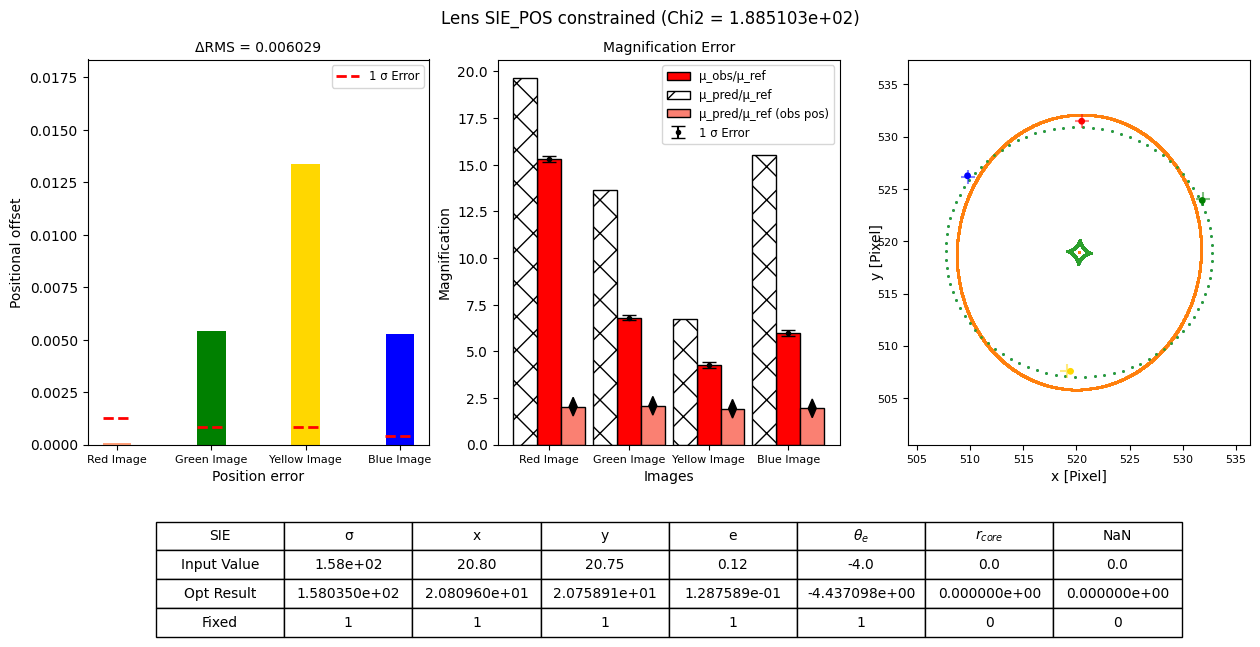

In [8]:
plot_name_1 = 'SIE_POS'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point_SIE(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [5]:
%run SIE/pos_flux_point.py

amoeba_delta = 3.333605e-02



######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 5.226794e+03  tol = 4.746274e-01
amoeba:  n =     2  y = 4.465406e+03  tol = 3.342274e-01
amoeba:  n =     3  y = 4.107591e+03  tol = 4.092974e-01
amoeba:  n =     4  y = 4.107591e+03  tol = 4.035138e-01
amoeba:  n =     5  y = 4.107591e+03  tol = 3.584367e-01
amoeba:  n =     6  y = 4.107591e+03  tol = 2.398023e-01
amoeba:  n =     7  y = 4.107591e+03  tol = 1.622444e-01
amoeba:  n =     8  y = 4.107591e+03  tol = 8.428059e-02
amoeba:  n =     9  y = 4.107591e+03  tol = 8.347492e-02
amoeba:  n =    10  y = 4.047514e+03  tol = 9.139759e-02
amoeba:  n =    11  y = 4.047514e+03  tol = 6.879629e-02
amoeba:  n =    12  y = 3.993874e+03  tol = 4.453975e-02
amoeba:  n =    13  y = 3.993874e+03  tol = 2.895662e-02
amoeba:  n =    14  y = 3.983771e+03  tol = 3.060526e-02
amoeba:  n =    15  y = 3.983760e+03  tol = 1.741204e-02
amoeba:  n =    16  y = 3.983048e+03  tol = 1.605493e-02
amo

amoeba_delta = 1.709933e-02

amoeba_delta = 1.598181e-02

n_img = 4
x =   20.7645   y =   20.3038   mag =   -6.8117 [  -2.083]   td[day] =     1.032
x =   21.2761   y =   20.9602   mag =   13.8040 [  -2.850]   td[day] =     0.000
x =   20.3934   y =   21.0455   mag =   15.6863 [  -2.989]   td[day] =     0.055
x =   20.8199   y =   21.2594   mag =  -19.8732 [  -3.246]   td[day] =     0.167


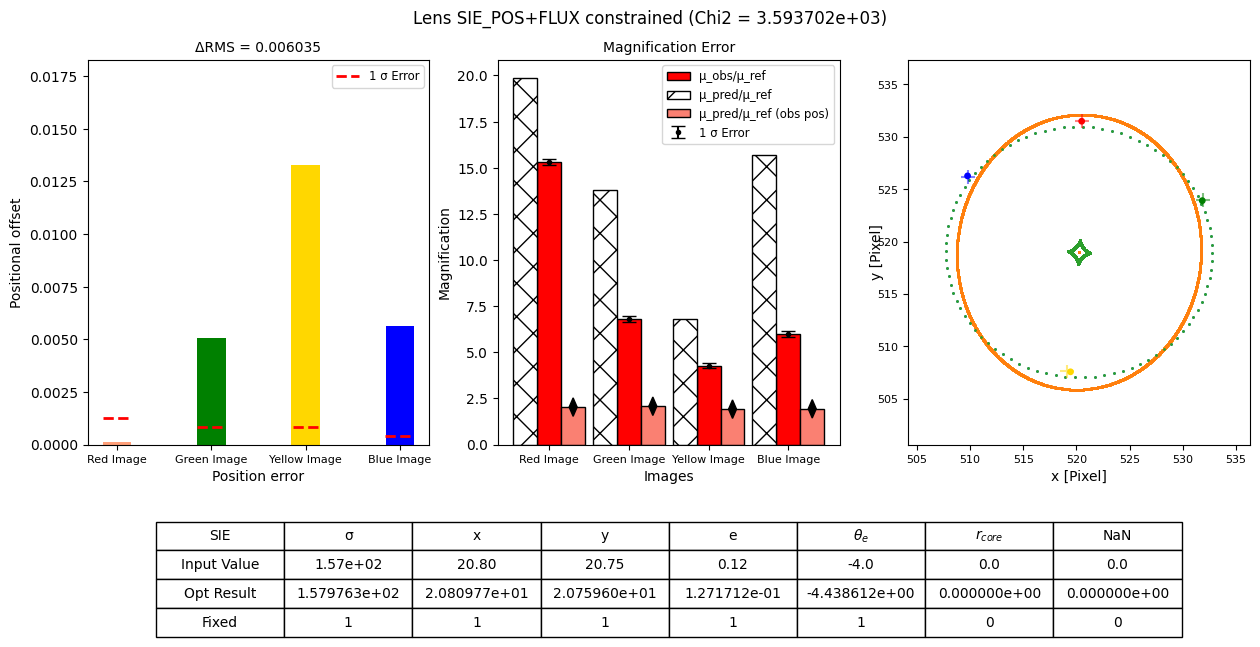

In [6]:
plot_name_1 = 'SIE_POS+FLUX'
loc = 'SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [11]:
# POW Lens Model
%run POW/pos_point.py

amoeba_delta = 1.599429e-02

amoeba_delta = 1.589004e-02

amoeba_delta = 1.587377e-02

n_img = 4
x =   20.7645   y =   20.3033   mag =   -7.4202 [  -2.176]   td[day] =     0.987
x =   21.2761   y =   20.9607   mag =   14.9753 [  -2.938]   td[day] =     0.000
x =   20.3932   y =   21.0460   mag =   17.0157 [  -3.077]   td[day] =     0.052
x =   20.8199   y =   21.2593   mag =  -21.7270 [  -3.343]   td[day] =     0.158


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.930365e+02  tol = 2.391249e-01
amoeba:  n =     2  y = 1.930365e+02  tol = 6.126928e-02
amoeba:  n =     3  y = 1.930365e+02  tol = 2.400052e-02
amoeba:  n =     4  y = 1.930365e+02  tol = 2.277114e-02
amoeba:  n =     5  y = 1.930365e+02  tol = 1.898646e-02
amoeba:  n =     6  y = 1.930365e+02  tol = 1.564490e-02
amoeba:  n =     7  y = 1.930365e+02  tol = 1.228520e-02
amoeba:  n =     8  y = 1.930365e+02  tol = 1.120850e-02
amoeba:  n =     9  y = 1.930365e+02  tol = 8.253795e-03
amoeba:  n =    10  y = 1.927158e+02  tol = 8.223833e-03
amoeba:  n =    11  y = 1.926385e+02  tol = 8.127272e-03
amoeba:  n =    12  y = 1.923662e+02  tol = 9.044681e-03
amoeba:  n =    13  y = 1.914995e+02  tol = 1.128010e-02
amoeba:  n =    14  y = 1.914995e+02  tol = 8.394711e-03
amoeba:  n =    15  y = 1.914995e+02  tol = 7.994460e-03
amoeba:  n =    16  y = 1.904156e+02  tol = 1.200712e-02
amo

 writing critical curve
 zs = 1.000000e+00 
 output file name = POW/POW_POS_crit.dat 

######## writing lens properties
 zs = 1.000000e+00 
 output file name = POW/POW_POS_lens.fits 



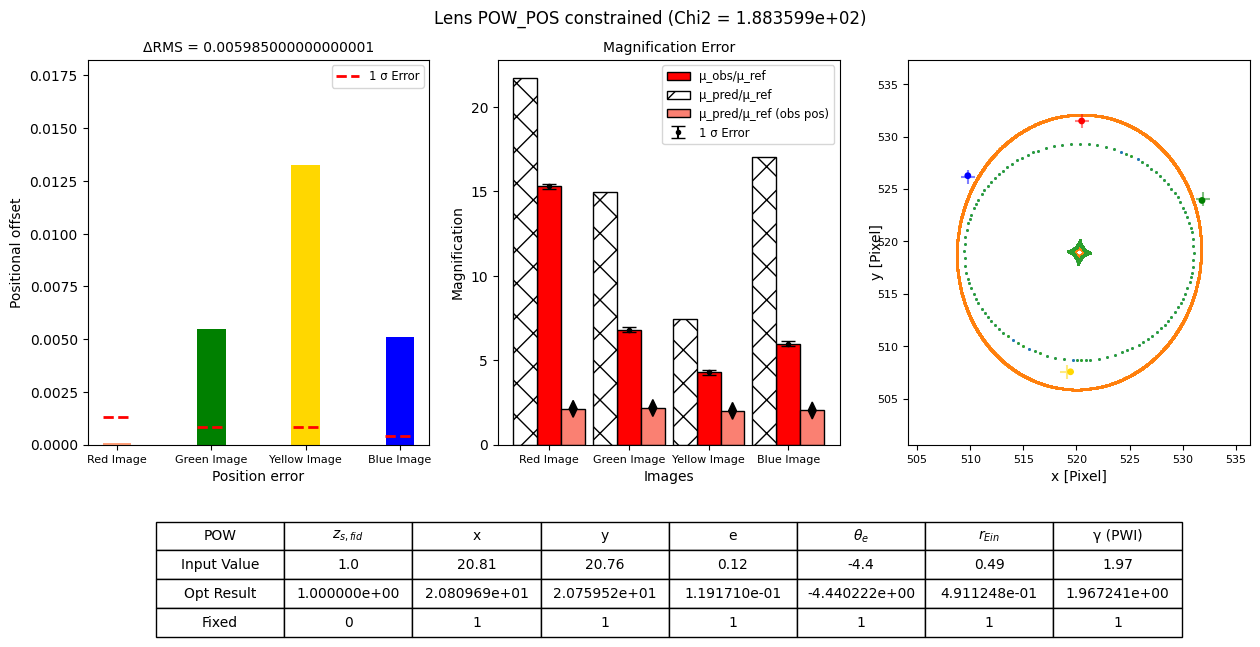

In [12]:
plot_name_1 = 'POW_POS'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [15]:
# POW Lens Model
%run POW/pos_flux_point.py

######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 3.617088e+03  tol = 2.343935e-02
amoeba:  n =     2  y = 3.617088e+03  tol = 1.524572e-02
amoeba:  n =     3  y = 3.610342e+03  tol = 1.082591e-02
amoeba:  n =     4  y = 3.610342e+03  tol = 6.356830e-03
amoeba:  n =     5  y = 3.610342e+03  tol = 6.181350e-03
amoeba:  n =     6  y = 3.610342e+03  tol = 6.030446e-03
amoeba:  n =     7  y = 3.604471e+03  tol = 7.615541e-03
amoeba:  n =     8  y = 3.604471e+03  tol = 5.706256e-03
amoeba:  n =     9  y = 3.604471e+03  tol = 3.494136e-03
amoeba:  n =    10  y = 3.604471e+03  tol = 2.878017e-03
amoeba:  n =    11  y = 3.604471e+03  tol = 1.679923e-03
amoeba:  n =    12  y = 3.604471e+03  tol = 1.670146e-03
amoeba:  n =    13  y = 3.604471e+03  tol = 1.627488e-03
amoeba:  n =    14  y = 3.604471e+03  tol = 1.192520e-03
amoeba:  n =    15  y = 3.602347e+03  tol = 1.536680e-03
amoeba:  n =    16  y = 3.602347e+03  tol = 1.527509e-03
amo

amoeba_delta = 1.823183e-02

amoeba_delta = 1.595910e-02

amoeba_delta = 1.596898e-02

n_img = 4
x =   20.7645   y =   20.3038   mag =   -7.6477 [  -2.209]   td[day] =     0.963
x =   21.2761   y =   20.9603   mag =   15.3456 [  -2.965]   td[day] =     0.000
x =   20.3932   y =   21.0455   mag =   17.4378 [  -3.104]   td[day] =     0.051
x =   20.8199   y =   21.2595   mag =  -22.2857 [  -3.370]   td[day] =     0.155


7e+03  tol = 1.251292e-03
amoeba:  n =    19  y = 3.602347e+03  tol = 1.035963e-03
amoeba:  n =    20  y = 3.600303e+03  tol = 1.339556e-03
amoeba:  n =    21  y = 3.600303e+03  tol = 1.188927e-03
amoeba:  n =    22  y = 3.600303e+03  tol = 1.184097e-03
amoeba:  n =    23  y = 3.600303e+03  tol = 1.156978e-03
amoeba:  n =    24  y = 3.600303e+03  tol = 1.083180e-03
amoeba:  n =    25  y = 3.600057e+03  tol = 6.853416e-04
amoeba:  n =    26  y = 3.600057e+03  tol = 6.360001e-04
amoeba:  n =    27  y = 3.598008e+03  tol = 8.886001e-04
amoeba:  n =    28  y = 3.598008e+03  tol = 7.154160e-04
amoeba:  n =    29  y = 3.598008e+03  tol = 6.815350e-04
amoeba:  n =    30  y = 3.598008e+03  tol = 6.377258e-04
amoeba:  n =    31  y = 3.598008e+03  tol = 5.704137e-04
amoeba:  n =    32  y = 3.596749e+03  tol = 9.192052e-04
amoeba:  n =    33  y = 3.596749e+03  tol = 6.445876e-04
amoeba:  n =    34  y = 3.596749e+03  tol = 6.037389e-04
amoeba:  n =    35  y = 3.596749e+03  tol = 5.755518e-04
amoeb

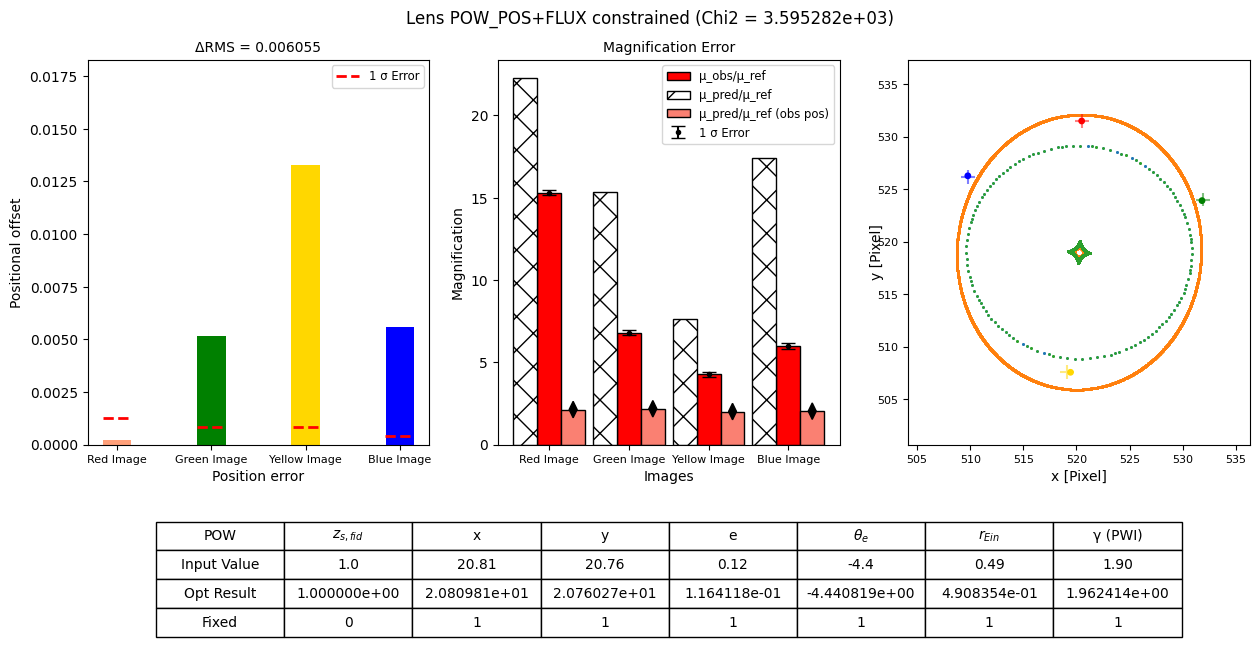

In [16]:
plot_name_1 = 'POW_POS+FLUX'
loc = 'POW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [17]:
# NFW Lens Model
%run NFW/pos_point.py

amoeba_delta = 3.983117e-02

amoeba_delta = 1.591793e-02

amoeba_delta = 1.588934e-02

n_img = 5
x =   20.7645   y =   20.3033   mag =   -5.3701 [  -1.825]   td[day] =     1.308
x =   20.8085   y =   20.7506   mag =    0.0124 [   4.767]   td[day] =     3.952
x =   21.2761   y =   20.9607   mag =   10.8111 [  -2.585]   td[day] =     0.000
x =   20.3932   y =   21.0459   mag =   12.2818 [  -2.723]   td[day] =     0.070
x =   20.8199   y =   21.2593   mag =  -15.4850 [  -2.975]   td[day] =     0.210


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.428215e+03  tol = 1.189034e+00
amoeba:  n =     2  y = 1.428215e+03  tol = 8.158583e-01
amoeba:  n =     3  y = 1.428215e+03  tol = 8.157308e-01
amoeba:  n =     4  y = 5.196386e+02  tol = 1.464492e+00
amoeba:  n =     5  y = 5.196386e+02  tol = 1.456015e+00
amoeba:  n =     6  y = 4.149585e+02  tol = 1.505072e+00
amoeba:  n =     7  y = 4.149585e+02  tol = 1.386586e+00
amoeba:  n =     8  y = 4.149585e+02  tol = 1.121320e+00
amoeba:  n =     9  y = 4.149585e+02  tol = 1.099470e+00
amoeba:  n =    10  y = 4.149585e+02  tol = 1.059741e+00
amoeba:  n =    11  y = 4.149585e+02  tol = 1.045053e+00
amoeba:  n =    12  y = 4.149585e+02  tol = 8.123035e-01
amoeba:  n =    13  y = 4.149585e+02  tol = 6.633445e-01
amoeba:  n =    14  y = 4.149585e+02  tol = 4.926718e-01
amoeba:  n =    15  y = 4.149585e+02  tol = 3.611960e-01
amoeba:  n =    16  y = 4.149585e+02  tol = 2.818890e-01
amo

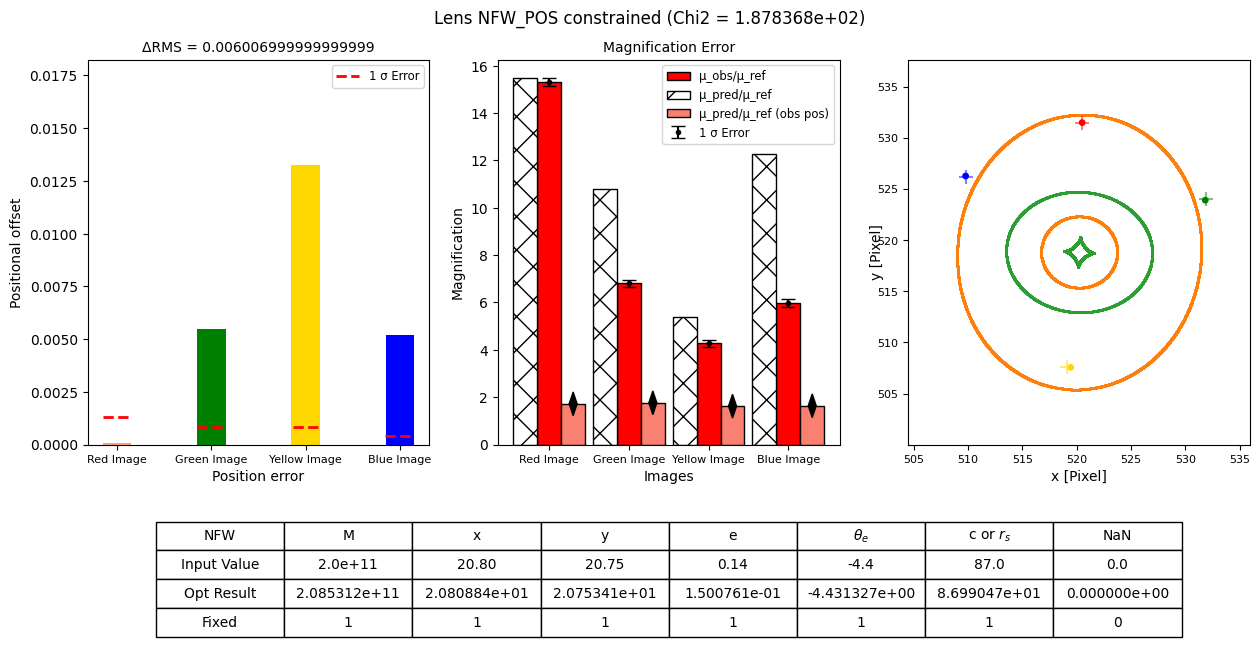

In [18]:
plot_name_1 = 'NFW_POS'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [19]:
# NFW Lens Model
%run NFW/pos_flux_point.py

amoeba_delta = 2.863837e-02

amoeba_delta = 1.654642e-02

amoeba_delta = 1.594353e-02

n_img = 5
x =   20.7646   y =   20.3040   mag =   -5.6171 [  -1.874]   td[day] =     1.266
x =   20.8087   y =   20.7516   mag =    0.0131 [   4.710]   td[day] =     3.874
x =   21.2762   y =   20.9603   mag =   11.2151 [  -2.625]   td[day] =     0.000
x =   20.3931   y =   21.0455   mag =   12.7460 [  -2.763]   td[day] =     0.068
x =   20.8199   y =   21.2595   mag =  -16.1138 [  -3.018]   td[day] =     0.205


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 4.595462e+03  tol = 2.401903e-01
amoeba:  n =     2  y = 3.864272e+03  tol = 2.919992e-01
amoeba:  n =     3  y = 3.864272e+03  tol = 2.146328e-01
amoeba:  n =     4  y = 3.864272e+03  tol = 2.145902e-01
amoeba:  n =     5  y = 3.864272e+03  tol = 2.096351e-01
amoeba:  n =     6  y = 3.864272e+03  tol = 2.067340e-01
amoeba:  n =     7  y = 3.864272e+03  tol = 1.804107e-01
amoeba:  n =     8  y = 3.864272e+03  tol = 1.728635e-01
amoeba:  n =     9  y = 3.864272e+03  tol = 6.489421e-02
amoeba:  n =    10  y = 3.864272e+03  tol = 3.356271e-02
amoeba:  n =    11  y = 3.864272e+03  tol = 1.666071e-02
amoeba:  n =    12  y = 3.860168e+03  tol = 1.288102e-02
amoeba:  n =    13  y = 3.860168e+03  tol = 1.215923e-02
amoeba:  n =    14  y = 3.847596e+03  tol = 1.423581e-02
amoeba:  n =    15  y = 3.847596e+03  tol = 9.873506e-03
amoeba:  n =    16  y = 3.838856e+03  tol = 6.948249e-03
amo

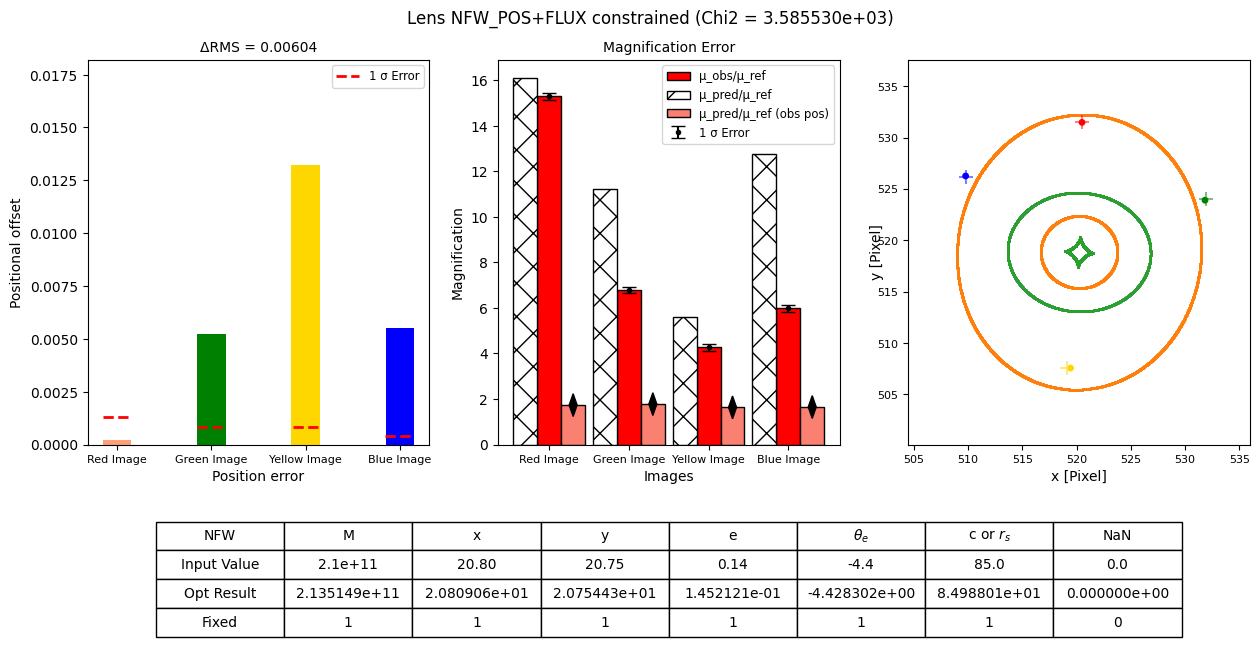

In [20]:
plot_name_1 = 'NFW_POS+FLUX'
loc = 'NFW/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [21]:
# Core SIE
%run C_SIE/pos_point.py

######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.565463e+03  tol = 1.550122e+00
amoeba:  n =     2  y = 1.565463e+03  tol = 1.387391e+00
amoeba:  n =     3  y = 1.565463e+03  tol = 1.365679e+00
amoeba:  n =     4  y = 6.565243e+02  tol = 1.705270e+00
amoeba:  n =     5  y = 6.565243e+02  tol = 1.699211e+00
amoeba:  n =     6  y = 6.565243e+02  tol = 1.662359e+00
amoeba:  n =     7  y = 6.565243e+02  tol = 1.511087e+00
amoeba:  n =     8  y = 6.565243e+02  tol = 1.135620e+00
amoeba:  n =     9  y = 6.565243e+02  tol = 1.030309e+00
amoeba:  n =    10  y = 6.565243e+02  tol = 1.002952e+00
amoeba:  n =    11  y = 6.565243e+02  tol = 9.849800e-01
amoeba:  n =    12  y = 6.565243e+02  tol = 9.017056e-01
amoeba:  n =    13  y = 6.565243e+02  tol = 8.181315e-01
amoeba:  n =    14  y = 6.350098e+02  tol = 7.756728e-01
amoeba:  n =    15  y = 6.350098e+02  tol = 7.338952e-01
amoeba:  n =    16  y = 6.350098e+02  tol = 1.281645e-01
amo

amoeba_delta = 5.751973e-02

amoeba_delta = 1.583827e-02

n_img = 5
x =   20.7645   y =   20.3033   mag =   -8.7257 [  -2.352]   td[day] =     0.921
x =   20.8091   y =   20.7546   mag =    0.0527 [   3.196]   td[day] =     3.535
x =   21.2761   y =   20.9607   mag =   17.2450 [  -3.092]   td[day] =     0.000
x =   20.3933   y =   21.0459   mag =   19.6104 [  -3.231]   td[day] =     0.048
x =   20.8199   y =   21.2593   mag =  -25.3724 [  -3.511]   td[day] =     0.146


a:  n =    36  y = 4.866965e+02  tol = 9.834054e-03
amoeba:  n =    37  y = 4.861442e+02  tol = 1.019333e-02
amoeba:  n =    38  y = 4.861442e+02  tol = 9.185323e-03
amoeba:  n =    39  y = 4.861442e+02  tol = 7.349346e-03
amoeba:  n =    40  y = 4.861442e+02  tol = 5.649685e-03
amoeba:  n =    41  y = 4.814489e+02  tol = 1.320174e-02
amoeba:  n =    42  y = 4.814489e+02  tol = 1.124643e-02
amoeba:  n =    43  y = 4.814489e+02  tol = 1.089272e-02
amoeba:  n =    44  y = 4.814489e+02  tol = 1.084054e-02
amoeba:  n =    45  y = 4.814489e+02  tol = 9.801491e-03
amoeba:  n =    46  y = 4.775331e+02  tol = 1.787129e-02
amoeba:  n =    47  y = 4.705630e+02  tol = 2.879972e-02
amoeba:  n =    48  y = 4.705630e+02  tol = 2.770995e-02
amoeba:  n =    49  y = 4.705630e+02  tol = 2.400164e-02
amoeba:  n =    50  y = 4.656412e+02  tol = 3.450265e-02
amoeba:  n =    51  y = 4.656412e+02  tol = 3.338157e-02
amoeba:  n =    52  y = 4.538097e+02  tol = 5.094468e-02
amoeba:  n =    53  y = 4.538097e+02


amoeba:  n =   194  y = 2.046691e+02  tol = 5.644959e-02
amoeba:  n =   195  y = 2.046691e+02  tol = 3.850524e-02
amoeba:  n =   196  y = 2.012088e+02  tol = 5.192534e-02
amoeba:  n =   197  y = 2.012088e+02  tol = 4.461318e-02
amoeba:  n =   198  y = 1.994299e+02  tol = 3.526193e-02
amoeba:  n =   199  y = 1.994299e+02  tol = 3.085018e-02
amoeba:  n =   200  y = 1.994299e+02  tol = 2.950266e-02
amoeba:  n =   201  y = 1.994299e+02  tol = 2.658972e-02
amoeba:  n =   202  y = 1.994299e+02  tol = 2.593030e-02
amoeba:  n =   203  y = 1.953364e+02  tol = 4.119077e-02
amoeba:  n =   204  y = 1.953364e+02  tol = 3.570491e-02
amoeba:  n =   205  y = 1.953364e+02  tol = 3.366466e-02
amoeba:  n =   206  y = 1.953364e+02  tol = 2.961778e-02
amoeba:  n =   207  y = 1.916597e+02  tol = 4.810491e-02
amoeba:  n =   208  y = 1.916597e+02  tol = 3.973634e-02
amoeba:  n =   209  y = 1.916597e+02  tol = 3.784242e-02
amoeba:  n =   210  y = 1.916597e+02  tol = 3.766055e-02
amoeba:  n =   211  y = 1.9165

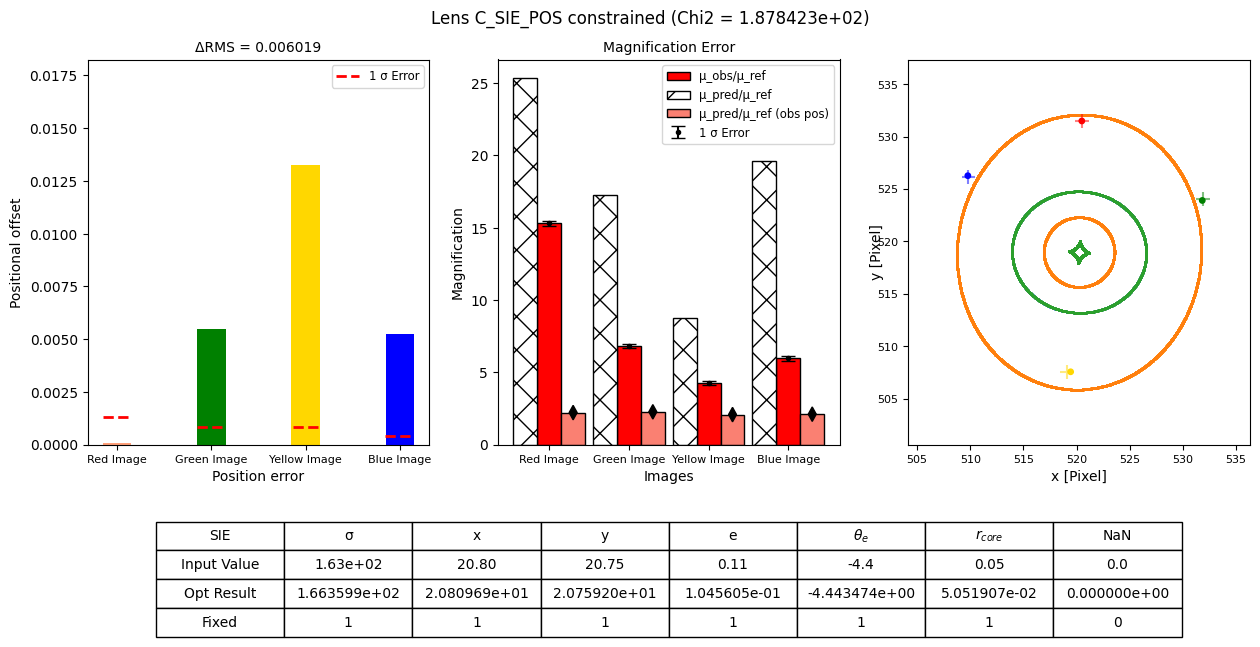

In [22]:
plot_name_1 = 'C_SIE_POS'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [23]:
%run C_SIE/pos_flux_point.py

amoeba_delta = 5.299273e-02



######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 4.844606e+03  tol = 9.841571e-01
amoeba:  n =     2  y = 4.844606e+03  tol = 7.761714e-01
amoeba:  n =     3  y = 4.844606e+03  tol = 7.537557e-01
amoeba:  n =     4  y = 3.983906e+03  tol = 9.114998e-01
amoeba:  n =     5  y = 3.983906e+03  tol = 8.998029e-01
amoeba:  n =     6  y = 3.983906e+03  tol = 8.345280e-01
amoeba:  n =     7  y = 3.983906e+03  tol = 6.317802e-01
amoeba:  n =     8  y = 3.983906e+03  tol = 2.906995e-01
amoeba:  n =     9  y = 3.983906e+03  tol = 2.473496e-01
amoeba:  n =    10  y = 3.983906e+03  tol = 2.128243e-01
amoeba:  n =    11  y = 3.983906e+03  tol = 2.031371e-01
amoeba:  n =    12  y = 3.983906e+03  tol = 1.949818e-01
amoeba:  n =    13  y = 3.983906e+03  tol = 1.822219e-01
amoeba:  n =    14  y = 3.983906e+03  tol = 1.651907e-01
amoeba:  n =    15  y = 3.983906e+03  tol = 3.999238e-02
amoeba:  n =    16  y = 3.983906e+03  tol = 3.889944e-02
amo

amoeba_delta = 1.597567e-02

n_img = 5
x =   20.7647   y =   20.3042   mag =   -7.6369 [  -2.207]   td[day] =     0.978
x =   20.8095   y =   20.7576   mag =    0.0108 [   4.920]   td[day] =     4.270
x =   21.2760   y =   20.9603   mag =   15.2768 [  -2.960]   td[day] =     0.000
x =   20.3933   y =   21.0453   mag =   17.3626 [  -3.099]   td[day] =     0.052
x =   20.8199   y =   21.2595   mag =  -22.2068 [  -3.366]   td[day] =     0.157


  88  y = 3.745476e+03  tol = 1.236613e-02
amoeba:  n =    89  y = 3.728117e+03  tol = 1.426827e-02
amoeba:  n =    90  y = 3.727199e+03  tol = 1.399847e-02
amoeba:  n =    91  y = 3.718420e+03  tol = 1.246073e-02
amoeba:  n =    92  y = 3.708914e+03  tol = 1.381352e-02
amoeba:  n =    93  y = 3.708914e+03  tol = 1.106841e-02
amoeba:  n =    94  y = 3.697347e+03  tol = 1.293315e-02
amoeba:  n =    95  y = 3.697347e+03  tol = 8.287785e-03
amoeba:  n =    96  y = 3.697347e+03  tol = 8.041462e-03
amoeba:  n =    97  y = 3.697347e+03  tol = 7.259084e-03
amoeba:  n =    98  y = 3.697347e+03  tol = 6.562618e-03
amoeba:  n =    99  y = 3.696909e+03  tol = 5.801623e-03
amoeba:  n =   100  y = 3.696909e+03  tol = 4.042010e-03
amoeba:  n =   101  y = 3.691697e+03  tol = 4.653015e-03
amoeba:  n =   102  y = 3.691697e+03  tol = 4.277438e-03
amoeba:  n =   103  y = 3.691697e+03  tol = 2.568581e-03
amoeba:  n =   104  y = 3.691697e+03  tol = 1.751208e-03
amoeba:  n =   105  y = 3.691697e+03  tol = 1

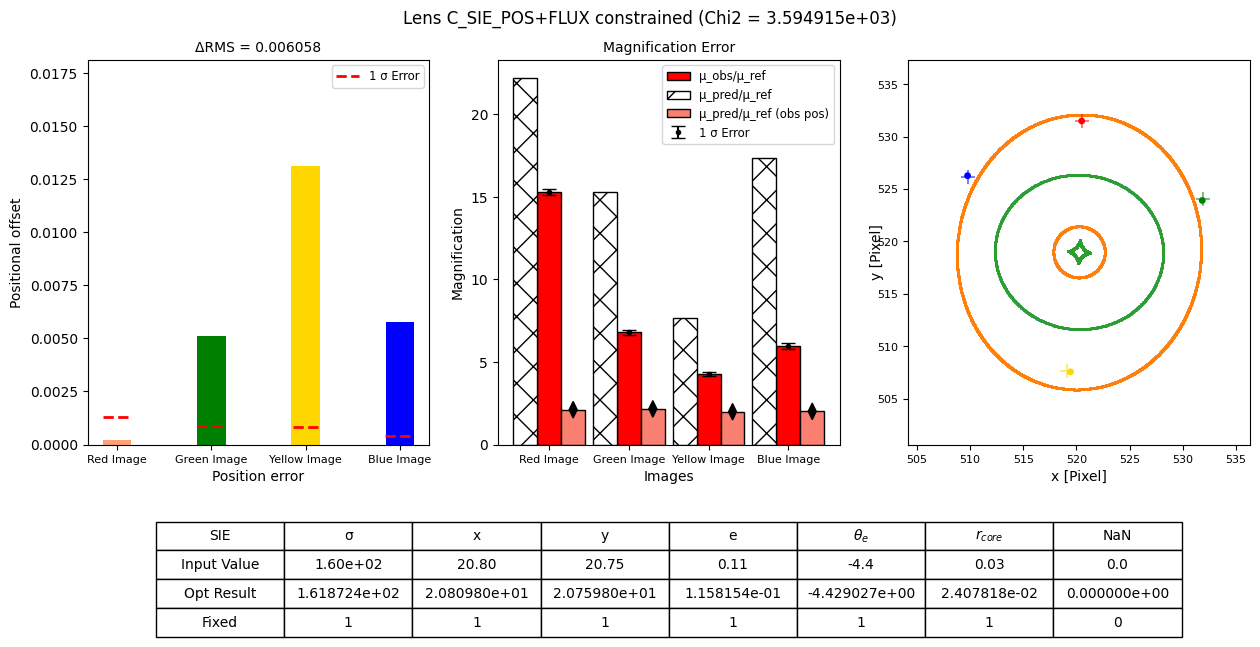

In [24]:
plot_name_1 = 'C_SIE_POS+FLUX'
loc = 'C_SIE/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# EIN + POS
%run EIN/pos_point.py

amoeba_delta = 2.311507e-02

amoeba_delta = 1.582680e-02

n_img = 5
x =   20.7646   y =   20.3033   mag =   -3.6967 [  -1.420]   td[day] =     1.875
x =   20.8046   y =   20.7204   mag =    0.2446 [   1.529]   td[day] =     3.454
x =   21.2761   y =   20.9607   mag =    7.1841 [  -2.141]   td[day] =     0.000
x =   20.3931   y =   21.0460   mag =    8.1643 [  -2.280]   td[day] =     0.100
x =   20.8199   y =   21.2593   mag =  -10.1541 [  -2.517]   td[day] =     0.302


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

 making tables for ein... [99 x 801 = 79299 points]

amoeba:  n =     1  y = 4.308574e+02  tol = 5.023980e-01
amoeba:  n =     2  y = 3.981553e+02  tol = 4.801137e-01
amoeba:  n =     3  y = 3.981553e+02  tol = 1.452332e-01
amoeba:  n =     4  y = 3.550091e+02  tol = 2.586102e-01
amoeba:  n =     5  y = 3.549826e+02  tol = 2.481596e-01
amoeba:  n =     6  y = 3.549826e+02  tol = 2.247950e-01
amoeba:  n =     7  y = 3.549826e+02  tol = 1.931051e-01
amoeba:  n =     8  y = 3.549826e+02  tol = 1.383790e-01
amoeba:  n =     9  y = 3.549826e+02  tol = 1.146477e-01
amoeba:  n =    10  y = 3.549826e+02  tol = 7.672529e-02
amoeba:  n =    11  y = 3.549826e+02  tol = 4.206818e-02
amoeba:  n =    12  y = 3.536884e+02  tol = 3.143602e-02
amoeba:  n =    13  y = 3.523432e+02  tol = 3.104029e-02
amoeba:  n =    14  y = 3.479969e+02  tol = 2.669699e-02
amoeba:  n =    15  y = 3.479969e+02  tol = 2.228198e-02
amoeba:

+02  tol = 1.002859e-02
amoeba:  n =   193  y = 1.860631e+02  tol = 8.835284e-03
amoeba:  n =   194  y = 1.860631e+02  tol = 7.455923e-03
amoeba:  n =   195  y = 1.860631e+02  tol = 4.526108e-03
amoeba:  n =   196  y = 1.860631e+02  tol = 4.433013e-03
amoeba:  n =   197  y = 1.860631e+02  tol = 3.669340e-03
amoeba:  n =   198  y = 1.858102e+02  tol = 4.426642e-03
amoeba:  n =   199  y = 1.858102e+02  tol = 3.350382e-03
amoeba:  n =   200  y = 1.858102e+02  tol = 3.324234e-03
amoeba:  n =   201  y = 1.858102e+02  tol = 2.860695e-03
amoeba:  n =   202  y = 1.858102e+02  tol = 2.761661e-03
amoeba:  n =   203  y = 1.858102e+02  tol = 2.342376e-03
amoeba:  n =   204  y = 1.858102e+02  tol = 2.163958e-03
amoeba:  n =   205  y = 1.858102e+02  tol = 1.359995e-03
amoeba:  n =   206  y = 1.858102e+02  tol = 1.066041e-03
amoeba:  n =   207  y = 1.858102e+02  tol = 9.988991e-04
amoeba:  n =   208  y = 1.858102e+02  tol = 4.693407e-04
amoeba:  n =   209  y = 1.857838e+02  tol = 5.551385e-04
amoeba:

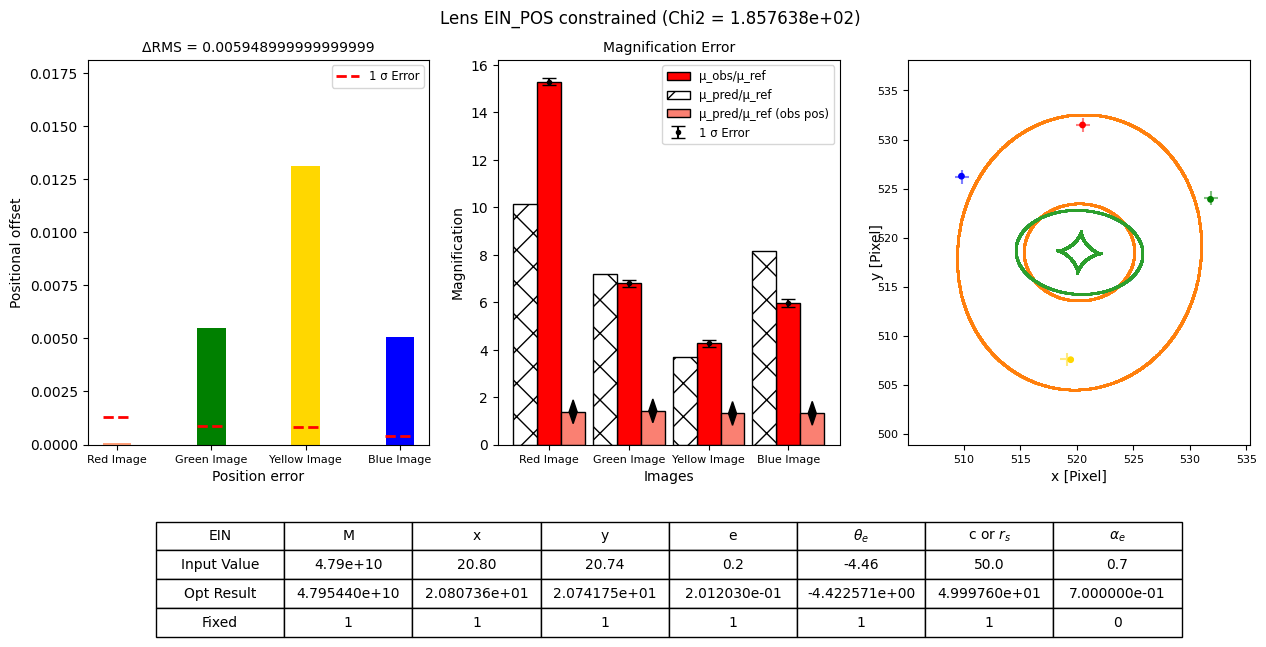

In [4]:
plot_name_1 = 'EIN_POS'
loc = 'EIN/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# EIN + POS
%run EIN/pos_flux_point.py 

######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 3.914100e+03  tol = 8.966713e-02
amoeba:  n =     2  y = 3.877094e+03  tol = 6.115438e-02
amoeba:  n =     3  y = 3.876686e+03  tol = 2.210359e-02
amoeba:  n =     4  y = 3.813623e+03  tol = 3.847956e-02
amoeba:  n =     5  y = 3.813579e+03  tol = 3.679237e-02
amoeba:  n =     6  y = 3.813579e+03  tol = 3.362189e-02
amoeba:  n =     7  y = 3.813579e+03  tol = 2.601587e-02
amoeba:  n =     8  y = 3.813579e+03  tol = 1.651755e-02
amoeba:  n =     9  y = 3.813579e+03  tol = 1.641222e-02
amoeba:  n =    10  y = 3.813579e+03  tol = 1.317457e-02
amoeba:  n =    11  y = 3.813508e+03  tol = 8.356921e-03
amoeba:  n =    12  y = 3.813508e+03  tol = 6.384703e-03
amoeba:  n =    13  y = 3.811873e+03  tol = 5.874048e-03
amoeba:  n =    14  y = 3.811873e+03  tol = 5.604354e-03
amoeba:  n =    15  y = 3.810660e+03  tol = 3.605458e-03
amoeba:  n =    16  y = 3.809885e+03  tol = 1.615922e-03
amo

amoeba_delta = 2.461377e-02

amoeba_delta = 1.601904e-02

n_img = 5
x =   20.7643   y =   20.3039   mag =   -5.5530 [  -1.861]   td[day] =     1.358
x =   20.8068   y =   20.7392   mag =    0.1621 [   1.976]   td[day] =     3.188
x =   21.2760   y =   20.9604   mag =   10.6319 [  -2.567]   td[day] =     0.000
x =   20.3928   y =   21.0457   mag =   12.0940 [  -2.706]   td[day] =     0.072
x =   20.8199   y =   21.2594   mag =  -15.5119 [  -2.977]   td[day] =     0.218


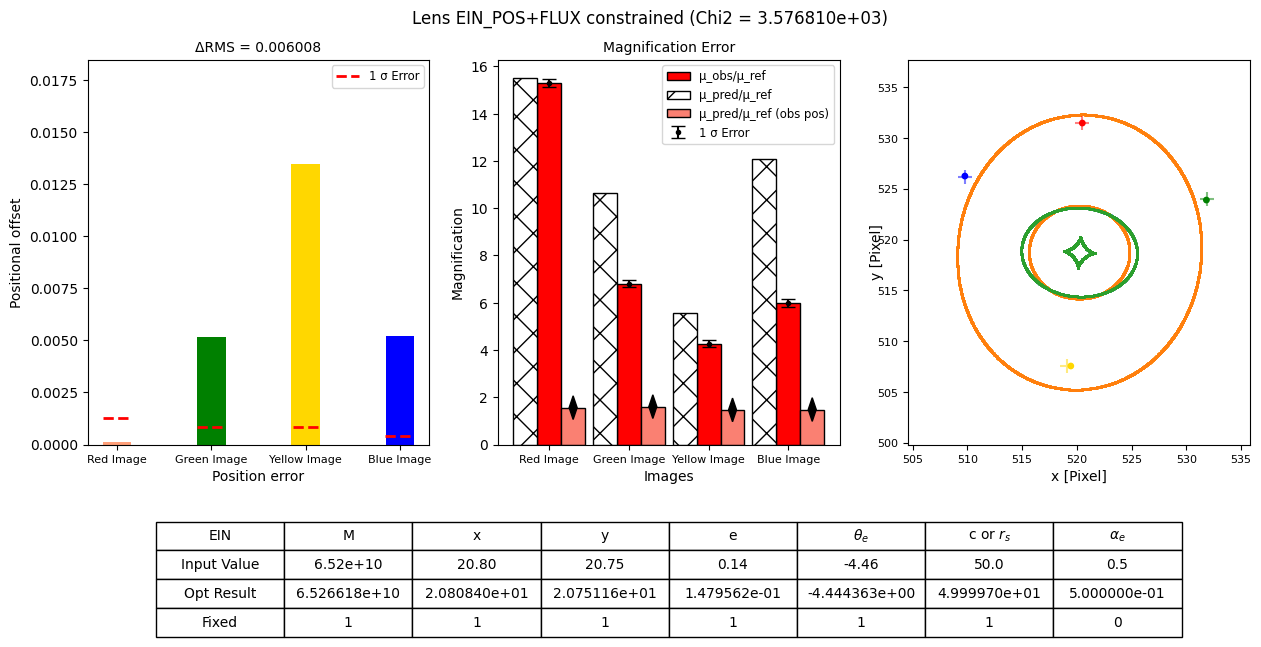

In [6]:
plot_name_1 = 'EIN_POS+FLUX'
loc = 'EIN/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# SIE + SHEAR
%run SIE+SHEAR/pos_point.py

amoeba_delta = 9.043641e-01

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7777   y =   20.3025   mag =  -16.6728 [  -3.055]   td[day] =     0.598
x =   21.2731   y =   20.9561   mag =   34.1253 [  -3.833]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   35.7335 [  -3.883]   td[day] =     0.021
x =   20.8198   y =   21.2593   mag =  -49.7776 [  -4.243]   td[day] =     0.087


######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 6.323365e+04  tol = 2.000000e+00
amoeba:  n =     2  y = 2.834375e+04  tol = 2.000000e+00
amoeba:  n =     3  y = 2.834375e+04  tol = 1.962805e+00
amoeba:  n =     4  y = 2.834375e+04  tol = 1.759898e+00
amoeba:  n =     5  y = 2.834375e+04  tol = 1.554225e+00
amoeba:  n =     6  y = 2.834375e+04  tol = 1.461804e+00
amoeba:  n =     7  y = 2.834375e+04  tol = 1.176279e+00
amoeba:  n =     8  y = 2.834375e+04  tol = 1.101928e+00
amoeba:  n =     9  y = 2.834375e+04  tol = 8.768094e-01
amoeba:  n =    10  y = 2.643442e+04  tol = 8.207878e-01
amoeba:  n =    11  y = 2.098838e+04  tol = 9.282665e-01
amoeba:  n =    12  y = 1.993405e+04  tol = 7.386546e-01
amoeba:  n =    13  y = 1.795383e+04  tol = 7.370964e-01
amoeba:  n =    14  y = 7.993892e+03  tol = 1.263313e+00
amoeba:  n =    15  y = 7.326739e+03  tol = 1.206449e+00
amoeba:  n =    16  y = 7.326739e+03  tol = 1.191882e+00
am

4948e-01
amoeba:  n =   527  y = 1.325567e-01  tol = 7.108205e-01
amoeba:  n =   528  y = 1.325567e-01  tol = 6.767140e-01
amoeba:  n =   529  y = 1.210101e-01  tol = 7.284638e-01
amoeba:  n =   530  y = 1.210101e-01  tol = 6.868102e-01
amoeba:  n =   531  y = 1.210101e-01  tol = 6.744427e-01
amoeba:  n =   532  y = 8.542573e-02  tol = 9.321395e-01
amoeba:  n =   533  y = 8.542573e-02  tol = 9.080523e-01
amoeba:  n =   534  y = 8.542573e-02  tol = 8.852862e-01
amoeba:  n =   535  y = 8.542573e-02  tol = 7.712292e-01
amoeba:  n =   536  y = 8.542573e-02  tol = 7.270500e-01
amoeba:  n =   537  y = 8.542573e-02  tol = 6.871848e-01
amoeba:  n =   538  y = 6.042181e-02  tol = 9.315135e-01
amoeba:  n =   539  y = 6.042181e-02  tol = 9.175294e-01
amoeba:  n =   540  y = 6.042181e-02  tol = 8.308368e-01
amoeba:  n =   541  y = 3.438002e-02  tol = 1.221550e+00
amoeba:  n =   542  y = 3.438002e-02  tol = 1.176215e+00
amoeba:  n =   543  y = 3.438002e-02  tol = 1.122162e+00
amoeba:  n =   544  y 

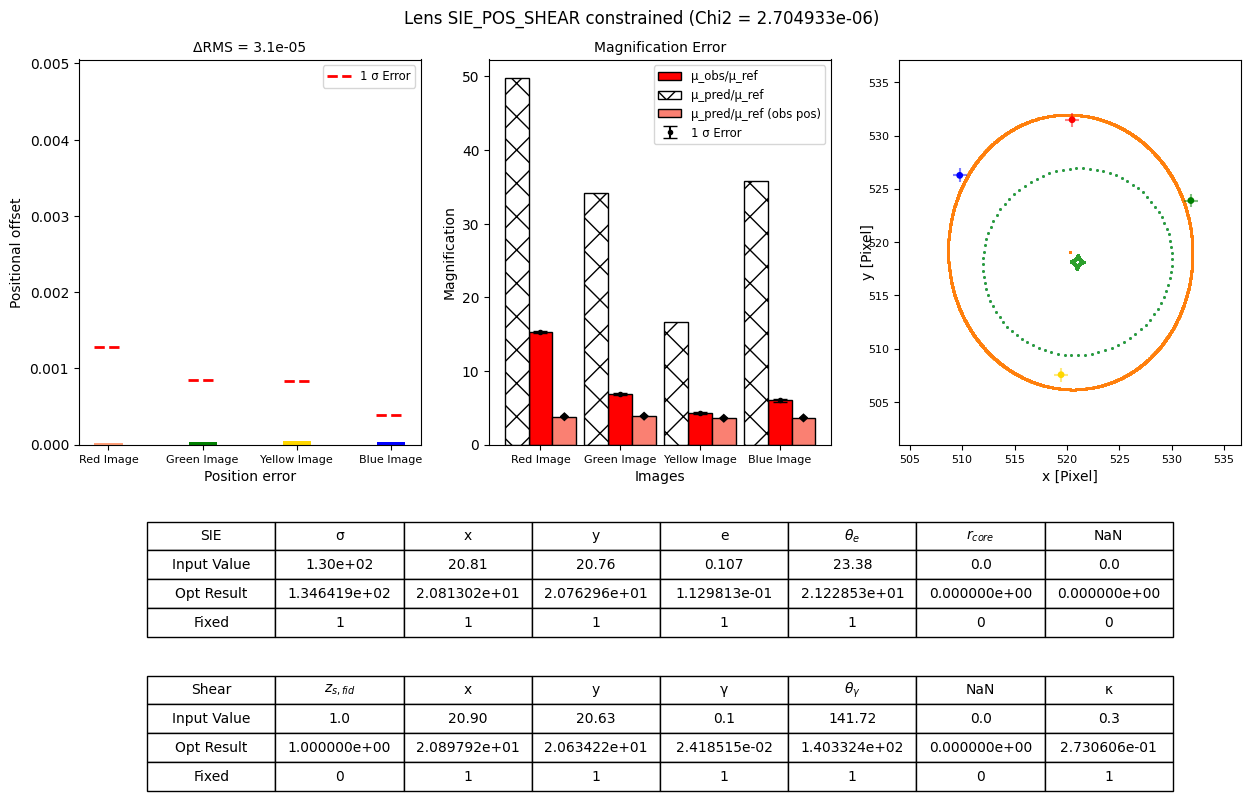

In [8]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'SIE+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# SIE + SHEAR
%run SIE+SHEAR/pos_flux_point.py

######## optimizing lens
 number of parameters = 10 (lens) 

amoeba_delta = 9.633607e-01

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7777   y =   20.3022   mag =   -8.1910 [  -2.283]   td[day] =     1.117
x =   21.2727   y =   20.9554   mag =   19.2839 [  -3.213]   td[day] =     0.000
x =   20.3908   y =   21.0503   mag =   19.2205 [  -3.209]   td[day] =     0.038
x =   20.8199   y =   21.2594   mag =  -23.5887 [  -3.432]   td[day] =     0.178


+ 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 8.114679e+04  tol = 2.000000e+00
amoeba:  n =     2  y = 2.886111e+04  tol = 2.000000e+00
amoeba:  n =     3  y = 2.886111e+04  tol = 1.964887e+00
amoeba:  n =     4  y = 2.886111e+04  tol = 1.776773e+00
amoeba:  n =     5  y = 2.886111e+04  tol = 1.594433e+00
amoeba:  n =     6  y = 2.886111e+04  tol = 1.508521e+00
amoeba:  n =     7  y = 2.886111e+04  tol = 1.237494e+00
amoeba:  n =     8  y = 2.886111e+04  tol = 1.162801e+00
amoeba:  n =     9  y = 2.886111e+04  tol = 9.749022e-01
amoeba:  n =    10  y = 2.886111e+04  tol = 9.505803e-01
amoeba:  n =    11  y = 2.886111e+04  tol = 7.992132e-01
amoeba:  n =    12  y = 2.330472e+04  tol = 7.001929e-01
amoeba:  n =    13  y = 1.001345e+04  tol = 1.291860e+00
amoeba:  n =    14  y = 1.001345e+04  tol = 1.278555e+00
amoeba:  n =    15  y = 1.001345e+04  tol = 1.031543e+00
amoeba:  n =    16  y = 1.001345e+04  tol = 1.000682e+00
amoeba:  n =    17  y = 1.001345e+04  tol = 9.957843e-01
amoe

4.136509e+03  tol = 1.097449e-01
amoeba:  n =   159  y = 4.136509e+03  tol = 1.085687e-01
amoeba:  n =   160  y = 4.136509e+03  tol = 8.475202e-02
amoeba:  n =   161  y = 4.136509e+03  tol = 7.295578e-02
amoeba:  n =   162  y = 4.076011e+03  tol = 7.276130e-02
amoeba:  n =   163  y = 4.076011e+03  tol = 6.377379e-02
amoeba:  n =   164  y = 4.076011e+03  tol = 6.297344e-02
amoeba:  n =   165  y = 3.900710e+03  tol = 1.034977e-01
amoeba:  n =   166  y = 3.846902e+03  tol = 1.018331e-01
amoeba:  n =   167  y = 3.846902e+03  tol = 8.667075e-02
amoeba:  n =   168  y = 3.846902e+03  tol = 8.222516e-02
amoeba:  n =   169  y = 3.846902e+03  tol = 7.903019e-02
amoeba:  n =   170  y = 3.846902e+03  tol = 7.458418e-02
amoeba:  n =   171  y = 3.846902e+03  tol = 7.294996e-02
amoeba:  n =   172  y = 3.846902e+03  tol = 7.255227e-02
amoeba:  n =   173  y = 3.846902e+03  tol = 7.168072e-02
amoeba:  n =   174  y = 3.846902e+03  tol = 6.336634e-02
amoeba:  n =   175  y = 3.846902e+03  tol = 6.006195e-0

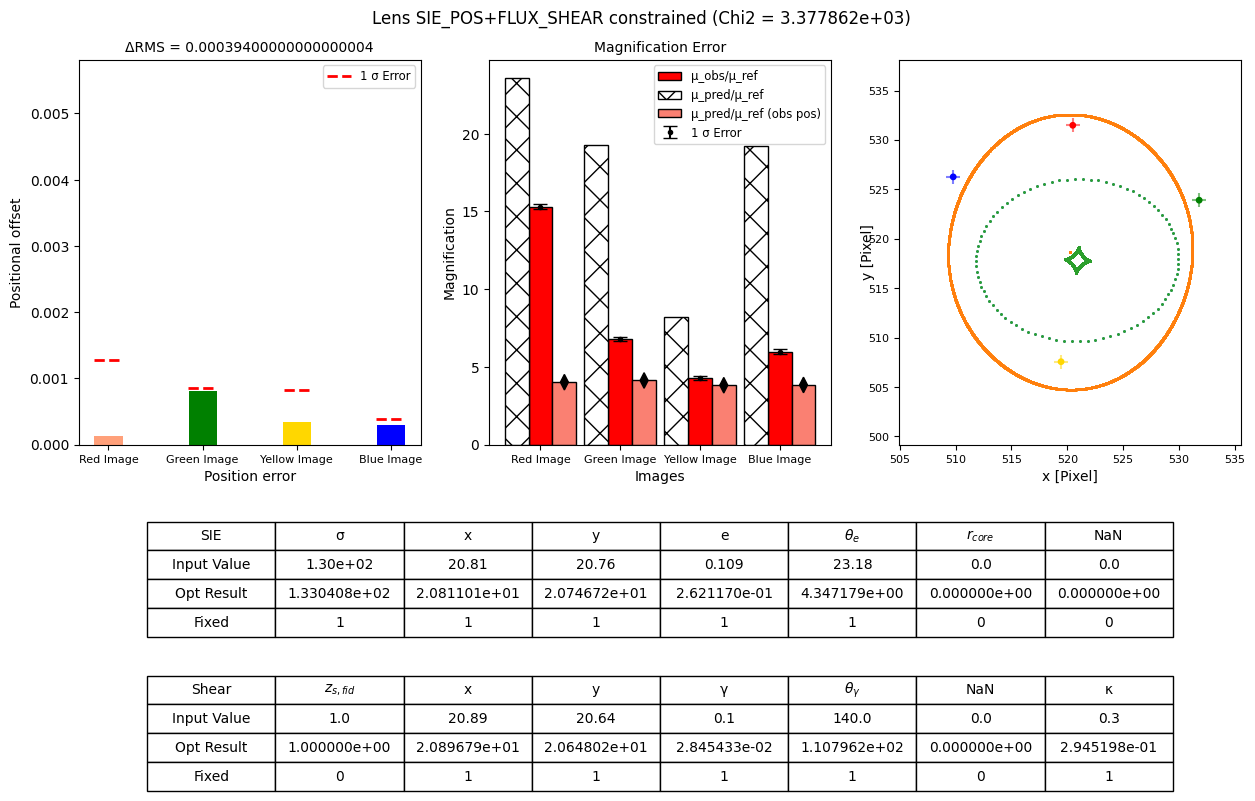

In [10]:
plot_name_1 = 'SIE_POS+FLUX_SHEAR'
loc = 'SIE+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# POW + SHEAR
%run POW+SHEAR/pos_point.py

amoeba_delta = 8.382819e-01

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7736   y =   20.3031   mag =  -11.0522 [  -2.609]   td[day] =     0.786
x =   21.2713   y =   20.9562   mag =   24.3447 [  -3.466]   td[day] =     0.000
x =   20.3893   y =   21.0507   mag =   24.6345 [  -3.479]   td[day] =     0.025
x =   20.8198   y =   21.2594   mag =  -33.0242 [  -3.797]   td[day] =     0.117


######## optimizing lens
 number of parameters = 8 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.705279e+04  tol = 2.000000e+00
amoeba:  n =     2  y = 1.689594e+04  tol = 2.000000e+00
amoeba:  n =     3  y = 1.689594e+04  tol = 1.733802e+00
amoeba:  n =     4  y = 1.689594e+04  tol = 1.527440e+00
amoeba:  n =     5  y = 1.689594e+04  tol = 1.191349e+00
amoeba:  n =     6  y = 1.689594e+04  tol = 1.191349e+00
amoeba:  n =     7  y = 1.689594e+04  tol = 1.191349e+00
amoeba:  n =     8  y = 1.689594e+04  tol = 1.181600e+00
amoeba:  n =     9  y = 1.689594e+04  tol = 1.176011e+00
amoeba:  n =    10  y = 1.689594e+04  tol = 1.166372e+00
amoeba:  n =    11  y = 1.139517e+04  tol = 1.298957e+00
amoeba:  n =    12  y = 1.139517e+04  tol = 1.132491e+00
amoeba:  n =    13  y = 1.139517e+04  tol = 1.076732e+00
amoeba:  n =    14  y = 1.139517e+04  tol = 8.991524e-01
amoeba:  n =    15  y = 1.139517e+04  tol = 8.798522e-01
amoeba:  n =    16  y = 1.139517e+04  tol = 8.742420e-01
amo

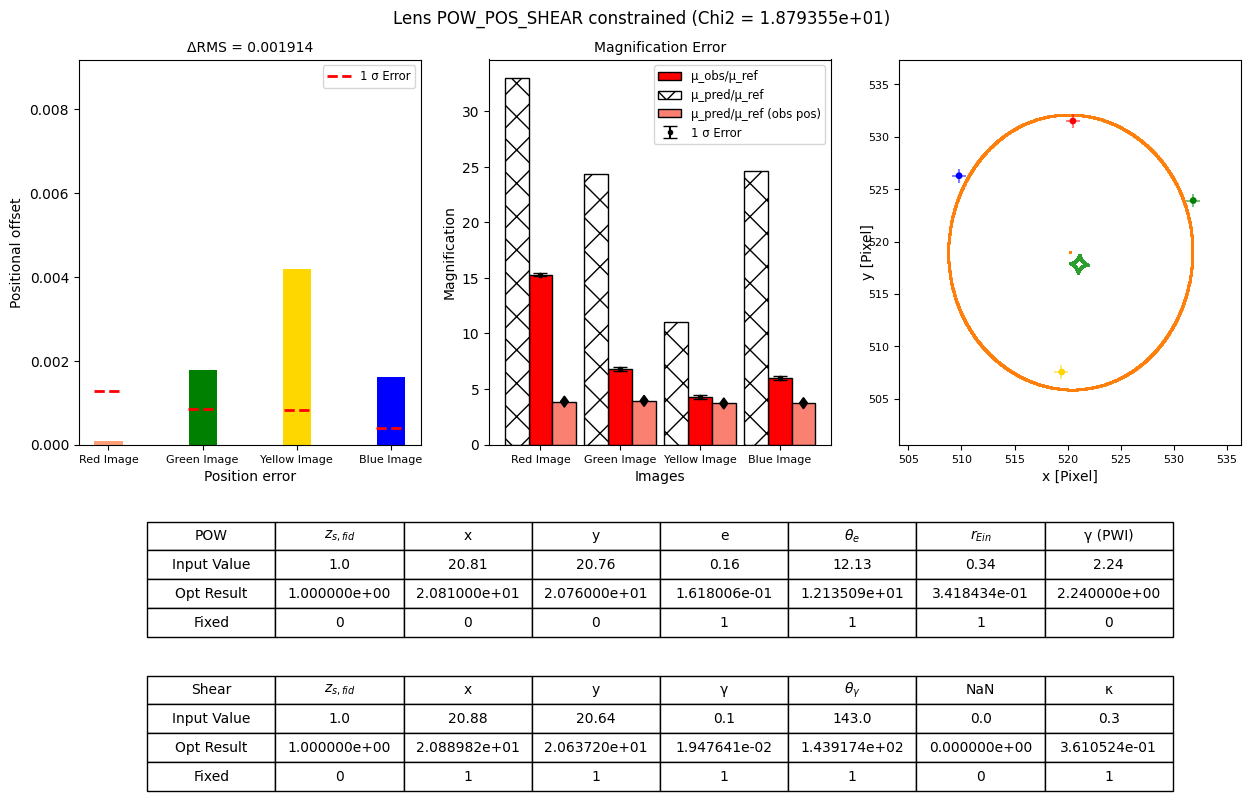

In [4]:
plot_name_1 = 'POW_POS_SHEAR'
loc = 'POW+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [2]:
# POW + SHEAR
%run POW+SHEAR/pos_flux_point.py

amoeba_delta = 7.826863e-01

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7722   y =   20.3036   mag =   -6.6084 [  -2.050]   td[day] =     1.023
x =   21.2726   y =   20.9568   mag =   14.3245 [  -2.890]   td[day] =     0.000
x =   20.3893   y =   21.0496   mag =   14.8460 [  -2.929]   td[day] =     0.037
x =   20.8198   y =   21.2593   mag =  -19.6606 [  -3.234]   td[day] =     0.155


######## optimizing lens
 number of parameters = 8 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 6.111486e+04  tol = 1.843987e+00
amoeba:  n =     2  y = 6.111486e+04  tol = 1.822851e+00
amoeba:  n =     3  y = 6.111486e+04  tol = 1.790035e+00
amoeba:  n =     4  y = 1.317440e+04  tol = 1.941326e+00
amoeba:  n =     5  y = 1.317440e+04  tol = 1.941326e+00
amoeba:  n =     6  y = 1.317440e+04  tol = 1.941326e+00
amoeba:  n =     7  y = 1.317440e+04  tol = 1.936808e+00
amoeba:  n =     8  y = 1.317440e+04  tol = 1.880954e+00
amoeba:  n =     9  y = 1.317440e+04  tol = 1.855176e+00
amoeba:  n =    10  y = 1.317440e+04  tol = 1.836858e+00
amoeba:  n =    11  y = 1.317440e+04  tol = 1.813287e+00
amoeba:  n =    12  y = 1.317440e+04  tol = 1.813128e+00
amoeba:  n =    13  y = 1.317440e+04  tol = 1.795237e+00
amoeba:  n =    14  y = 1.317440e+04  tol = 1.759397e+00
amoeba:  n =    15  y = 1.317440e+04  tol = 1.712419e+00
amoeba:  n =    16  y = 1.317440e+04  tol = 1.689133e+00
amo

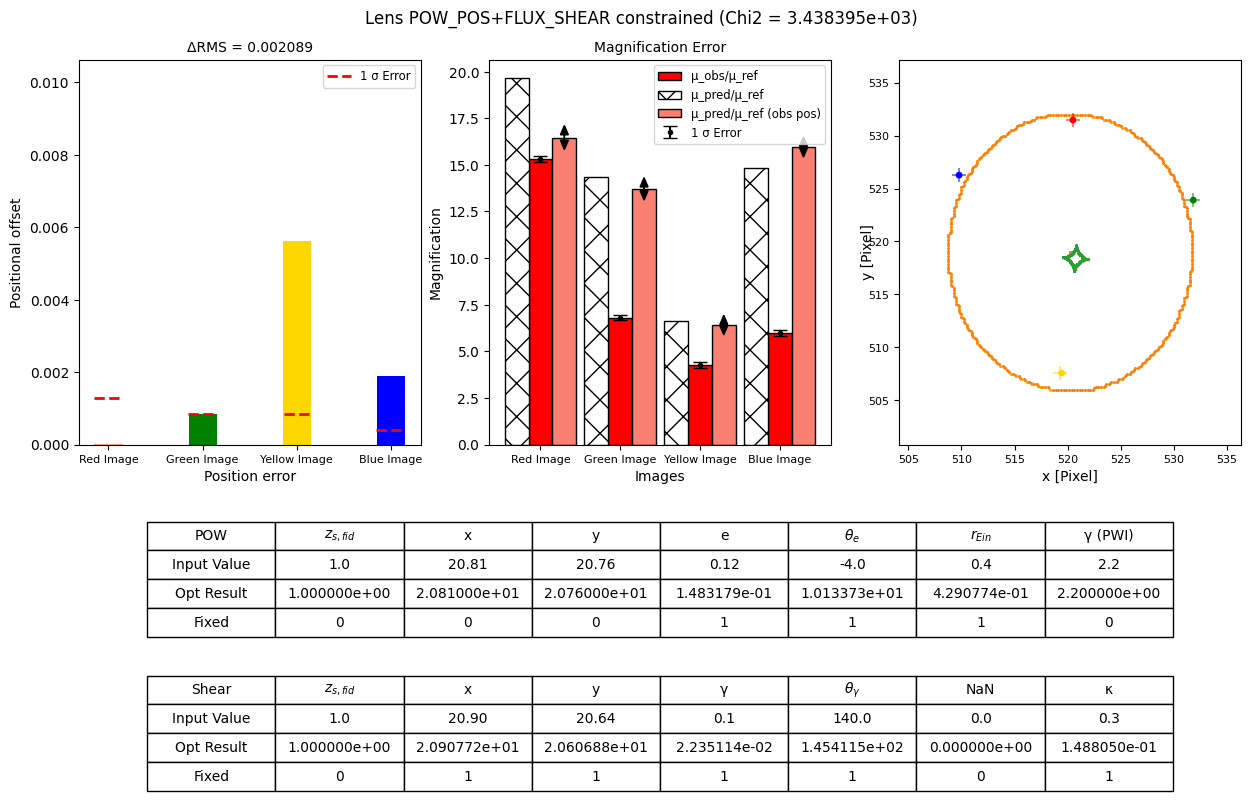

In [3]:
plot_name_1 = 'POW_POS+FLUX_SHEAR'
loc = 'POW+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# NFW + SHEAR
%run NFW+SHEAR/pos_point.py

amoeba_delta = 1.000000e+00

amoeba_delta = 1.000000e+00

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7777   y =   20.3025   mag =   -6.3597 [  -2.009]   td[day] =     1.181
x =   20.8117   y =   20.7509   mag =    0.0132 [   4.697]   td[day] =     3.687
x =   21.2731   y =   20.9561   mag =   13.3413 [  -2.813]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   13.8845 [  -2.856]   td[day] =     0.043
x =   20.8198   y =   21.2593   mag =  -18.4422 [  -3.165]   td[day] =     0.178


######## optimizing lens
 number of parameters = 11 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.000000e+30  tol = 0.000000e+00

------------------------------------------
optimize ndim=13
run 1: 1 lens models calculated
chi^2 = 1.000000e+30  [N_data(extend): 0]
 extend     : 0.000000e+00 0.000000e+00 0.000000e+00
 point no 1 : 1.000000e+30 1.000000e+30 0.000000e+00 0.000000e+00 0.000000e+00
 lens prior : 0.000000e+00
 map prior  : 0.000000e+00

omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000

lens   anfw    0.2613  5.000000e+11  2.078000e+01  2.078000e+01  1.000000e-01 -4.000000e+00  8.700000e+01  0.000000e+00 
lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  1.000000e-01  1.400000e+02  0.000000e+00  1.000000e-01 
point  1.0000  2.075834e+01  2.117271e+01 
------------------------------------------

writing result to NFW+SHEAR/NFW_POS_SHEAR_optresult.dat

amoeba:  n =     1  y = 5.970971e+05  tol = 2.000000e+00
amoeba:  n =     2  y = 5.

30  y = 7.788281e+00  tol = 5.293364e-01
amoeba:  n =   531  y = 7.788281e+00  tol = 5.163411e-01
amoeba:  n =   532  y = 7.788281e+00  tol = 4.987429e-01
amoeba:  n =   533  y = 7.788281e+00  tol = 4.948554e-01
amoeba:  n =   534  y = 7.430412e+00  tol = 5.237042e-01
amoeba:  n =   535  y = 7.430412e+00  tol = 5.079229e-01
amoeba:  n =   536  y = 7.430412e+00  tol = 4.917979e-01
amoeba:  n =   537  y = 6.872324e+00  tol = 5.570757e-01
amoeba:  n =   538  y = 6.872324e+00  tol = 5.113110e-01
amoeba:  n =   539  y = 6.872324e+00  tol = 4.407679e-01
amoeba:  n =   540  y = 4.711945e+00  tol = 7.788280e-01
amoeba:  n =   541  y = 4.711945e+00  tol = 7.115073e-01
amoeba:  n =   542  y = 4.711945e+00  tol = 6.537286e-01
amoeba:  n =   543  y = 4.711945e+00  tol = 6.333276e-01
amoeba:  n =   544  y = 4.711945e+00  tol = 5.840141e-01
amoeba:  n =   545  y = 4.711945e+00  tol = 5.813655e-01
amoeba:  n =   546  y = 4.607999e+00  tol = 5.760571e-01
amoeba:  n =   547  y = 4.537293e+00  tol = 5.4

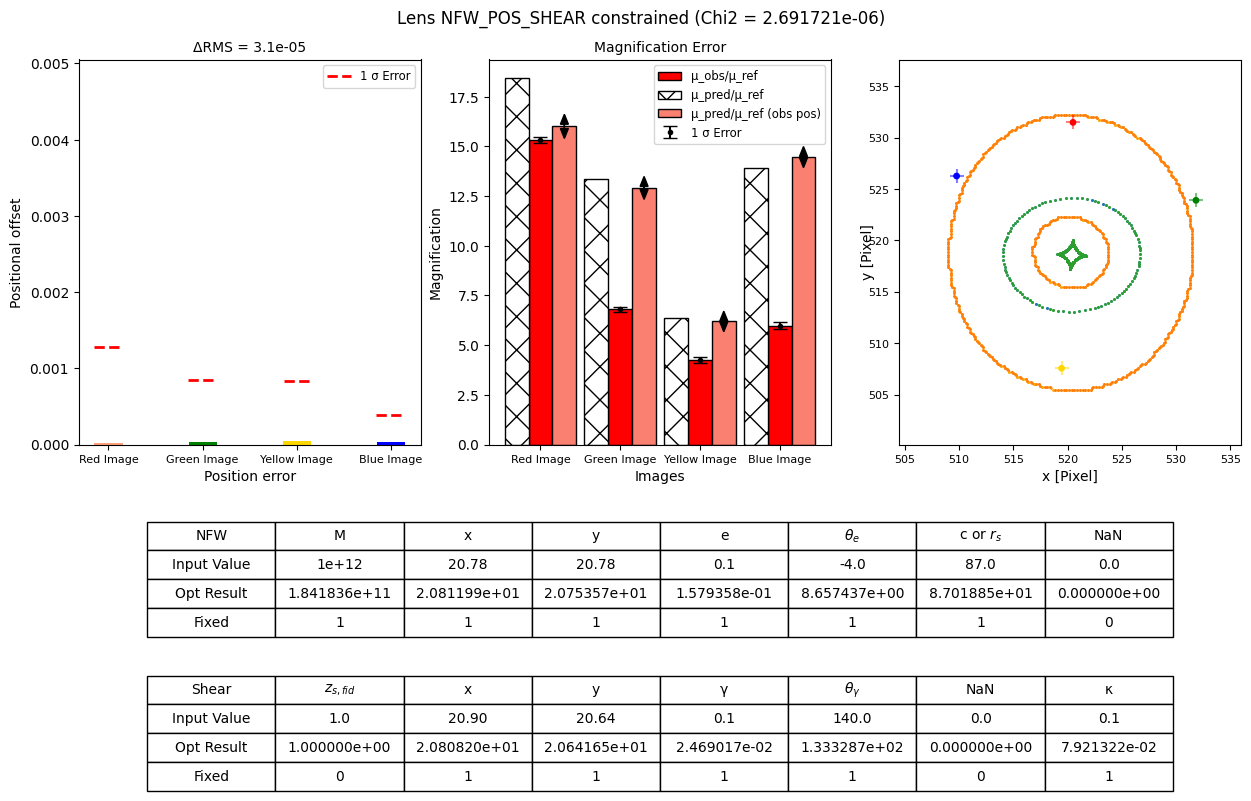

In [19]:
plot_name_1 = 'NFW_POS_SHEAR'
loc = 'NFW+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# NFW + SHEAR
%run NFW+SHEAR/pos_flux_point.py

amoeba_delta = 1.000000e+00

amoeba_delta = 9.574717e-01

amoeba_delta = 1.219772e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7767   y =   20.3032   mag =  -13.3279 [  -2.812]   td[day] =     0.581
x =   20.8132   y =   20.7669   mag =    0.0101 [   4.986]   td[day] =     3.458
x =   21.2731   y =   20.9562   mag =   25.1450 [  -3.501]   td[day] =     0.000
x =   20.3909   y =   21.0497   mag =   27.5594 [  -3.601]   td[day] =     0.023
x =   20.8198   y =   21.2594   mag =  -38.6024 [  -3.967]   td[day] =     0.086


######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.000000e+30  tol = 0.000000e+00

------------------------------------------
optimize ndim=12
run 1: 1 lens models calculated
chi^2 = 1.000000e+30  [N_data(extend): 0]
 extend     : 0.000000e+00 0.000000e+00 0.000000e+00
 point no 1 : 1.000000e+30 1.000000e+30 0.000000e+00 0.000000e+00 0.000000e+00
 lens prior : 0.000000e+00
 map prior  : 0.000000e+00

omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000

lens   anfw    0.2613  5.000000e+11  2.078000e+01  2.078000e+01  1.000000e-01 -4.000000e+00  8.000000e+01  0.000000e+00 
lens   pert    0.2613  1.000000e+00  2.090000e+01  2.064000e+01  1.000000e-01  1.400000e+02  0.000000e+00  1.000000e-04 
point  1.0000  2.074610e+01  2.108164e+01 
------------------------------------------

writing result to NFW+SHEAR/NFW_POS+FLUX_SHEAR_optresult.dat

amoeba:  n =     1  y = 3.645982e+05  tol = 2.000000e+00
amoeba:  n =     2  y

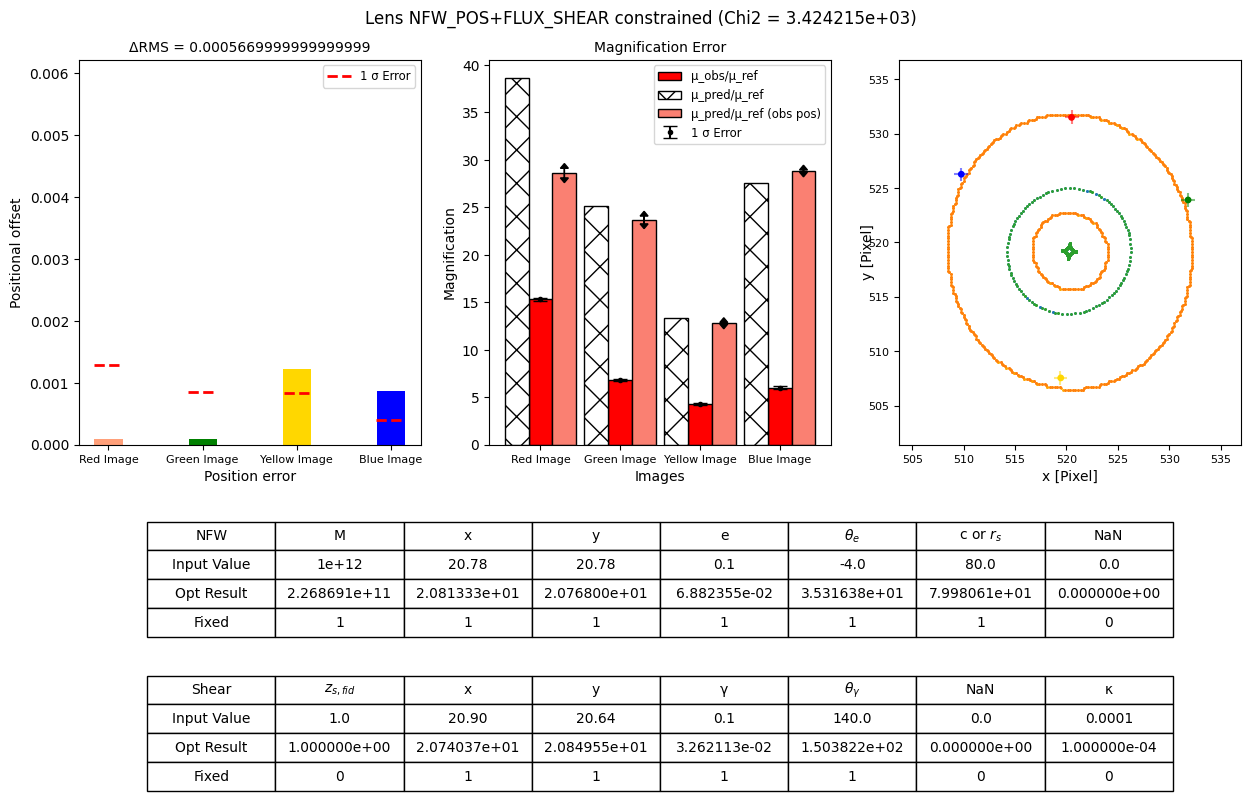

In [20]:
plot_name_1 = 'NFW_POS+FLUX_SHEAR'
loc = 'NFW+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# C_SIE + SHEAR
%run C_SIE+SHEAR/pos_point.py

amoeba_delta = 7.853974e-01

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7777   y =   20.3025   mag =  -13.1400 [  -2.796]   td[day] =     0.615
x =   20.8132   y =   20.7639   mag =    0.0286 [   3.861]   td[day] =     3.707
x =   21.2731   y =   20.9561   mag =   25.6092 [  -3.521]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   27.6424 [  -3.604]   td[day] =     0.023
x =   20.8198   y =   21.2593   mag =  -38.8276 [  -3.973]   td[day] =     0.090


######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.363312e+04  tol = 1.967849e+00
amoeba:  n =     2  y = 1.363312e+04  tol = 1.902380e+00
amoeba:  n =     3  y = 1.363312e+04  tol = 1.896241e+00
amoeba:  n =     4  y = 1.363312e+04  tol = 1.872387e+00
amoeba:  n =     5  y = 1.363312e+04  tol = 1.848238e+00
amoeba:  n =     6  y = 1.341768e+04  tol = 1.835668e+00
amoeba:  n =     7  y = 1.341768e+04  tol = 1.831476e+00
amoeba:  n =     8  y = 1.341768e+04  tol = 1.827747e+00
amoeba:  n =     9  y = 1.341768e+04  tol = 1.827747e+00
amoeba:  n =    10  y = 1.341768e+04  tol = 1.827747e+00
amoeba:  n =    11  y = 1.341768e+04  tol = 1.814772e+00
amoeba:  n =    12  y = 1.341768e+04  tol = 1.811250e+00
amoeba:  n =    13  y = 1.341768e+04  tol = 1.736304e+00
amoeba:  n =    14  y = 1.341768e+04  tol = 1.657958e+00
amoeba:  n =    15  y = 1.341768e+04  tol = 1.616596e+00
amoeba:  n =    16  y = 1.341768e+04  tol = 1.614145e+00
am

000000e+00
 map prior  : 0.000000e+00

omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000

lens   sie     0.2613  1.640646e+02  2.081341e+01  2.076613e+01  8.474830e-02  3.087715e+01  3.817197e-02  0.000000e+00 
lens   pert    0.2613  1.000000e+00  2.088229e+01  2.068053e+01  3.406566e-02  1.449960e+02  0.000000e+00  1.000000e-03 
point  1.0000  2.081883e+01  2.077747e+01 
------------------------------------------

writing result to C_SIE+SHEAR/SIE_POS_SHEAR_optresult.dat

amoeba:  n =     1  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     2  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     3  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     4  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     5  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     6  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     7  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     8  y = 2.324290e-06  tol = 2.000000e+00
amoeba:  n =     9  y = 2.324290e-06  tol = 2.00000

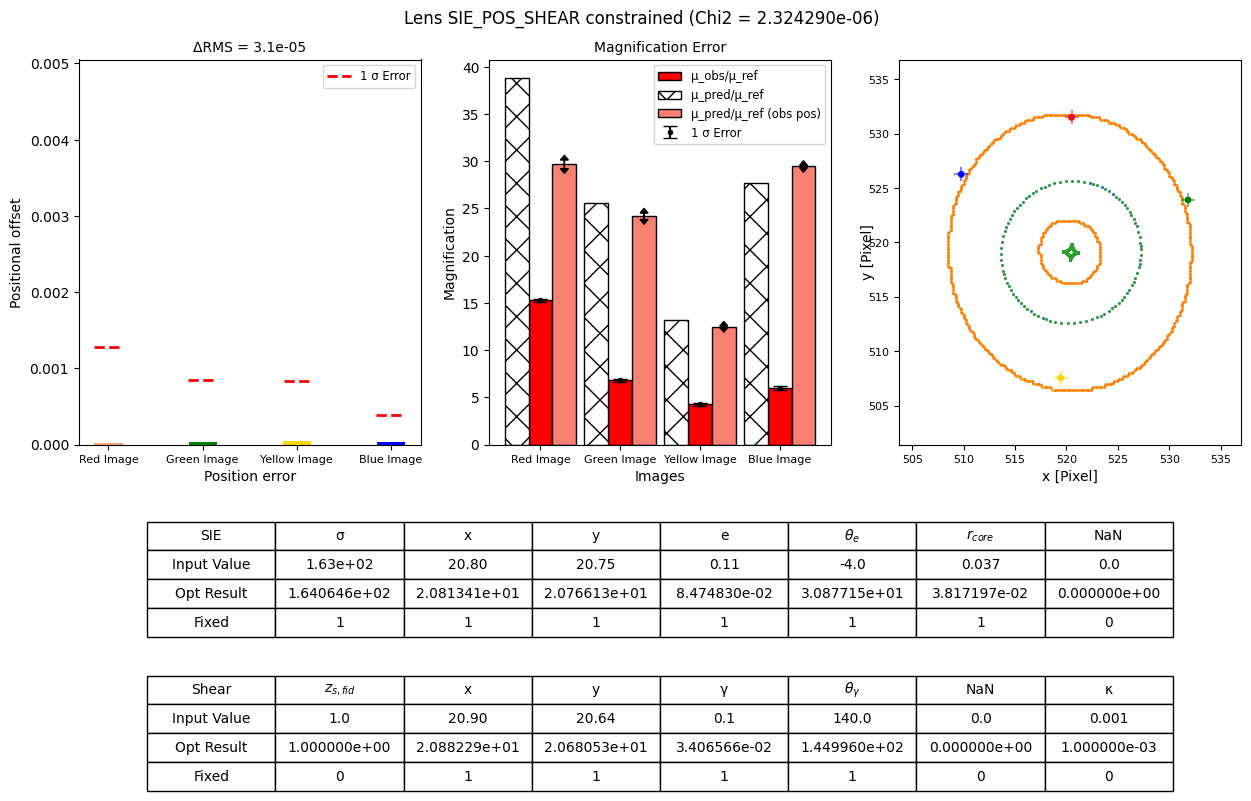

In [5]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'C_SIE+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# C_SIE + SHEAR
%run C_SIE+SHEAR/pos_flux_point.py

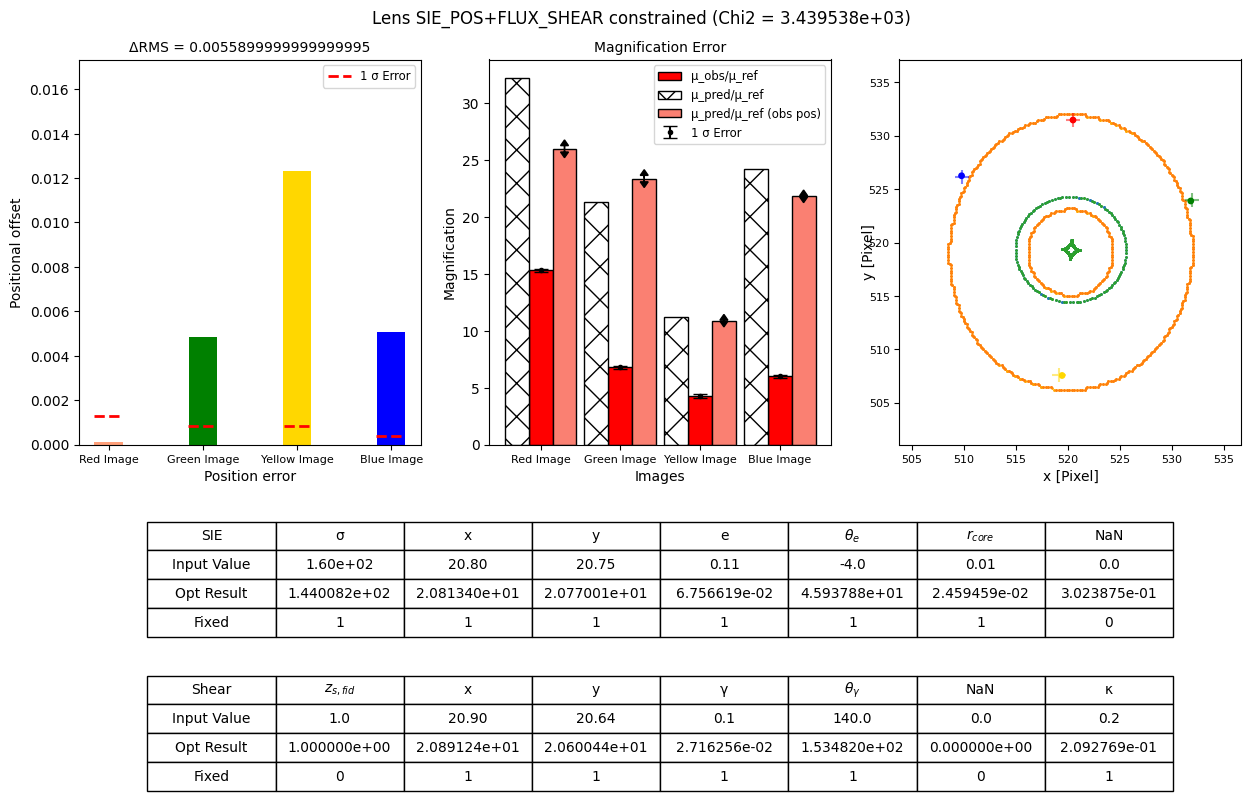

In [22]:
plot_name_1 = 'SIE_POS+FLUX_SHEAR'
loc = 'C_SIE+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [7]:
# EIN + SHEAR
%run EIN+SHEAR/pos_point.py

amoeba_delta = 1.000000e+00

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7777   y =   20.3025   mag =   -8.4705 [  -2.320]   td[day] =     0.754
x =   20.8128   y =   20.7599   mag =    0.1978 [   1.759]   td[day] =     3.247
x =   21.2731   y =   20.9561   mag =   15.5717 [  -2.981]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   17.0349 [  -3.078]   td[day] =     0.030
x =   20.8198   y =   21.2593   mag =  -24.0271 [  -3.452]   td[day] =     0.111


######## optimizing lens
 number of parameters = 11 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 5.234488e+05  tol = 2.000000e+00
amoeba:  n =     2  y = 5.234488e+05  tol = 2.000000e+00
amoeba:  n =     3  y = 2.411041e+05  tol = 1.566954e+00
amoeba:  n =     4  y = 2.411041e+05  tol = 1.566709e+00
amoeba:  n =     5  y = 2.411041e+05  tol = 1.566709e+00
amoeba:  n =     6  y = 2.411041e+05  tol = 1.566709e+00
amoeba:  n =     7  y = 2.411041e+05  tol = 1.549813e+00
amoeba:  n =     8  y = 2.411041e+05  tol = 1.512094e+00
amoeba:  n =     9  y = 2.411041e+05  tol = 1.307305e+00
amoeba:  n =    10  y = 4.837370e+04  tol = 1.838477e+00
amoeba:  n =    11  y = 4.837370e+04  tol = 1.801770e+00
amoeba:  n =    12  y = 4.837370e+04  tol = 1.795776e+00
amoeba:  n =    13  y = 4.837370e+04  tol = 1.774988e+00
amoeba:  n =    14  y = 4.837370e+04  tol = 1.701978e+00
amoeba:  n =    15  y = 4.837370e+04  tol = 1.680817e+00
amoeba:  n =    16  y = 4.837370e+04  tol = 1.661617e+00
am

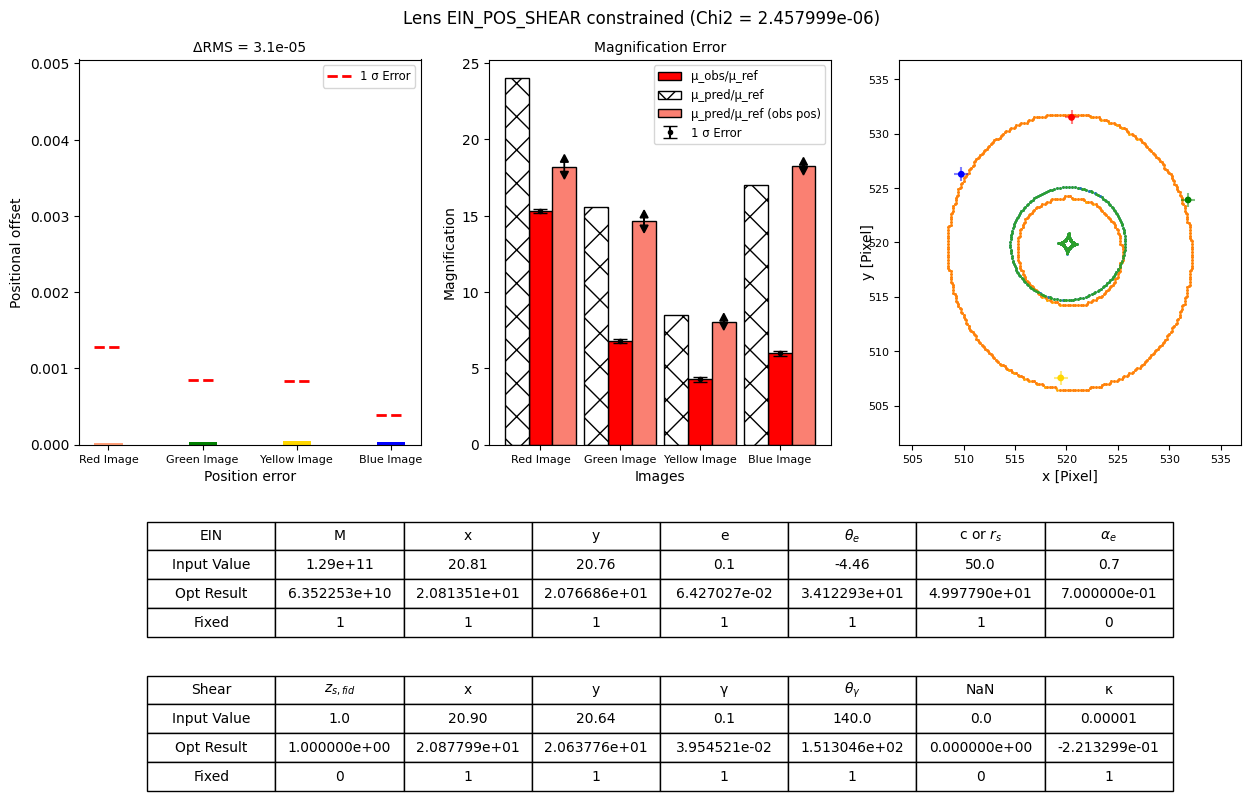

In [8]:
plot_name_1 = 'EIN_POS_SHEAR'
loc = 'EIN+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# EIN + SHEAR + POS + FLUX
%run EIN+SHEAR/pos_flux_point.py

amoeba_delta = 8.287606e-01

amoeba_delta = 2.262569e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7772   y =   20.3035   mag =   -7.4548 [  -2.181]   td[day] =     0.905
x =   20.8123   y =   20.7568   mag =    0.1322 [   2.197]   td[day] =     3.310
x =   21.2737   y =   20.9561   mag =   13.9441 [  -2.861]   td[day] =     0.000
x =   20.3906   y =   21.0500   mag =   15.0986 [  -2.947]   td[day] =     0.035
x =   20.8198   y =   21.2595   mag =  -21.0807 [  -3.310]   td[day] =     0.135


######## optimizing lens
 number of parameters = 11 (lens) + 0 (extend) + 2 (point) 

 making tables for ein... [99 x 801 = 79299 points]

amoeba:  n =     1  y = 7.625676e+05  tol = 6.912682e-01
amoeba:  n =     2  y = 7.625676e+05  tol = 6.011443e-01
amoeba:  n =     3  y = 5.928596e+05  tol = 7.189937e-01
amoeba:  n =     4  y = 5.928596e+05  tol = 6.492950e-01
amoeba:  n =     5  y = 3.202899e+05  tol = 9.964500e-01
amoeba:  n =     6  y = 3.202899e+05  tol = 9.368926e-01
amoeba:  n =     7  y = 3.202899e+05  tol = 9.334066e-01
amoeba:  n =     8  y = 3.202899e+05  tol = 8.902690e-01
amoeba:  n =     9  y = 3.202899e+05  tol = 8.861208e-01
amoeba:  n =    10  y = 3.202899e+05  tol = 8.861208e-01
amoeba:  n =    11  y = 3.202899e+05  tol = 8.861208e-01
amoeba:  n =    12  y = 3.202899e+05  tol = 8.694963e-01
amoeba:  n =    13  y = 3.202899e+05  tol = 8.297953e-01
amoeba:  n =    14  y = 3.202899e+05  tol = 8.168715e-01
amoeba:  n =    15  y = 3.202899e+05  tol = 7.668470e-01
amoeba

 =   456  y = 4.078794e+03  tol = 3.516253e-04
amoeba:  n =   457  y = 4.078073e+03  tol = 4.667554e-04
amoeba:  n =   458  y = 4.078073e+03  tol = 4.343806e-04
amoeba:  n =   459  y = 4.078073e+03  tol = 4.309915e-04
amoeba:  n =   460  y = 4.078073e+03  tol = 4.123530e-04
amoeba:  n =   461  y = 4.078073e+03  tol = 3.679120e-04
amoeba:  n =   462  y = 4.078073e+03  tol = 3.506672e-04
amoeba:  n =   463  y = 4.077678e+03  tol = 4.437916e-04
amoeba:  n =   464  y = 4.077678e+03  tol = 4.235775e-04
amoeba:  n =   465  y = 4.076763e+03  tol = 5.970112e-04
amoeba:  n =   466  y = 4.076763e+03  tol = 5.869836e-04
amoeba:  n =   467  y = 4.076763e+03  tol = 5.289099e-04
amoeba:  n =   468  y = 4.076763e+03  tol = 4.981084e-04
amoeba:  n =   469  y = 4.075824e+03  tol = 6.836054e-04
amoeba:  n =   470  y = 4.075824e+03  tol = 6.567164e-04
amoeba:  n =   471  y = 4.075824e+03  tol = 6.206346e-04
amoeba:  n =   472  y = 4.075824e+03  tol = 6.069367e-04
amoeba:  n =   473  y = 4.075824e+03  tol

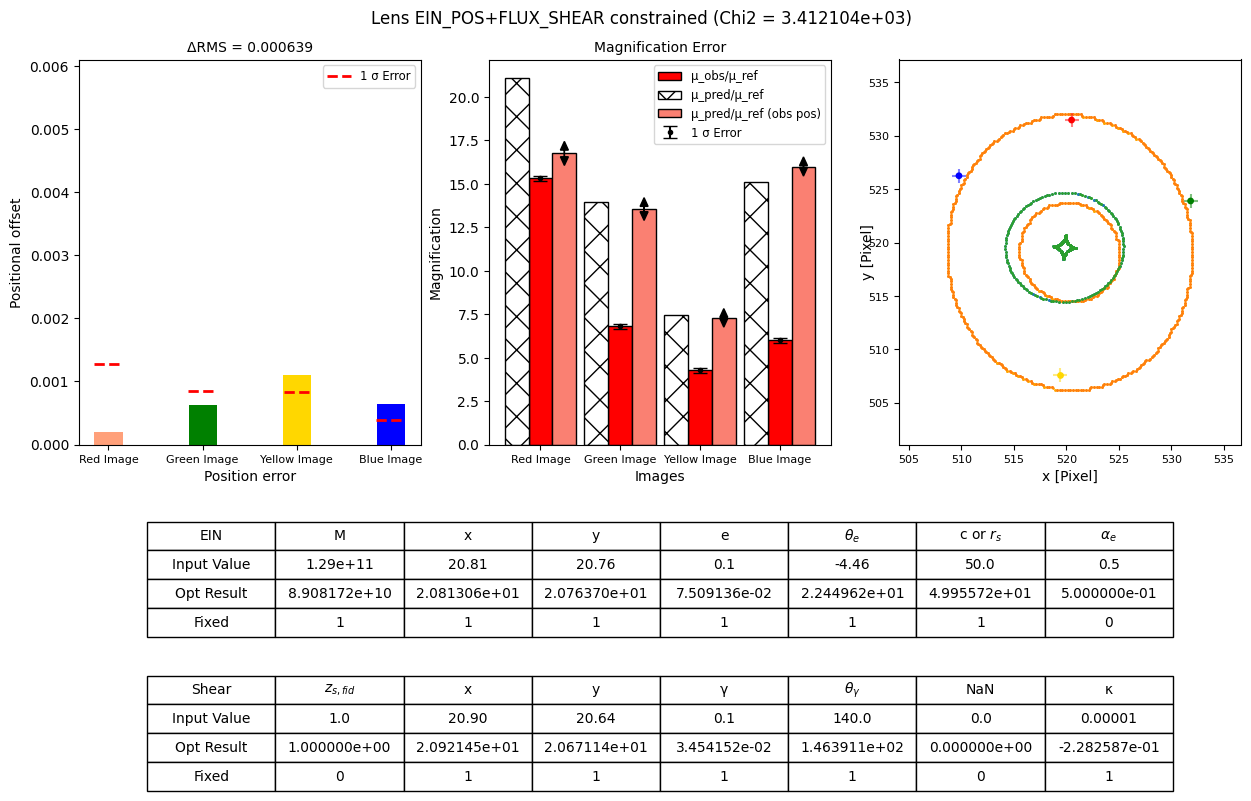

In [5]:
plot_name_1 = 'EIN_POS+FLUX_SHEAR'
loc = 'EIN+SHEAR/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [2]:
# SIE + SHEAR + FIXED
%run SIE+SHEAR+FIX/pos_point.py

amoeba_delta = 3.710453e-01

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7777   y =   20.3025   mag =  -10.2274 [  -2.524]   td[day] =     0.718
x =   21.2731   y =   20.9561   mag =   20.4728 [  -3.278]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   21.7663 [  -3.344]   td[day] =     0.026
x =   20.8198   y =   21.2593   mag =  -30.6329 [  -3.715]   td[day] =     0.104


######## optimizing lens
 number of parameters = 9 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.415674e+04  tol = 2.000000e+00
amoeba:  n =     2  y = 1.415674e+04  tol = 1.816856e+00
amoeba:  n =     3  y = 1.415674e+04  tol = 1.715827e+00
amoeba:  n =     4  y = 1.415674e+04  tol = 1.707870e+00
amoeba:  n =     5  y = 1.415674e+04  tol = 1.596667e+00
amoeba:  n =     6  y = 1.415674e+04  tol = 1.579279e+00
amoeba:  n =     7  y = 1.415674e+04  tol = 1.560357e+00
amoeba:  n =     8  y = 1.415674e+04  tol = 1.557926e+00
amoeba:  n =     9  y = 1.415674e+04  tol = 1.541389e+00
amoeba:  n =    10  y = 1.415674e+04  tol = 1.518365e+00
amoeba:  n =    11  y = 1.415674e+04  tol = 1.518365e+00
amoeba:  n =    12  y = 1.415674e+04  tol = 1.518365e+00
amoeba:  n =    13  y = 1.415674e+04  tol = 1.511494e+00
amoeba:  n =    14  y = 1.415674e+04  tol = 1.490633e+00
amoeba:  n =    15  y = 1.415674e+04  tol = 1.402254e+00
amoeba:  n =    16  y = 8.028559e+03  tol = 1.630592e+00
amo

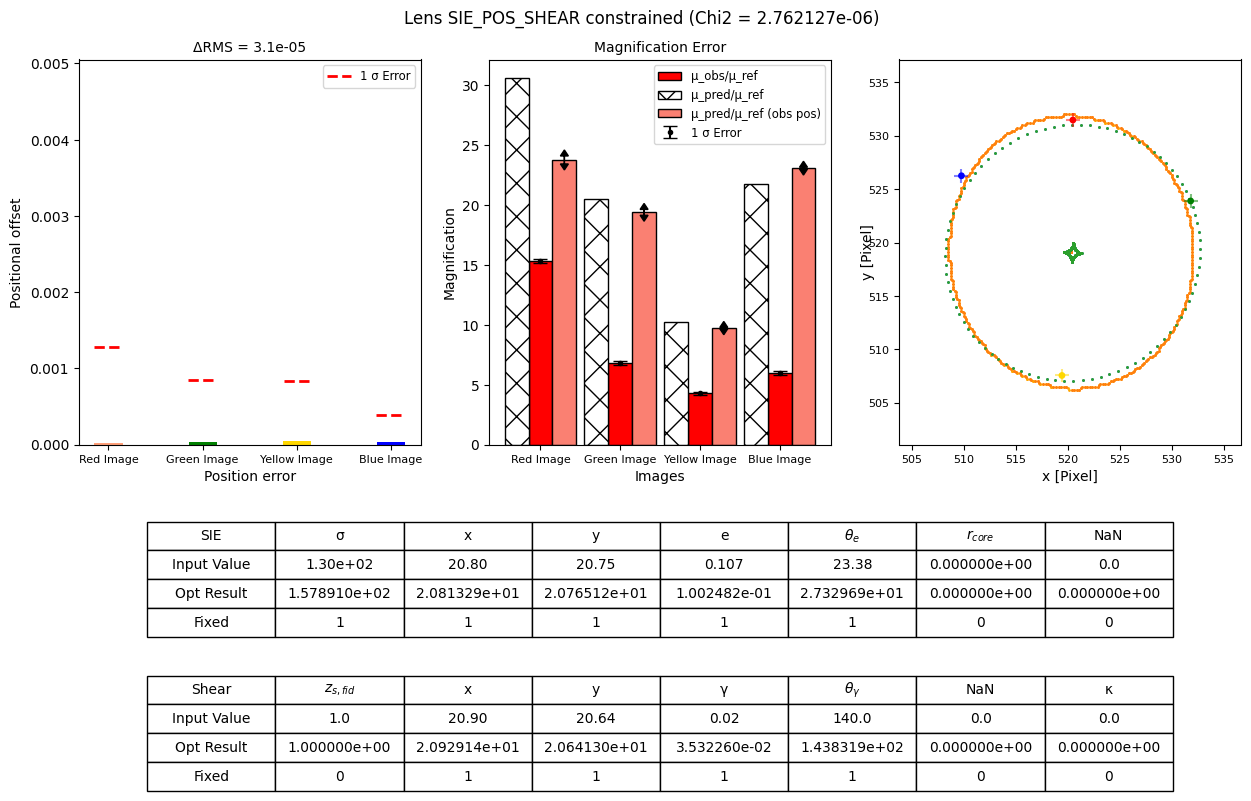

In [6]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'SIE+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [25]:
# SIE + SHEAR + FIXED
%run SIE+SHEAR+FIX/pos_flux_point.py

amoeba_delta = 6.111452e-01

amoeba_delta = 1.232097e-02

amoeba_delta = 1.236745e-02

amoeba_delta = 1.225598e-02

amoeba_delta = 1.239693e-02

amoeba_delta = 1.248534e-02

amoeba_delta = 1.236043e-02

amoeba_delta = 1.235379e-02

amoeba_delta = 1.233905e-02

amoeba_delta = 1.215696e-02

amoeba_delta = 1.207638e-02

amoeba_delta = 1.207079e-02

amoeba_delta = 1.204273e-02

amoeba_delta = 1.210814e-02

amoeba_delta = 1.203917e-02

amoeba_delta = 1.219132e-02

amoeba_delta = 1.208875e-02

n_img = 4
x =   20.7682   y =   20.3047   mag =   -9.3166 [  -2.423]   td[day] =     0.779
x =   21.2758   y =   20.9593   mag =   18.3625 [  -3.160]   td[day] =     0.000
x =   20.3923   y =   21.0469   mag =   20.4910 [  -3.279]   td[day] =     0.037
x =   20.8199   y =   21.2592   mag =  -27.3035 [  -3.591]   td[day] =     0.121


######## optimizing lens
 number of parameters = 9 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.699479e+04  tol = 1.979873e+00
amoeba:  n =     2  y = 1.699479e+04  tol = 1.884203e+00
amoeba:  n =     3  y = 1.699479e+04  tol = 1.846882e+00
amoeba:  n =     4  y = 1.699479e+04  tol = 1.808077e+00
amoeba:  n =     5  y = 1.699479e+04  tol = 1.785515e+00
amoeba:  n =     6  y = 1.699479e+04  tol = 1.757294e+00
amoeba:  n =     7  y = 1.699479e+04  tol = 1.714738e+00
amoeba:  n =     8  y = 1.699479e+04  tol = 1.706479e+00
amoeba:  n =     9  y = 1.699479e+04  tol = 1.706479e+00
amoeba:  n =    10  y = 1.699479e+04  tol = 1.706479e+00
amoeba:  n =    11  y = 1.699479e+04  tol = 1.649667e+00
amoeba:  n =    12  y = 1.699479e+04  tol = 1.643168e+00
amoeba:  n =    13  y = 1.699479e+04  tol = 1.248251e+00
amoeba:  n =    14  y = 1.699479e+04  tol = 1.152466e+00
amoeba:  n =    15  y = 1.699479e+04  tol = 1.104011e+00
amoeba:  n =    16  y = 1.699479e+04  tol = 9.728257e-01
amo

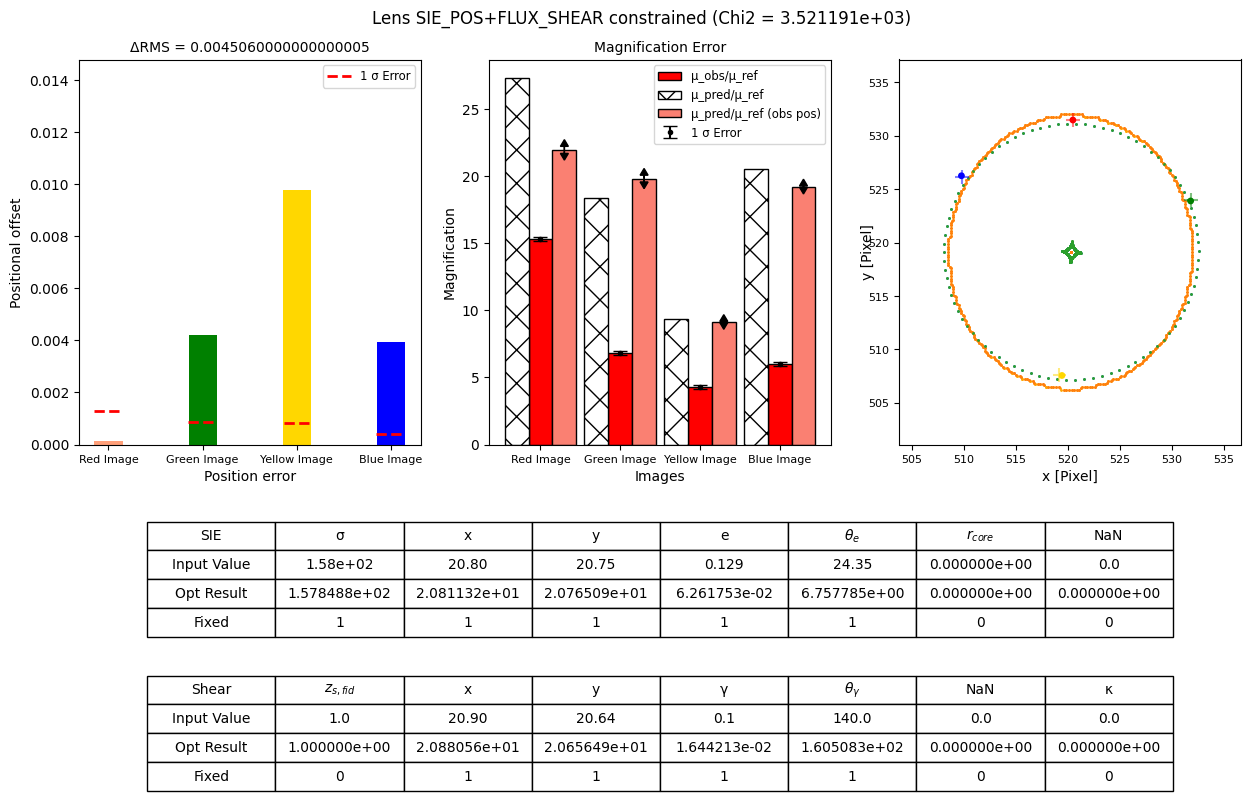

In [26]:
plot_name_1 = 'SIE_POS+FLUX_SHEAR'
loc = 'SIE+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [15]:
# SIE + SHEAR + FIXED
%run POW+SHEAR+FIX/pos_point.py

amoeba_delta = 2.167055e-01

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7741   y =   20.3032   mag =   -2.9235 [  -1.165]   td[day] =     1.511
x =   21.2714   y =   20.9561   mag =    6.8618 [  -2.091]   td[day] =     0.000
x =   20.3895   y =   21.0506   mag =    6.6170 [  -2.052]   td[day] =     0.042
x =   20.8198   y =   21.2594   mag =   -8.7008 [  -2.349]   td[day] =     0.226


######## optimizing lens
 number of parameters = 5 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 8.514262e+04  tol = 1.149658e+00
amoeba:  n =     2  y = 8.514262e+04  tol = 9.503232e-01
amoeba:  n =     3  y = 8.514262e+04  tol = 7.611010e-01
amoeba:  n =     4  y = 7.441232e+04  tol = 8.400842e-01
amoeba:  n =     5  y = 7.441232e+04  tol = 5.856982e-01
amoeba:  n =     6  y = 7.441232e+04  tol = 5.613265e-01
amoeba:  n =     7  y = 5.214970e+04  tol = 7.912353e-01
amoeba:  n =     8  y = 4.891985e+04  tol = 6.487896e-01
amoeba:  n =     9  y = 2.684968e+04  tol = 1.041017e+00
amoeba:  n =    10  y = 2.684968e+04  tol = 9.583137e-01
amoeba:  n =    11  y = 2.684968e+04  tol = 9.393975e-01
amoeba:  n =    12  y = 2.684968e+04  tol = 7.076972e-01
amoeba:  n =    13  y = 2.684968e+04  tol = 6.405118e-01
amoeba:  n =    14  y = 1.952192e+04  tol = 8.590639e-01
amoeba:  n =    15  y = 1.111106e+04  tol = 1.115696e+00
amoeba:  n =    16  y = 1.111106e+04  tol = 1.107421e+00
amo

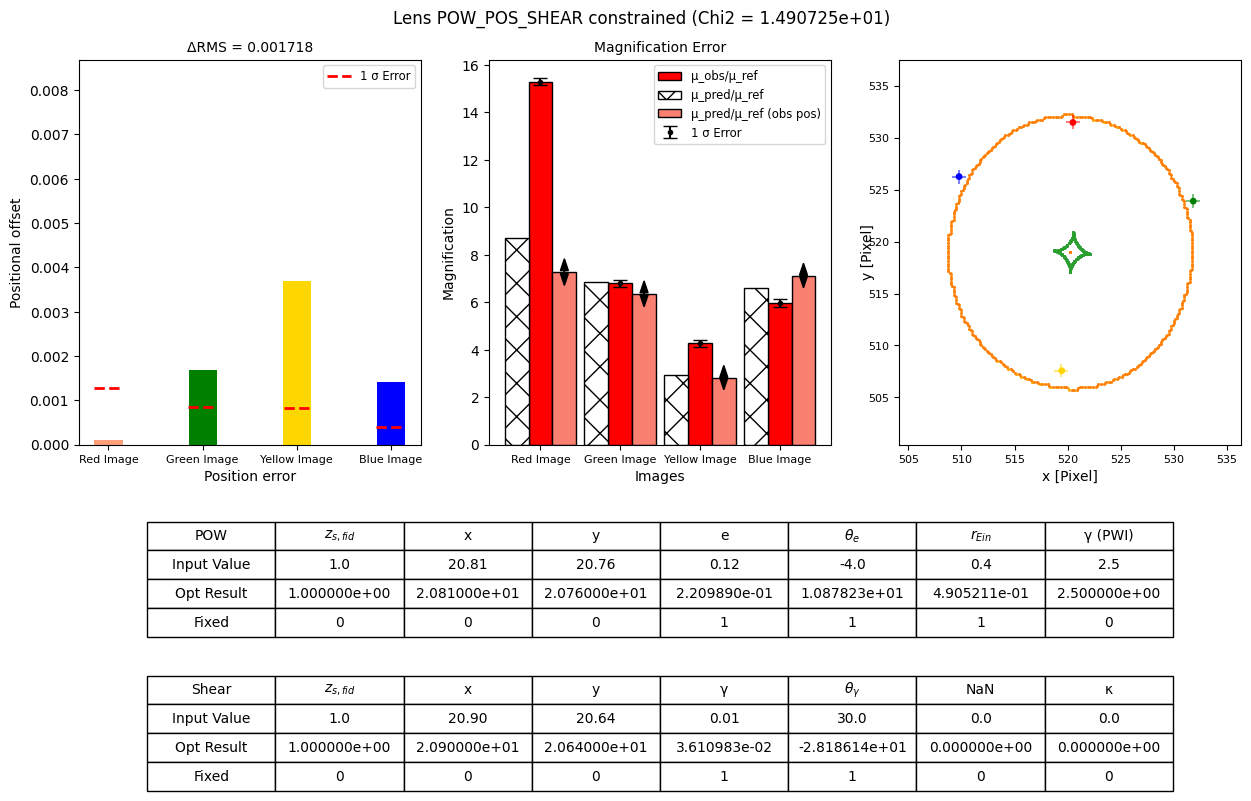

In [16]:
plot_name_1 = 'POW_POS_SHEAR'
loc = 'POW+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [40]:
# SIE + SHEAR + FIXED
%run POW+SHEAR+FIX/pos_flux_point.py

amoeba_delta = 1.000000e+00

amoeba_delta = 1.000000e-02

n_img = 4
x =   20.7731   y =   20.3036   mag =   -7.0932 [  -2.127]   td[day] =     0.993
x =   21.2715   y =   20.9557   mag =   14.9286 [  -2.935]   td[day] =     0.000
x =   20.3894   y =   21.0503   mag =   15.4877 [  -2.975]   td[day] =     0.035
x =   20.8199   y =   21.2594   mag =  -20.8895 [  -3.300]   td[day] =     0.149


######## optimizing lens
 number of parameters = 7 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 9.179913e+04  tol = 1.333353e+00
amoeba:  n =     2  y = 9.179913e+04  tol = 1.241949e+00
amoeba:  n =     3  y = 9.179913e+04  tol = 1.104676e+00
amoeba:  n =     4  y = 4.134445e+04  tol = 1.540198e+00
amoeba:  n =     5  y = 4.023588e+04  tol = 1.551144e+00
amoeba:  n =     6  y = 4.023588e+04  tol = 1.548083e+00
amoeba:  n =     7  y = 4.023588e+04  tol = 1.512869e+00
amoeba:  n =     8  y = 4.023588e+04  tol = 1.315850e+00
amoeba:  n =     9  y = 4.023588e+04  tol = 1.225449e+00
amoeba:  n =    10  y = 4.023588e+04  tol = 1.221372e+00
amoeba:  n =    11  y = 4.023588e+04  tol = 8.925559e-01
amoeba:  n =    12  y = 4.023588e+04  tol = 7.810542e-01
amoeba:  n =    13  y = 4.023588e+04  tol = 5.841118e-01
amoeba:  n =    14  y = 4.023588e+04  tol = 5.612139e-01
amoeba:  n =    15  y = 4.023588e+04  tol = 4.784094e-01
amoeba:  n =    16  y = 3.650380e+04  tol = 5.547850e-01
amo

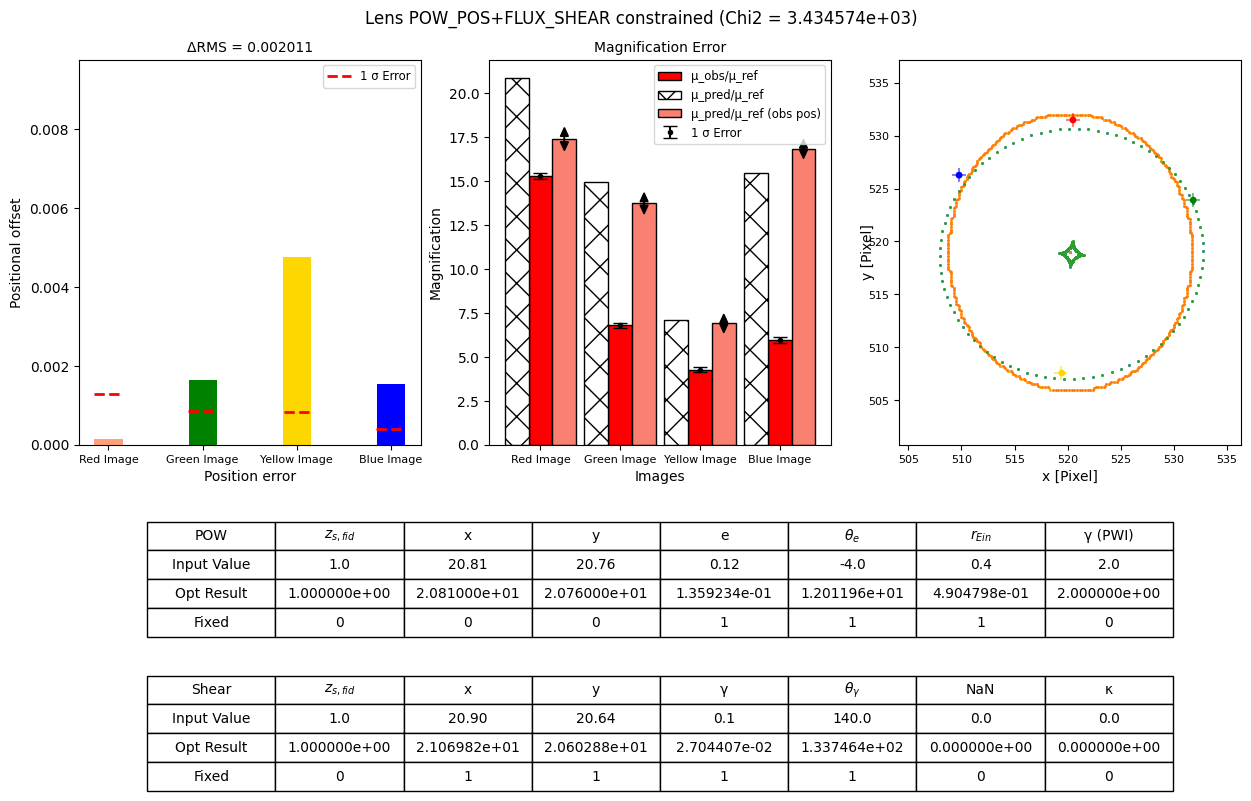

In [41]:
plot_name_1 = 'POW_POS+FLUX_SHEAR'
loc = 'POW+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [16]:
# SIE + SHEAR + FIXED
%run NFW+SHEAR+FIX/pos_point.py

amoeba_delta = 6.154731e-01

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7750   y =   20.3029   mag =   -4.6404 [  -1.666]   td[day] =     1.460
x =   20.8097   y =   20.7468   mag =    0.0120 [   4.799]   td[day] =     4.087
x =   21.2721   y =   20.9562   mag =    9.9394 [  -2.493]   td[day] =     0.000
x =   20.3900   y =   21.0506   mag =   10.3312 [  -2.535]   td[day] =     0.053
x =   20.8198   y =   21.2593   mag =  -13.3973 [  -2.818]   td[day] =     0.223


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.363767e+04  tol = 1.895054e+00
amoeba:  n =     2  y = 1.363767e+04  tol = 1.881833e+00
amoeba:  n =     3  y = 1.363767e+04  tol = 1.859632e+00
amoeba:  n =     4  y = 1.363767e+04  tol = 1.838971e+00
amoeba:  n =     5  y = 1.363767e+04  tol = 1.817282e+00
amoeba:  n =     6  y = 1.363767e+04  tol = 1.817241e+00
amoeba:  n =     7  y = 1.363767e+04  tol = 1.817187e+00
amoeba:  n =     8  y = 1.363767e+04  tol = 1.675735e+00
amoeba:  n =     9  y = 1.363767e+04  tol = 1.285708e+00
amoeba:  n =    10  y = 1.363767e+04  tol = 1.125883e+00
amoeba:  n =    11  y = 1.363767e+04  tol = 9.282732e-01
amoeba:  n =    12  y = 1.363767e+04  tol = 7.493390e-01
amoeba:  n =    13  y = 1.363767e+04  tol = 6.738660e-01
amoeba:  n =    14  y = 8.491999e+03  tol = 1.040533e+00
amoeba:  n =    15  y = 8.491999e+03  tol = 9.212350e-01
amoeba:  n =    16  y = 8.491999e+03  tol = 5.767385e-01
amo

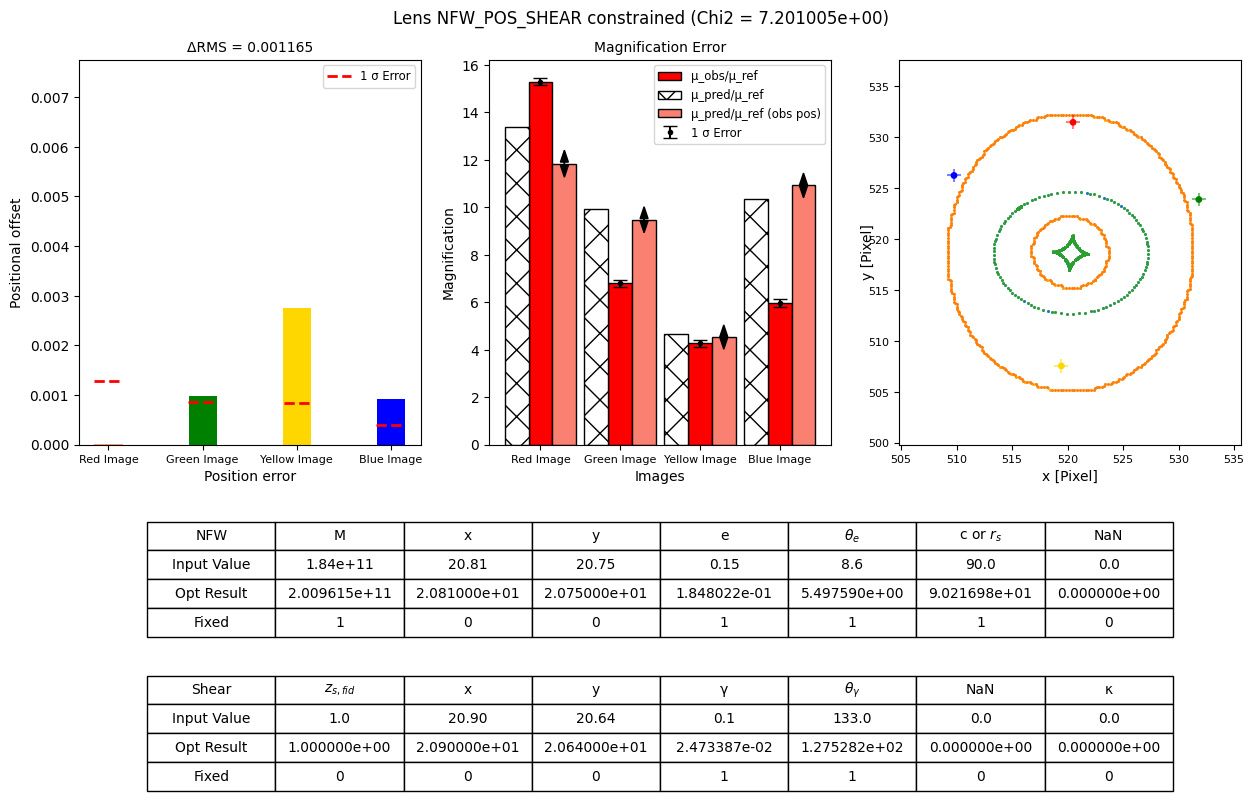

In [17]:
plot_name_1 = 'NFW_POS_SHEAR'
loc = 'NFW+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [20]:
# SIE + SHEAR + FIXED
%run NFW+SHEAR+FIX/pos_flux_point.py

amoeba_delta = 7.199536e-01

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7740   y =   20.3034   mag =   -7.4188 [  -2.176]   td[day] =     0.978
x =   20.8098   y =   20.7580   mag =    0.0112 [   4.879]   td[day] =     3.752
x =   21.2708   y =   20.9552   mag =   14.9225 [  -2.935]   td[day] =     0.000
x =   20.3888   y =   21.0509   mag =   15.6780 [  -2.988]   td[day] =     0.034
x =   20.8198   y =   21.2594   mag =  -21.4824 [  -3.330]   td[day] =     0.145


######## optimizing lens
 number of parameters = 6 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 2.668852e+04  tol = 1.787986e+00
amoeba:  n =     2  y = 2.668852e+04  tol = 1.759414e+00
amoeba:  n =     3  y = 2.668852e+04  tol = 1.683718e+00
amoeba:  n =     4  y = 2.668852e+04  tol = 1.649273e+00
amoeba:  n =     5  y = 2.668852e+04  tol = 1.648851e+00
amoeba:  n =     6  y = 2.668852e+04  tol = 1.636410e+00
amoeba:  n =     7  y = 2.668852e+04  tol = 1.624012e+00
amoeba:  n =     8  y = 2.668852e+04  tol = 1.540084e+00
amoeba:  n =     9  y = 2.668852e+04  tol = 1.322612e+00
amoeba:  n =    10  y = 2.668852e+04  tol = 1.287918e+00
amoeba:  n =    11  y = 2.668852e+04  tol = 1.192030e+00
amoeba:  n =    12  y = 2.668852e+04  tol = 1.167502e+00
amoeba:  n =    13  y = 2.668852e+04  tol = 1.145823e+00
amoeba:  n =    14  y = 2.668852e+04  tol = 1.004133e+00
amoeba:  n =    15  y = 2.668852e+04  tol = 9.162413e-01
amoeba:  n =    16  y = 1.896469e+04  tol = 1.081161e+00
amo

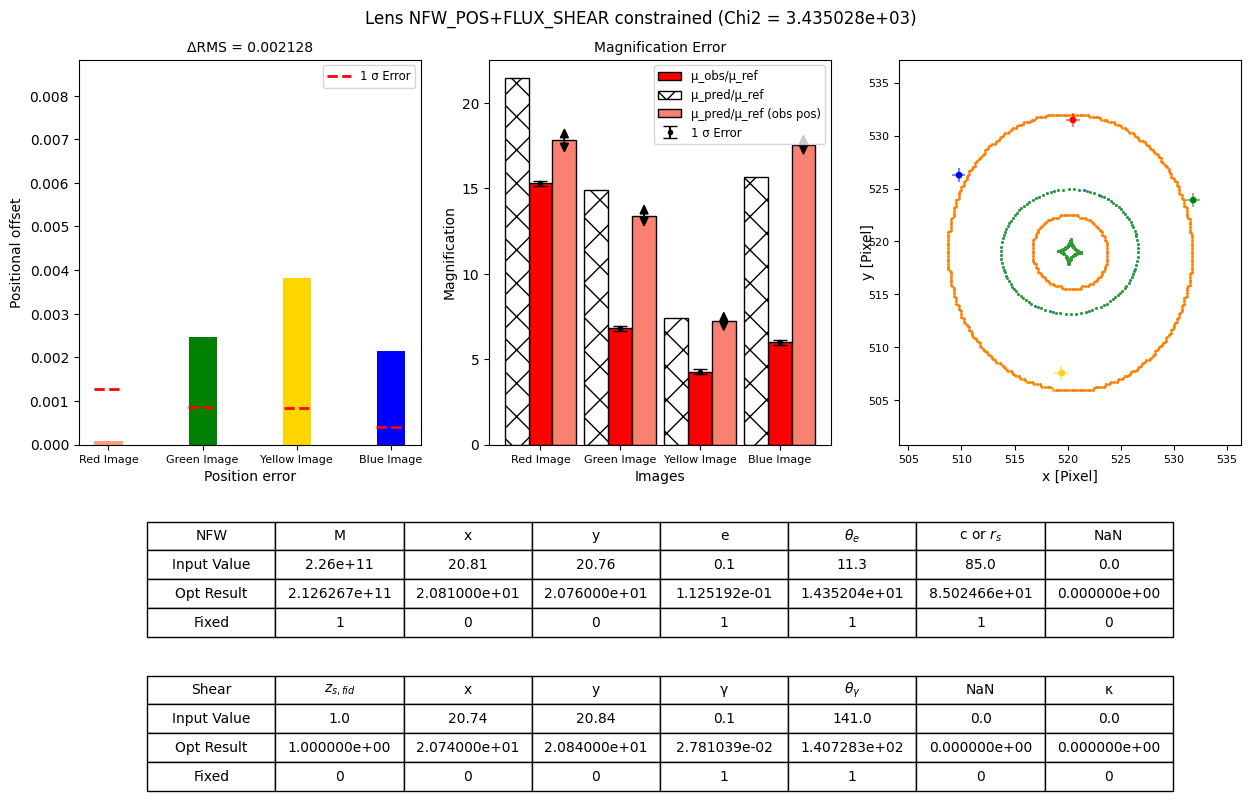

In [21]:
plot_name_1 = 'NFW_POS+FLUX_SHEAR'
loc = 'NFW+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [1]:
# C_SIE + SHEAR + FIXED
%run C_SIE+SHEAR+FIX/pos_point.py

amoeba_delta = 7.844594e-01



######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 1.354069e+04  tol = 1.968290e+00
amoeba:  n =     2  y = 1.354069e+04  tol = 1.902670e+00
amoeba:  n =     3  y = 1.354069e+04  tol = 1.897016e+00
amoeba:  n =     4  y = 1.354069e+04  tol = 1.873002e+00
amoeba:  n =     5  y = 1.354069e+04  tol = 1.848891e+00
amoeba:  n =     6  y = 1.354069e+04  tol = 1.834406e+00
amoeba:  n =     7  y = 1.354069e+04  tol = 1.829461e+00
amoeba:  n =     8  y = 1.354069e+04  tol = 1.825935e+00
amoeba:  n =     9  y = 1.354069e+04  tol = 1.825935e+00
amoeba:  n =    10  y = 1.354069e+04  tol = 1.825935e+00
amoeba:  n =    11  y = 1.354069e+04  tol = 1.813422e+00
amoeba:  n =    12  y = 1.354069e+04  tol = 1.809074e+00
amoeba:  n =    13  y = 1.354069e+04  tol = 1.734287e+00
amoeba:  n =    14  y = 1.354069e+04  tol = 1.655820e+00
amoeba:  n =    15  y = 1.354069e+04  tol = 1.614206e+00
amoeba:  n =    16  y = 1.354069e+04  tol = 1.608323e+00
am

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7777   y =   20.3025   mag =   -6.8050 [  -2.082]   td[day] =     1.071
x =   20.8121   y =   20.7549   mag =    0.0064 [   5.490]   td[day] =     4.496
x =   21.2731   y =   20.9561   mag =   14.5195 [  -2.905]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   14.9594 [  -2.937]   td[day] =     0.037
x =   20.8198   y =   21.2593   mag =  -20.0520 [  -3.255]   td[day] =     0.160


= 6.744343e+00  tol = 2.616022e-01
amoeba:  n =   545  y = 6.744343e+00  tol = 2.410250e-01
amoeba:  n =   546  y = 6.744343e+00  tol = 2.015646e-01
amoeba:  n =   547  y = 6.744343e+00  tol = 1.788621e-01
amoeba:  n =   548  y = 6.744343e+00  tol = 1.761699e-01
amoeba:  n =   549  y = 6.744343e+00  tol = 1.747571e-01
amoeba:  n =   550  y = 6.744343e+00  tol = 1.690141e-01
amoeba:  n =   551  y = 6.744343e+00  tol = 1.657187e-01
amoeba:  n =   552  y = 6.744343e+00  tol = 1.655455e-01
amoeba:  n =   553  y = 6.672151e+00  tol = 1.607133e-01
amoeba:  n =   554  y = 6.672151e+00  tol = 1.235861e-01
amoeba:  n =   555  y = 6.672151e+00  tol = 1.162271e-01
amoeba:  n =   556  y = 6.672151e+00  tol = 1.091949e-01
amoeba:  n =   557  y = 6.672151e+00  tol = 9.866119e-02
amoeba:  n =   558  y = 6.302608e+00  tol = 1.415160e-01
amoeba:  n =   559  y = 6.302608e+00  tol = 1.284486e-01
amoeba:  n =   560  y = 6.145751e+00  tol = 1.355040e-01
amoeba:  n =   561  y = 6.145751e+00  tol = 1.331834e

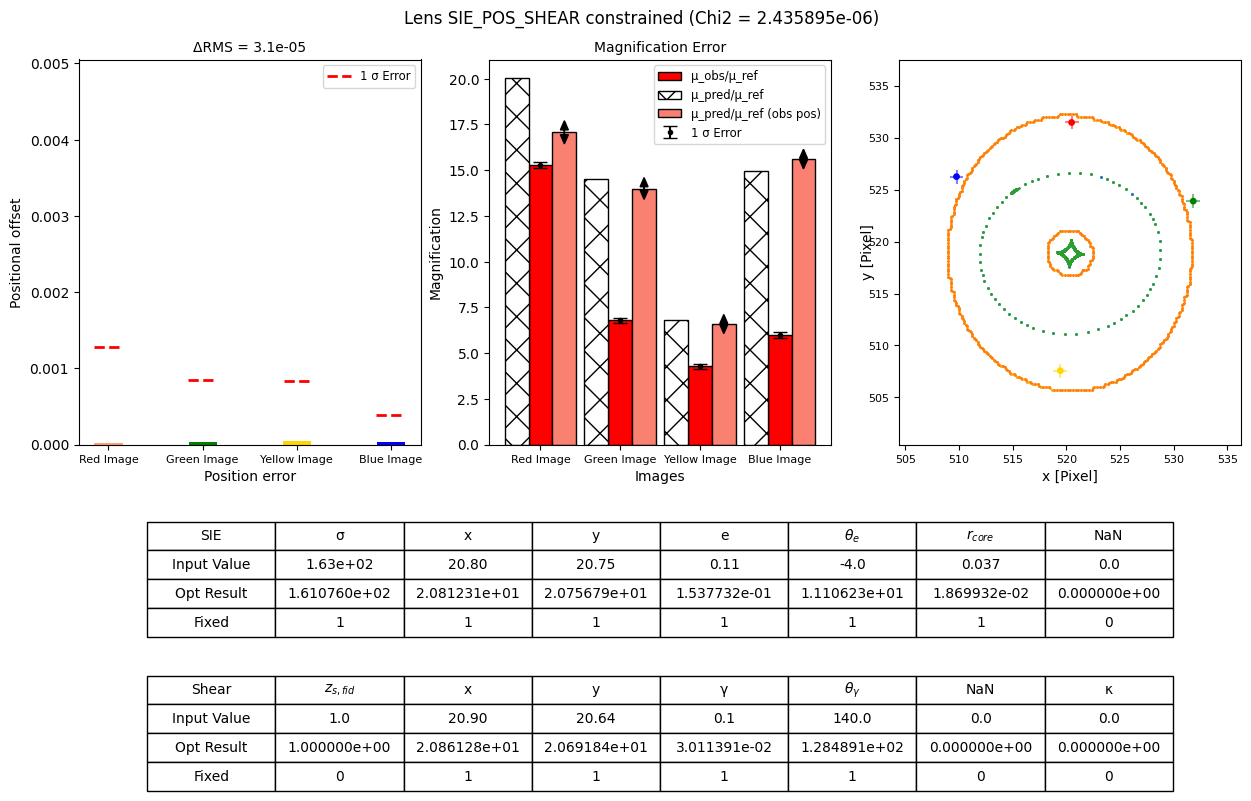

In [5]:
plot_name_1 = 'SIE_POS_SHEAR'
loc = 'C_SIE+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [ ]:
# C_SIE + SHEAR + FIXED
%run C_SIE+SHEAR+FIX/pos_flux_point.py

In [1]:
# EIN + SHEAR + FIXED
%run EIN+SHEAR+FIX/pos_point.py

amoeba_delta = 7.480528e-01

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7777   y =   20.3025   mag =   -5.5927 [  -1.869]   td[day] =     1.346
x =   20.8105   y =   20.7382   mag =    0.1636 [   1.966]   td[day] =     3.168
x =   21.2731   y =   20.9561   mag =   11.1270 [  -2.616]   td[day] =     0.000
x =   20.3909   y =   21.0506   mag =   11.7220 [  -2.673]   td[day] =     0.050
x =   20.8198   y =   21.2593   mag =  -15.6931 [  -2.989]   td[day] =     0.203


######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

 making tables for ein... [99 x 801 = 79299 points]

amoeba:  n =     1  y = 2.065307e+05  tol = 1.377932e+00
amoeba:  n =     2  y = 2.065307e+05  tol = 1.309699e+00
amoeba:  n =     3  y = 1.314621e+05  tol = 1.528596e+00
amoeba:  n =     4  y = 5.385961e+04  tol = 1.714943e+00
amoeba:  n =     5  y = 3.798290e+04  tol = 1.793026e+00
amoeba:  n =     6  y = 3.798290e+04  tol = 1.793026e+00
amoeba:  n =     7  y = 3.798290e+04  tol = 1.793026e+00
amoeba:  n =     8  y = 3.798290e+04  tol = 1.730945e+00
amoeba:  n =     9  y = 3.798290e+04  tol = 1.659086e+00
amoeba:  n =    10  y = 3.798290e+04  tol = 1.609943e+00
amoeba:  n =    11  y = 3.798290e+04  tol = 1.598396e+00
amoeba:  n =    12  y = 3.798290e+04  tol = 1.378638e+00
amoeba:  n =    13  y = 3.798290e+04  tol = 1.350237e+00
amoeba:  n =    14  y = 3.798290e+04  tol = 1.328407e+00
amoeba:  n =    15  y = 3.798290e+04  tol = 1.103358e+00
amoeba

-06  tol = 1.271525e+00
amoeba:  n =   404  y = 3.570125e-06  tol = 1.255013e+00
amoeba:  n =   405  y = 3.173451e-06  tol = 1.096753e+00
amoeba:  n =   406  y = 2.359102e-06  tol = 1.203651e+00

------------------------------------------
optimize ndim=12
run 1: 406 lens models calculated
chi^2 = 2.359102e-06  [N_data(extend): 0]
 extend     : 0.000000e+00 0.000000e+00 0.000000e+00
 point no 1 : 2.359102e-06 2.359102e-06 0.000000e+00 0.000000e+00 0.000000e+00
 lens prior : 0.000000e+00
 map prior  : 0.000000e+00

omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000

lens   ein     0.2613  6.543579e+10  2.081171e+01  2.075023e+01  1.576411e-01  7.065128e+00  4.991318e+01  5.000000e-01 
lens   pert    0.2613  1.000000e+00  2.095035e+01  2.071835e+01  2.495284e-02  1.311713e+02  0.000000e+00  0.000000e+00 
point  1.0000  2.081602e+01  2.077415e+01 
------------------------------------------

writing result to EIN+SHEAR+FIX/EIN_POS_SHEAR_optresult.dat

amoeba:  n =     1  y = 2

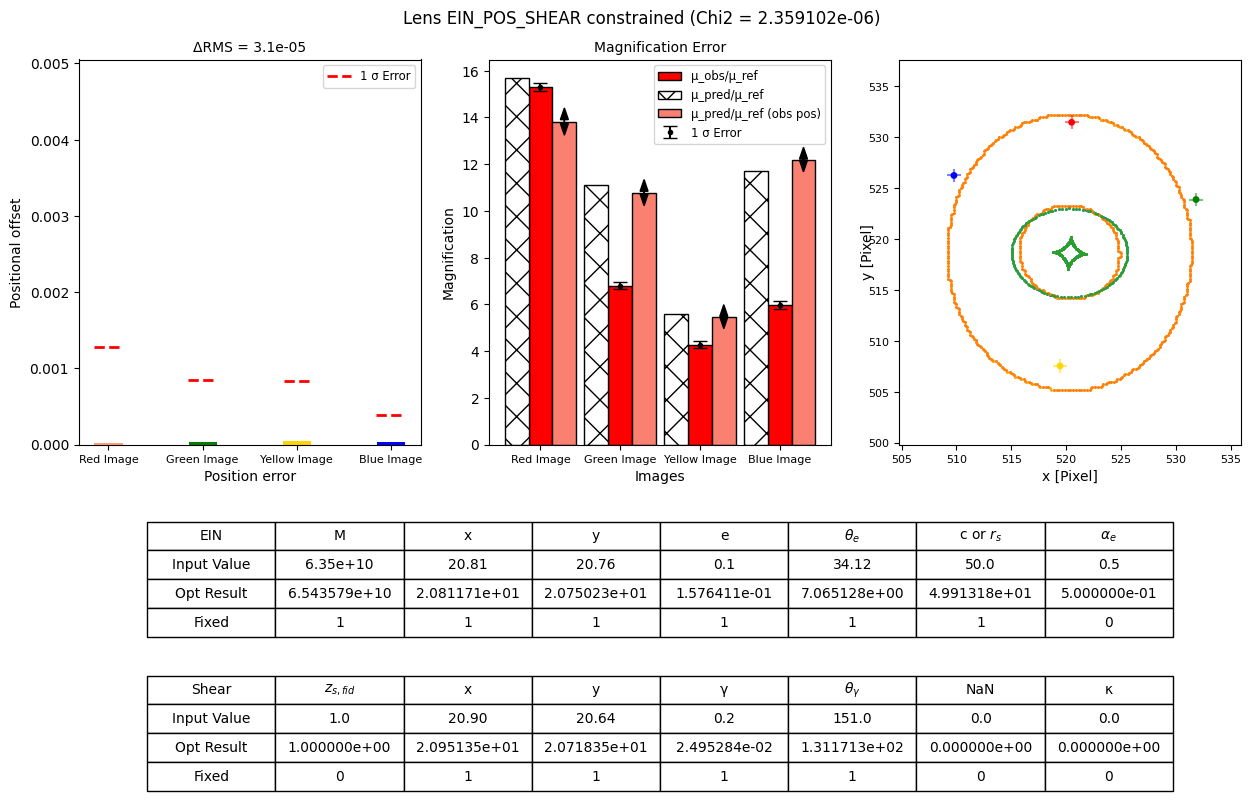

In [4]:
plot_name_1 = 'EIN_POS_SHEAR'
loc = 'EIN+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)

In [5]:
# EIN + SHEAR + FIXED
%run EIN+SHEAR+FIX/pos_flux_point.py

amoeba_delta = 8.608299e-01

amoeba_delta = 1.464867e-02

amoeba_delta = 1.465163e-02

amoeba_delta = 1.000000e-02

n_img = 5
x =   20.7780   y =   20.3033   mag =   -4.8124 [  -1.706]   td[day] =     1.547
x =   20.8099   y =   20.7314   mag =    0.1702 [   1.923]   td[day] =     3.241
x =   21.2729   y =   20.9556   mag =    9.6964 [  -2.467]   td[day] =     0.000
x =   20.3909   y =   21.0501   mag =   10.1574 [  -2.517]   td[day] =     0.058
x =   20.8198   y =   21.2595   mag =  -13.3257 [  -2.812]   td[day] =     0.238


######## optimizing lens
 number of parameters = 10 (lens) + 0 (extend) + 2 (point) 

amoeba:  n =     1  y = 6.921412e+05  tol = 7.061466e-01
amoeba:  n =     2  y = 6.921412e+05  tol = 5.970458e-01
amoeba:  n =     3  y = 3.817725e+05  tol = 1.015062e+00
amoeba:  n =     4  y = 3.817725e+05  tol = 1.010211e+00
amoeba:  n =     5  y = 3.817725e+05  tol = 9.907236e-01
amoeba:  n =     6  y = 3.817725e+05  tol = 9.355118e-01
amoeba:  n =     7  y = 3.817725e+05  tol = 8.538222e-01
amoeba:  n =     8  y = 3.817725e+05  tol = 8.379290e-01
amoeba:  n =     9  y = 3.817725e+05  tol = 8.093246e-01
amoeba:  n =    10  y = 3.817725e+05  tol = 7.811841e-01
amoeba:  n =    11  y = 3.817725e+05  tol = 7.775834e-01
amoeba:  n =    12  y = 2.645279e+05  tol = 1.065267e+00
amoeba:  n =    13  y = 2.645279e+05  tol = 1.065267e+00
amoeba:  n =    14  y = 1.662009e+05  tol = 1.322224e+00
amoeba:  n =    15  y = 1.662009e+05  tol = 1.225480e+00
amoeba:  n =    16  y = 1.662009e+05  tol = 1.154509e+00
am

40e-03
amoeba:  n =   141  y = 3.481866e+03  tol = 3.294006e-03
amoeba:  n =   142  y = 3.481866e+03  tol = 3.282058e-03
amoeba:  n =   143  y = 3.471558e+03  tol = 6.082258e-03
amoeba:  n =   144  y = 3.471558e+03  tol = 6.004213e-03
amoeba:  n =   145  y = 3.471558e+03  tol = 5.740247e-03
amoeba:  n =   146  y = 3.471558e+03  tol = 5.257056e-03
amoeba:  n =   147  y = 3.471558e+03  tol = 5.167565e-03
amoeba:  n =   148  y = 3.471558e+03  tol = 4.814978e-03
amoeba:  n =   149  y = 3.471558e+03  tol = 4.528842e-03
amoeba:  n =   150  y = 3.471558e+03  tol = 3.814397e-03
amoeba:  n =   151  y = 3.471558e+03  tol = 3.718224e-03
amoeba:  n =   152  y = 3.471558e+03  tol = 3.539400e-03
amoeba:  n =   153  y = 3.471558e+03  tol = 3.116232e-03
amoeba:  n =   154  y = 3.471558e+03  tol = 3.024965e-03
amoeba:  n =   155  y = 3.471558e+03  tol = 2.964818e-03
amoeba:  n =   156  y = 3.471558e+03  tol = 2.632138e-03
amoeba:  n =   157  y = 3.471558e+03  tol = 2.457971e-03
amoeba:  n =   158  y = 

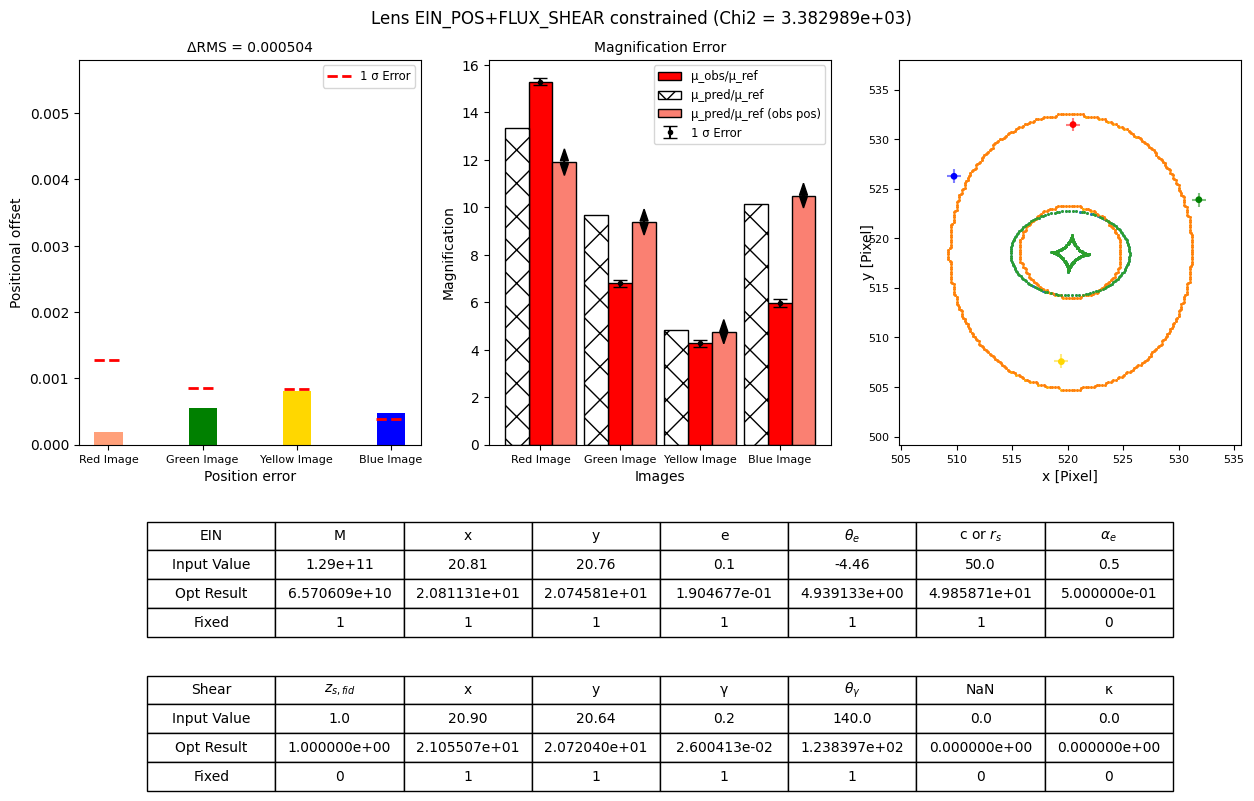

In [6]:
plot_name_1 = 'EIN_POS+FLUX_SHEAR'
loc = 'EIN+SHEAR+FIX/'

if 'POS+FLUX' in plot_name_1 or 'pos+flux' in plot_name_1:
    constraint = 'pos_flux'
else:
    constraint = 'pos'

filename_0 = loc + constraint + '_point.py'
filename_1 = 'obs_point/obs_point_(POS).dat'
filename_2 = 'obs_point/obs_point_(POS+FLUX).dat'
filename_3 = loc + plot_name_1 + '_crit.dat'
filename_4 = loc + plot_name_1 + '_point.dat'
filename_5 = loc + plot_name_1 + '_lens.fits'
filename_6 = loc + plot_name_1 + '_optresult.dat'
num_images = 4
plot_name = plot_name_1

if 'SHEAR' in plot_name or 'shear' in plot_name:
    shear_set = True
else:
    shear_set = False

if 'FLUX' in plot_name or 'flux' in plot_name or 'Flux' in plot_name:
    filename_1 = 'obs_point/obs_point_(POS+FLUX).dat'

glafic_tabular(filename_0, filename_6, save_table_flag = False, shear=shear_set, show_shear=False, show_params=False)

obs_data, pred_data = error_plot(filename_1, filename_2, filename_4, filename_5, plot_name, num_images, table_flag=True, glafic_file_1= filename_0, glafic_file_2=filename_6, shear = shear_set, show_params=False, show_shear=False)

curve_data = critcurve_plot(filename_4, filename_3, pos_output=obs_data, num_images=num_images)